## Things Left:
* Data Splitting into train, val, test - **Done**
* Update Datasets for torch dataloader - **Done**
* Update Models - **Done**
* Training loop Update
    * loss function
    * regularization of intermediate layer in word predict sub network
    * do context updates consecutively or seperate
* Attention Network Weights
    * For each token in our dataset
        * aggregate the attention weight
    * Rank each token
    * Check the change in Rank when compairing single task vs multitask
* Compare the use of loss weights
* Compare the use of context word from headline vs body of the news article

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from Scripts.utils.bert_utils import load_tokenizer
import  gc
import time
import pickle
import dill
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch
from Scripts.utils.bert_utils import load_model, load_tokenizer, batch_text_gen
from tqdm import tqdm
import h5py
import random
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [5]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True

In [5]:
# top_10_sim_cps = load_pickle("current_pickle_obs/top10cp.pickle")
# doc_2_cluster_map = load_pickle("current_pickle_obs/doc_2_cluster_map.pickle")
# rel_df = load_pickle("current_pickle_obs/rel_df_with_wp.pickle")

In [6]:
# top_10_sim_cps

In [7]:
# rel_df["doc_indices"] = rel_df.index

In [8]:
# rel_df.head(1)

## Data Splitting

In [6]:
def balance_classes(df):
    """
    """
    min_partisan = df.binary_ps.value_counts().min()
    
    df_0 = df[df.binary_ps == 0].sample(min_partisan,random_state=42)
    df_1 = df[df.binary_ps == 1].sample(min_partisan,random_state=42)
    
    df = pd.concat((df_0,df_1)).sample(frac=1,random_state=42)
    
    return df

def get_label_dist(labels):
    """
    """
    print("1 : %s" %str(sum(labels)))
    print("0 : %s" %str(len(labels) - sum(labels)))

    
def split_data_mixed(c1s,c2,cluster_2_doc_map,df,c2_train_perc=0.10):
    """
    Train - 90 % from c1 mix + 10% from c2
    Test - 50% from c1 mix and 50% from c2
    """
    c1_sizes = [len(cluster_2_doc_map[c]) for c in c1s]
    c2_size = len(cluster_2_doc_map[c2])
    
    min_c_size = min(c1_sizes+[c2_size])
    train_size = 0.65 * min_c_size
    test_size = 0.2 * min_c_size
    val_size = 0.15 * min_c_size
    
    print("Selected data sizes : ")
    print("Train Size : %s" %str(train_size))
    print("Test Size : %s" %str(test_size))
    print("Val Size : %s" %str(val_size))
    
    c1_mix_train_size = 0.9 * train_size
    c2_train_size = c2_train_perc * train_size
    
    print("Percentage of train size for c in c1mix : %s"%str(c1_mix_train_size/len(c1s)))
    
    
    c1_mix_val_size = 0.9 * val_size
    c2_val_size = 0.1 * val_size
    
    print("Percentage of Val size for c in c1mix : %s"%str(c1_mix_val_size/len(c1s)))
    
    c1_mix_test_size = 0.5 * test_size
    c2_test_size = 0.5 * test_size
    
    print("Percentage of test size for c in c1mix : %s"%str(c1_mix_test_size/len(c1s)))
    
    cmix_train = []
    cmix_test = []
    cmix_val = []
    
    strata_columns = "binary_ps"
    
    # Sample c1mix for train,val,test
    for c in c1s:
        c_df = df.iloc[cluster_2_doc_map[c]]
        c_df["which_cluster"] = [1]*c_df.shape[0]
        c_df["context_pos_words_size"] = c_df["context_pos_words"].apply(lambda x: len(x))
        c_df = c_df[c_df["context_pos_words_size"] > 0]
        c_df = balance_classes(c_df)
        
        c_train, c_test = train_test_split(c_df,test_size=int(c1_mix_test_size/len(c1s)), stratify=c_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
        c_train, c_val = train_test_split(c_train,test_size=int(c1_mix_val_size/len(c1s)), stratify=c_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
        
        if c_train.shape[0] > int(c1_mix_train_size/len(c1s)):
            c_train,_ = train_test_split(c_train,train_size=int(c1_mix_train_size/len(c1s)), stratify=c_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
        
        
        cmix_train.append(c_train)
        cmix_test.append(c_test)
        cmix_val.append(c_val)
        
     # Merge the cluster dfs
    
    cmix_train = pd.concat(cmix_train,axis=0)
    cmix_test = pd.concat(cmix_test,axis=0)
    cmix_val = pd.concat(cmix_val,axis=0)
    
    # Subsample to balance the sizes
    
    if cmix_train.shape[0] > c1_mix_train_size:
        cmix_train,_ = train_test_split(cmix_train,train_size=int(c1_mix_train_size), stratify=cmix_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if cmix_test.shape[0] > c1_mix_test_size:
        cmix_test,_ = train_test_split(cmix_test,train_size=int(c1_mix_test_size), stratify=cmix_test[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if cmix_val.shape[0] > c1_mix_val_size:
        cmix_val,_ = train_test_split(cmix_val,train_size=int(c1_mix_val_size), stratify=cmix_val[strata_columns], random_state=CONFIG.RANDOM_SEED)
        
        
    
    # Sample from c2
    c2_df = df.iloc[cluster_2_doc_map[c2]]
    c2_df["which_cluster"] = [2]*c2_df.shape[0]
    c2_df["binary_ps"] = c2_df["binary_ps"].apply(lambda x: np.abs(x+(-1)))
    c2_df["context_pos_words_size"] = c2_df["context_pos_words"].apply(lambda x: len(x))
    c2_df = c2_df[c2_df["context_pos_words_size"] > 0]
    c2_df = balance_classes(c2_df)
    
    c2_train,c2_test = train_test_split(c2_df,test_size=int(c2_test_size), stratify=c2_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
    c2_train,c2_val = train_test_split(c2_train,test_size=int(c2_val_size), stratify=c2_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    # Subsample to balance the sizes
    
    if c2_train.shape[0] > c2_train_size:
        c2_train,_ = train_test_split(c2_train,train_size=int(c2_train_size), stratify=c2_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if c2_test.shape[0] > c2_test_size:
        c2_test,_ = train_test_split(c2_test,train_size=int(c2_test_size), stratify=c2_test[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if c2_val.shape[0] > c2_val_size:
        c2_val,_ = train_test_split(c2_val,train_size=int(c2_val_size), stratify=c2_val[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    
    # Combine c1mix with c2
    train = pd.concat([cmix_train,c2_train],axis=0).sample(frac=1,random_state=42)
    test = pd.concat([cmix_test,c2_test],axis=0).sample(frac=1,random_state=42)
    val = pd.concat([cmix_val,c2_val],axis=0).sample(frac=1,random_state=42)
    
    print("\nSampled Data Sizes: ")
    print("Train Size : %s" %str(train.shape))
    get_label_dist(train["binary_ps"])
    print("Test Size : %s" %str(test.shape))
    get_label_dist(test["binary_ps"])
    print("Val Size : %s" %str(val.shape))
    get_label_dist(val["binary_ps"])
    
    return train,test,val
    
    pass

def split_data(cluster_pair,cluster_2_doc_map,df):
    """
    """
    c1_df = df.iloc[cluster_2_doc_map[cluster_pair[0]]]
    c2_df = df.iloc[cluster_2_doc_map[cluster_pair[1]]]
    
    print("C1 Shape : %s" %str(c1_df.shape))
    print("C2 Shape : %s" %str(c2_df.shape))
    
    c1_df["which_cluster"] = [1]*c1_df.shape[0]
    c2_df["which_cluster"] = [2]*c2_df.shape[0]
    
    # drop rows where context words are absent
    c1_df["context_pos_words_size"] = c1_df["context_pos_words"].apply(lambda x: len(x))
    c1_df = c1_df[c1_df["context_pos_words_size"] > 0]
    
    c2_df["context_pos_words_size"] = c2_df["context_pos_words"].apply(lambda x: len(x))
    c2_df = c2_df[c2_df["context_pos_words_size"] > 0]
    
    c1_df = balance_classes(c1_df)
    c2_df = balance_classes(c2_df)
    
    # Flip c2 labels
    c2_df["binary_ps"] = c2_df["binary_ps"].apply(lambda x: np.abs(x+(-1)))
    
    print("Data Shape after balancing :")
    print("C1 Shape : %s" %str(c1_df.shape))
    print("C2 Shape : %s" %str(c2_df.shape))
    
    strata_columns = "binary_ps"
    
    # min size btw cluster pair
    min_c_size = min(c1_df.shape[0],c2_df.shape[0])
    
    # from this min size we need a train, test and val
    # i.e train + test + val = min_c_size
    
    train_size = 0.7 * min_c_size
    test_size = 0.2 * min_c_size
    val_size = 0.1 * min_c_size
    
    train_size_c1 = int(0.9 * train_size)
    train_size_c2 = int(0.1 * train_size)
    
    test_size_c1 = int(0.5 * test_size)
    test_size_c2 = int(0.5 * test_size)
    
    val_size_c1 = int(0.9 * val_size)
    val_size_c2 = int(0.1 * val_size)
    
    
    
    # Train - 90% c1, 10% c2
    c1_train, c1_test = train_test_split(c1_df,test_size=0.20, stratify=c1_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
    c1_train, c1_val = train_test_split(c1_train,test_size=0.10,stratify=c1_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    c2_df_train,c2_df_test = train_test_split(c2_df,train_size=int(0.1*c1_train.shape[0]),stratify=c2_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
    train = pd.concat([c1_train,c2_df_train],axis=0).sample(frac=1,random_state=42)
    
    # Test - 50% c1 , 50% c2
    c2_test_,c2_val_temp = train_test_split(c2_df_test,train_size=c1_test.shape[0],stratify=c2_df_test[strata_columns], random_state=CONFIG.RANDOM_SEED)
    test = pd.concat([c1_test,c2_test_],axis=0).sample(frac=1,random_state=42)
    
    # Val - 90% c1, 10% c2
    c2_val , _ = train_test_split(c2_val_temp,train_size=int(c1_val.shape[0]*0.10),stratify=c2_val_temp[strata_columns], random_state=CONFIG.RANDOM_SEED)
    val = pd.concat([c1_val,c2_val],axis=0).sample(frac=1,random_state=42)
    
    print("Data Sizes :")
    print("Train : %s" %str(train.shape))
    print("Val : %s" %str(val.shape))
    print("Test : %s" %str(test.shape))
    
    print("Label Distributions :")
    print("Train :")
    get_label_dist(train["binary_ps"])
    print("Val : ")
    get_label_dist(val["binary_ps"])
    print("Test : ")
    get_label_dist(test["binary_ps"])
    
    return train, test, val
    

# 173 - Immigration/ border wall
# 220 - Gun Control

In [10]:
train,test,val = split_data(cluster_pair=(220,173),cluster_2_doc_map=doc_2_cluster_map,df=rel_df)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


In [11]:
train = train[train.doc_indices <= 99402 ]
test = test[test.doc_indices <= 99402 ]
val = val[val.doc_indices <= 99402 ]

In [12]:
print(train.shape)
print(test.shape)
print(val.shape)

(779, 16)
(397, 16)
(88, 16)


In [10]:
train = train[train.doc_indices <= 99402 ]

In [11]:
train.shape

(779, 16)

In [12]:
val.head(1)

title  \
88595  Where Kamala Harris stands on the biggest 2020...   

                                                    text  \
88595  Sen . Michael Bennet told CBS News the Senate ...   

       source_partisan_score  binary_ps  \
88595                   -1.0          0   

                                          processed_text  \
88595  sen michael bennet told cbs news the senate sh...   

                                                all_text  Num_Tokens  \
88595  where kamala harris stands on the biggest 2020...         168   

                                         processed_title  Num_Tokens_HL  \
88595  where kamala harris stands on the biggest 2020...              9   

             context_pos_words          context_neg_words  \
88595  [2020, harris, biggest]  [threaten, keeping, fate]   

      context_pos_words_body context_neg_words_body  doc_indices  \
88595    [pol, loop, julian]    [emmy, barr, shout]        88595   

       which_cluster  context_pos_words_size  
88595              1                       3

## Torch Datasets for Dataloaders

In [7]:
class CPDatasetST(torch.utils.data.Dataset):
    """
    Should return bert embedding, label, which cluster, actual text
    Simple case no context word
    """
    def __init__(self, df,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5"):
        self.df = df
        self.hdf_path = hdf_file_path
        self.h5file = h5py.File(self.hdf_path, "r")
        self.d_set = self.h5file.get("bert_embeds")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        t1 = self.df["all_text"].iloc[index]
        y1 = self.df["binary_ps"].iloc[index]
        wc = self.df["which_cluster"].iloc[index]
        
        
        y1 = torch.Tensor([y1])
        wc = torch.Tensor([wc])
        x1 = self.d_set[self.df["doc_indices"].iloc[index],:,:]
        
        x1 = torch.Tensor(x1)
        

        return x1, y1, t1, wc

# For the multitask, each _getitem_ will not return a single item for context words but the list of words, where multiple updates for each sample should occur in train

def get_bert_embeddings(df,model,tokenizer):
    """
    should return a list of dictionaries where dictionary has context word embedding and label
    """
    
    texts_pos = df["context_pos_words"].tolist()
    texts_neg = df["context_neg_words"].tolist()
    single_pos = [pos[0] for pos in texts_pos]
    single_neg = [neg[0] for neg in texts_neg]
    
    embeds_list = []
    
    with torch.no_grad():
        for i in tqdm(range(len(texts_pos)),total=len(texts_pos)):
            
            embed_dict = {}

            encoded_pos = tokenizer.encode_plus(texts_pos[i], add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            encoded_neg = tokenizer.encode_plus(texts_neg[i], add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')

            token_pos = encoded_pos["input_ids"]
            token_neg = encoded_neg["input_ids"]

            token_tensors = torch.cat([token_pos,token_neg],dim=0)
            token_tensors = token_tensors.to(torch.device('cuda:1'))
            batch_out = model(token_tensors)
            batch_hidden_states = batch_out[2]
            batch_12_layer_tensor = batch_hidden_states[-1]

            pos_embed = batch_12_layer_tensor[0,:,:].cpu()
            neg_embed = batch_12_layer_tensor[1,:,:].cpu()
            
            embed_dict["pos"] = pos_embed
            embed_dict["neg"] = neg_embed
            
            embeds_list.append(embed_dict)
    
    return embeds_list
        

class CPDatasetMT(torch.utils.data.Dataset):
    """
    Should return bert embedding, label, which cluster, actual text
    Simple case no context word
    """
    def __init__(self, df,embeds_list,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",context_word_sample_size=2):
        self.df = df
        self.hdf_path = hdf_file_path
        self.h5file = h5py.File(self.hdf_path, "r")
        self.d_setx1 = self.h5file.get("bert_embeds")
        self.embeds_list = embeds_list

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        t1 = self.df["all_text"].iloc[index]
        y1 = self.df["binary_ps"].iloc[index]
        wc = self.df["which_cluster"].iloc[index]
        
        
        y1 = torch.Tensor([y1])
        wc = torch.Tensor([wc])
        x1 = self.d_setx1[self.df["doc_indices"].iloc[index],:,:]
        
        # create a dictionary of tensors here, with labels
        #{pos_embeds, pos_labels, neg_embeds, neg_labels}
        x2 = torch.cat([self.embeds_list[index]["pos"],self.embeds_list[index]["neg"]],dim=0)
        x1 = torch.Tensor(x1)
        return x1, x2, y1, t1, wc

In [14]:
train_dataset = CPDatasetST(train)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(y1.shape)
    print(wc.shape)

0
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
1
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
2
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
3
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
4
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
5
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
6
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
7
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
8
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
9
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
10
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
11
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
12
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
13
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
14
torch.Size([32, 350, 768])


In [20]:
model = load_model()
model.to(torch.device('cuda:1'))
model.eval()
tokenizer = load_tokenizer()

embeds_list_hl_context_words = get_bert_embeddings(train,model,tokenizer)

100%|██████████| 779/779 [00:05<00:00, 143.03it/s]


In [21]:
len(embeds_list_hl_context_words)

779

In [22]:
embeds_list_hl_context_words[0]['pos'].size()

torch.Size([1, 768])

In [34]:
train_mt = CPDatasetMT(train,embeds_list_hl_context_words)
train_dataloader = DataLoader(train_mt,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(x2.shape)
    print(y1.shape)
    print(wc.shape)
    
#     print(x2)
    break

0
torch.Size([32, 350, 768])
torch.Size([32, 2, 768])
torch.Size([32, 1])
torch.Size([32, 1])


## Models

In [8]:
class AttentionST(nn.Module):
    
    def __init__(self,embedding_size=768,verbose=True,which_forward=2,with_attention=True,dropout=0.3):
        super(AttentionST,self).__init__()
        
        self.with_attention = with_attention
        
        self.attention = nn.Linear(in_features=embedding_size,
                                       out_features=1,
                                       bias=False)
        
        
        self.dropout = nn.Dropout(dropout)
        
        self.recom_pred = nn.Linear(in_features=embedding_size,
                                    out_features=1,
                                    bias=True)

        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,embeddings):
        """
        """
        
        
        if self.with_attention:
        # iterate over articles in a given batch
            attention_vector_batch = []

            for sent in range(embeddings.size(0)):

                sent_embed_matrix = embeddings[sent,:,:] # 500 x 768

                word_weights = self.dropout(self.attention(sent_embed_matrix)).squeeze()

                self.normalized_word_weights = self.softmax(word_weights) # input is 500 x 1, output is 500 x 1

                attention_vector = sent_embed_matrix.T .mul(self.normalized_word_weights).sum(dim=1)

                attention_vector_batch.append(attention_vector.unsqueeze(-1).T) 
                

            attention_vector_batch = torch.cat(attention_vector_batch,dim=0) # we get (batch_size,768)
            
            y_preds = self.sigmoid(self.recom_pred(attention_vector_batch)).squeeze()
        
            return y_preds
        
        else:
            
            y_pred = self.sigmoid(self.recom_pred(embeddings[:,0,:])).squeeze()
            
            return y_pred


        

class AttentionMT(nn.Module):
    
    def __init__(self,embedding_size=768,dropout=0.1):
        super(AttentionMT,self).__init__()
        
        self.attention = nn.Linear(in_features=embedding_size,
                                   out_features=1,
                                   bias=False)
        
        self.interm_word = nn.Linear(in_features=embedding_size,
                                    out_features=embedding_size,
                                    bias=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.word_weights = nn.Linear(in_features=embedding_size,
                                   out_features=1,
                                   bias=True)
        
        # Recommendation Network
        # ------------------------
        
        self.recom_pred = nn.Linear(in_features=embedding_size,
                                    out_features=1,
                                    bias=True)
        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,text_embeds,context_embed):
        """
        """
        attention_vector_batch = []
        
        for sent in range(text_embeds.size(0)):

            sent_embed_matrix = text_embeds[sent,:,:] # 500 x 768

            word_weights = self.dropout(self.attention(sent_embed_matrix)).squeeze()

            self.normalized_word_weights = self.softmax(word_weights) # input is 500 x 1, output is 500 x 1

            attention_vector = sent_embed_matrix.T.mul(self.normalized_word_weights).sum(dim=1)

            attention_vector_batch.append(attention_vector.unsqueeze(-1).T) 
                
                
        attention_vector_batch = torch.cat(attention_vector_batch,dim=0) # we get (batch_size,768)

        y_preds = self.sigmoid(self.recom_pred(attention_vector_batch))
        
        
        word_preds = None
        
        if context_embed is not None:
        # Word Prediction Part
        
            # convert 3d to 2d matrix
            original_size = context_embed.size()
            context_embed = context_embed.view(original_size[0],original_size[-1])
#             context_embed = self.sigmoid(self.dropout(self.interm_word(context_embed)))

            dot_prod_sim = torch.mul(attention_vector_batch, context_embed) # dot product between (N,768) and (N,768)

            word_preds = self.sigmoid(self.word_weights(dot_prod_sim))

            word_preds = word_preds.view(word_preds.size()[0],1)
        
        return y_preds,word_preds

## Train Code

In [26]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)



@timer
def run_ssda_ST(train,test,val,lr,epochs=2,batch_size=8,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True,cp=None,avg_type="binary"):
    """
    """
    seed_all(42)
    
    model = AttentionST(embedding_size=768,with_attention=with_attention,dropout = dropout)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    total_losses_val = []
    word_losses = []
    rs_losses = []
    
    
    train_dataset = CPDatasetST(train)
    test_dataset = CPDatasetST(test)
    val_dataset = CPDatasetST(val)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    test_dataloader = DataLoader(test_dataset,batch_size=100,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    val_dataloader = DataLoader(val_dataset,batch_size=100,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    
    for epoch in tqdm(range(epochs),total=epochs):
        batch_losses =  []
        # Training
        for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
            
            model.train()

            x1,y1 = x1.to(cuda_device),y1.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred = model(x1)
            
            if batch_size == 1:
                y1 = y1.view(1)
            
            if batch_size > 1:
                y1 = y1.squeeze()
            
            total_loss = loss_func(y_pred,y1.squeeze()) 
            
            total_loss.backward()
            
            opt.step()
            
            batch_losses.append(total_loss.item())
        
        # Validation
        batch_losses_val =  []
        for bn_v, (xv1,yv1,tv1,wcv) in enumerate(val_dataloader):
            
            model.eval()
            with torch.no_grad():
                xv1,yv1 = xv1.to(cuda_device),yv1.to(cuda_device)

                y_pred = model(xv1)
                
                if batch_size == 1:
                    yv1 = yv1.view(1)
            
                if batch_size > 1:
                    yv1 = yv1.squeeze()

                total_loss_val = loss_func(y_pred,yv1) 
                batch_losses_val.append(total_loss_val.item())
        
        avg_batch_loss = np.mean(batch_losses)
        avg_batch_loss_val = np.mean(batch_losses_val)
        total_losses.append(avg_batch_loss)
        total_losses_val.append(avg_batch_loss_val)

        
    epoch_losses["total_loss"] = total_losses
    epoch_losses["total_loss_val"] = total_losses_val
        
    scores_train = evaluate_st(model,train_dataloader,device=cuda_device,avg_type=avg_type)
    scores_val = evaluate_st(model,val_dataloader,device=cuda_device,avg_type=avg_type)
    scores_test = evaluate_st(model,test_dataloader,device=cuda_device,avg_type=avg_type)
    
    x1 = None
    y1 = None
    total_loss = None
    opt = None
    

    del x1
    del y1

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test, scores_val


@timer
def run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,lr,word_loss_w,epochs=2,batch_size=8,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,l2=0.05,avg_type="binary"):
    """
    """
    seed_all(42)
    
    model = AttentionMT(embedding_size=768,dropout=dropout)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    word_losses = []
    rs_losses = []
    total_losses_val = []
    word_losses_val = []
    rs_losses_val = []
    
    train_dataset = CPDatasetMT(train,cw_embed_train)
    test_dataset = CPDatasetMT(test,cw_embed_test)
    val_dataset = CPDatasetMT(val,cw_embed_val)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers, shuffle=True,worker_init_fn=seed_worker)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    val_dataloader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
        
    for epoch in tqdm(range(epochs),total=epochs):
        
        batch_losses_total = []
        batch_losses_rec = []
        batch_losses_word = []
        
        for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
            
            # doing single updates
            for label_cw in range(2):
                
                # expand the context words 
                
                context_word_embed = x2[:,label_cw,:]
                if label_cw == 0:
                    word_labels = torch.Tensor([1]*x2.size()[0])
                
                if label_cw == 1:
                    word_labels = torch.Tensor([0]*x2.size()[0])
                
#                 context_word_embeds = torch.cat(context_word_embed,dim=0)
            
                model.train()

                x1,context_word_embed,y1,word_labels = x1.to(cuda_device),context_word_embed.to(cuda_device),y1.to(cuda_device),word_labels.to(cuda_device)

                opt.zero_grad() # reset all the gradient information

                y_pred, context_pred = model(x1, context_word_embed)

                rec_loss = loss_func(y_pred,y1)
                
                
                word_loss = loss_func(context_pred.squeeze(),word_labels)

                total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss) + model.word_weights.weight.norm(p=2) * l2

                total_loss.backward()

                opt.step()

                batch_losses_rec.append(rec_loss.item())
                batch_losses_word.append(word_loss.item())
                batch_losses_total.append(total_loss.item())
            
        avg_batch_losses_total = np.mean(batch_losses_total)
        avg_batch_losses_rec = np.mean(batch_losses_rec)
        avg_batch_losses_word = np.mean(batch_losses_word)
#         print("Avg Batch Total Loss Train : %s" %str(avg_batch_losses_total))
        
        
        batch_losses_total_val = []
        batch_losses_rec_val = []
        batch_losses_word_val = []

        for bn_v, (x1v, x2v, y1v, t1v, wcv) in enumerate(val_dataloader):

            model.eval()
            with torch.no_grad():
                
                for label_cw in range(2):
                    
                    context_word_embed = x2v[:,label_cw,:]
                    if label_cw == 0:
                        word_labels = torch.Tensor([1]*x1v.size()[0])

                    if label_cw == 1:
                        word_labels = torch.Tensor([0]*x1v.size()[0])

#                     context_word_embeds = torch.cat(context_word_embed,dim=0)
            
                    x1v,context_word_embed,y1v,word_labels = x1v.to(cuda_device),context_word_embed.to(cuda_device),y1v.to(cuda_device),word_labels.to(cuda_device)

                    y_pred, context_pred = model(x1v, context_word_embed)

                    if batch_size == 1:
                        y_pred = y_pred.view(1,1)
                        context_pred = context_pred.view(1,1)

                    rec_loss = loss_func(y_pred,y1v)
                    word_loss = None
                    if context_pred.squeeze().size() != word_labels.size():
                        word_loss = loss_func(context_pred,word_labels.view(1,1))
                    else:  
                        word_loss = loss_func(context_pred.squeeze(),word_labels)

                    total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss)

                    batch_losses_total_val.append(rec_loss.item())
                    batch_losses_word_val.append(word_loss.item())
                    batch_losses_rec_val.append(total_loss.item())
        

        avg_batch_losses_total_val =np.mean(batch_losses_total_val)
        avg_batch_losses_rec_val = np.mean(batch_losses_rec_val)
        avg_batch_losses_word_val =np.mean(batch_losses_word_val)
#         print("Avg Batch Toal Loss Val : %s" %str(avg_batch_losses_total_val))

        total_losses.append(avg_batch_losses_total)
        word_losses.append(avg_batch_losses_word)
        rs_losses.append(avg_batch_losses_rec)
        total_losses_val.append(avg_batch_losses_total_val)
        word_losses_val.append(avg_batch_losses_word_val)
        rs_losses_val.append(avg_batch_losses_rec_val)
            
    epoch_losses["rs_loss"] = rs_losses
    epoch_losses["word_loss"] = word_losses
    epoch_losses["total_loss"] = total_losses
    epoch_losses["rs_loss_val"] = rs_losses_val
    epoch_losses["word_loss_val"] = word_losses_val
    epoch_losses["total_loss_val"] = total_losses_val

    scores_train = evaluate_mt(model,train_dataloader,device=cuda_device,avg_type=avg_type)
    scores_val = evaluate_mt(model,val_dataloader,device=cuda_device,avg_type=avg_type)
    scores_test = evaluate_mt(model,test_dataloader,device=cuda_device,avg_type=avg_type)
    
    x1 = None
    x2 = None
    y1 = None
    y2 = None
    rec_loss = None
    total_loss = None
    word_loss = None
    opt = None
    

    del x1
    del x2
    del y1
    del y2

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test, scores_val

In [10]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Training Loss")
    ax.plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="red",label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
    
    axes = ax.ravel()
    
    ax[0].plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax[0].plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax[0].plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Training Loss")
    ax[0].set_title("Training Loss for ATMT")
    
    ax[1].plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="green",alpha=0.4,label="Total Loss")
    ax[1].plot(range(len(epoch_losses["word_loss_val"])),epoch_losses["word_loss_val"],c="blue",alpha=0.3,label="Word Loss")
    ax[1].plot(range(len(epoch_losses["rs_loss_val"])),epoch_losses["rs_loss_val"],c="red",label="RS Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Loss")
    ax[1].set_title("Validation Loss for ATMT")
    plt.legend()
    plt.show()

In [88]:
model, epoch_losses, scores_train, scores_test = run_ssda_ST(train,test,val,lr=0.0001,epochs=5,batch_size=16,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True)

100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Y1 Pred Dist : 
1 : 242
0 : 408
Predicted Label Shape : (650,)
True Label Shape : (650,)
Predicted Label Shape : (591,)
True Label Shape : (591,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0092 mins

Y1 Pred Dist : 
1 : 130
0 : 200
Predicted Label Shape : (330,)
True Label Shape : (330,)
Predicted Label Shape : (165,)
True Label Shape : (165,)
Predicted Label Shape : (165,)
True Label Shape : (165,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.0765 mins



In [89]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.4421768707482993,
                                       'precision': 0.5,
                                       'recall': 0.39634146341463417,
                                       'accuracy': 0.5023875991771967,
                                       'roc_auc': 0.503030303030303})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.4358974358974359,
                                       'precision': 0.4594594594594595,
                                       'recall': 0.4146341463414634,
        

In [17]:
bmodel = load_model()
bmodel.to(torch.device('cuda:1'))
bmodel.eval()
tokenizer = load_tokenizer()

cw_embed_train = get_bert_embeddings(train,bmodel,tokenizer)
cw_embed_test = get_bert_embeddings(test,bmodel,tokenizer)
cw_embed_val = get_bert_embeddings(val,bmodel,tokenizer)

100%|██████████| 88/88 [00:00<00:00, 143.02it/s]


In [26]:
model, epoch_losses, scores_train, scores_test = run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,
                                                             lr=0.001,
                                                             word_loss_w=0.4,
                                                             epochs=10,
                                                             batch_size=16,
                                                             dropout=0.3,
                                                             cuda_device=torch.device('cuda:1'),num_workers=1)

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 437
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 218
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0071 mins


Finished running 'run_ssda_MT' in 0.2051 mins



In [27]:
scores_test

defaultdict(<function attm_metrics.calculate_scores.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.5384615384615384,
                                       'precision': 0.5137614678899083,
                                       'recall': 0.5656565656565656,
                                       'accuracy': 0.5164966245368257,
                                       'roc_auc': 0.5163727959697733}),
                          'word_scores': defaultdict(float,
                                      {'f1': 0.0,
                                       'precision': 0.0,
                                       'recall': 0.0,
                                       'accuracy': 0.0,
                                       'roc_auc': 1.0})}),
             'cluster1': defaultdict(<function attm_metrics.calc

## Main Runner

In [11]:
# def seed_all(seed):
#     if not seed:
#         seed = 10

#     print("[ Using Seed : ", seed, " ]")

#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.cuda.manual_seed(seed)
#     numpy.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     numpy.random.seed(worker_seed)
#     random.seed(worker_seed)

def run_ssda_cp_st(df,c1s,c2,doc_2_cluster_map,
                   c2_train_perc=0.1,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=[3],
                   batch_sizes=[8],
                   dropouts=[0.0,0.1,0.3,0.5],
                   with_attention=True,
                   cuda_device=torch.device('cuda:1'), 
                   return_model=False,avg_type="binary"):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
#     train, test, val = split_data(cluster_pair=cp,cluster_2_doc_map=doc_2_cluster_map,df=df)
    
    train, test, val = split_data_mixed(c1s,c2,doc_2_cluster_map,df,c2_train_perc=c2_train_perc)
    
    train = train[train.doc_indices <= 99402 ]
    test = test[test.doc_indices <= 99402 ]
    val = val[val.doc_indices <= 99402 ]
    
    metrics_train = {}
    metrics_test = {}
    metrics_val = {}
    losses_train = {}
    model_dict = {}
    # train ssda func
    params = [learning_rates,epochs,batch_sizes,dropouts]
    
    params_all_combo = list(itertools.product(*params))
    
    print("Number of param combinations : %s" %str(len(params_all_combo)))
    
    for p_id,param_list in enumerate(params_all_combo):
        
        print("Param_setting : %s" %str(p_id))
        
        lr = param_list[0]
        epoch = param_list[1]
        batch_size = param_list[2]
        dropout=param_list[3]
        
        print("Running model for ----\n lr : %s\n epoch : %s\n batch_size : %s\n dropout : %s\n"%(str(lr),str(epoch),str(batch_size),str(dropout)))
        
        model = None
        gc.collect()
        torch.cuda.empty_cache()
        
        model, epoch_losses, scores_train, scores_test,scores_val  = run_ssda_ST(train,
                                                                     test,
                                                                     val,
                                                                     lr,
                                                                     epochs=epoch,
                                                                     batch_size=batch_size,
                                                                     dropout = dropout,
                                                                     cuda_device=cuda_device,
                                                                     num_workers=1,
                                                                     with_attention=with_attention,avg_type=avg_type)

        metrics_train[(lr,epoch,batch_size,dropout)] = scores_train
        metrics_val[(lr,epoch,batch_size,dropout)] = scores_val
        metrics_test[(lr,epoch,batch_size,dropout)] = scores_test
        losses_train[(lr,epoch,batch_size,dropout)] = epoch_losses
        
        if return_model:
            model_dict[(lr,epoch,batch_size,dropout)] = model
            
    return metrics_train,metrics_test, metrics_val,losses_train,model_dict



def run_ssda_cp_mt(df,c1s,c2,doc_2_cluster_map,
                    c2_train_perc=0.1,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=[3],
                   word_pred_loss_weights=[0.3,0.8],
                   batch_sizes=[8],
                   dropouts=[0.1],
                   l2s=[0.05],
                   cuda_device=torch.device('cuda:1'), 
                   return_model=False,avg_type="binary"):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test, val = split_data_mixed(c1s,c2,doc_2_cluster_map,df,c2_train_perc=c2_train_perc)
    
#     train, test, val = split_data(cluster_pair=cp,cluster_2_doc_map=doc_2_cluster_map,df=df)
    
    train = train[train.doc_indices <= 99402 ]
    test = test[test.doc_indices <= 99402 ]
    val = val[val.doc_indices <= 99402 ]
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    tokenizer = load_tokenizer()

    cw_embed_train = get_bert_embeddings(train,bmodel,tokenizer)
    cw_embed_test = get_bert_embeddings(test,bmodel,tokenizer)
    cw_embed_val = get_bert_embeddings(val,bmodel,tokenizer)
    
    
    metrics_train = {}
    metrics_test = {}
    metrics_val = {}
    losses_train = {}
    model_dict = {}
    params = [learning_rates,epochs,batch_sizes,dropouts,word_pred_loss_weights,l2s]
    
    params_all_combo = list(itertools.product(*params))
    
    print("Number of param combinations : %s" %str(len(params_all_combo)))
    
    for p_id,param_list in enumerate(params_all_combo):
        
        print("Param_setting : %s" %str(p_id))
        
        lr = param_list[0]
        epoch = param_list[1]
        batch_size = param_list[2]
        dropout=param_list[3]
        wlw = param_list[4]
        l2 = param_list[5]
        
        print("Running model for ----\n lr : %s\n epoch : %s\n batch_size : %s\n dropout : %s\n"%(str(lr),str(epoch),str(batch_size),str(dropout)))
        
        model = None
        gc.collect()
        torch.cuda.empty_cache()
        

        model, epoch_losses, scores_train, scores_test,scores_val = run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,
                                                                     lr,wlw,epochs=epoch,batch_size=batch_size,dropout=dropout,cuda_device=cuda_device,num_workers=1,avg_type=avg_type,l2=l2)
        metrics_train[(lr,epoch,batch_size,dropout,wlw,l2)] = scores_train
        metrics_test[(lr,epoch,batch_size,dropout,wlw,l2)] = scores_test
        metrics_val[(lr,epoch,batch_size,dropout,wlw,l2)] = scores_val
        losses_train[(lr,epoch,batch_size,dropout,wlw,l2)] = epoch_losses
        if return_model:
            model_dict[(lr,epoch,batch_size,dropout,wlw,l2)] = model
            
    return metrics_train,metrics_test,metrics_val, losses_train,model_dict

In [24]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001,0.001,0.01],
                                                                       epochs=[4,8,12],
                                                                       batch_sizes=[8,16,32,64],
                                                                       with_attention=False,
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

  0%|          | 0/4 [00:00<?, ?it/s]

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 108
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 461
0 : 318
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 248
0 : 149
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0863 mins

Param_setting : 1
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 498
0 : 281
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 254
0 : 143
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0861 mins

Param_setting : 2
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 116
0 : 663
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0136 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 48
0 : 349
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0888 mins

Param_setting : 3
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 426
0 : 353
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 196
0 : 201
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 4
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 455
0 : 324
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 213
0 : 184
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0088 mins


Finished running 'run_ssda_ST' in 0.0886 mins

Param_setting : 5
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 501
0 : 278
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 250
0 : 147
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0891 mins

Param_setting : 6
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 412
0 : 367
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 207
0 : 190
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0836 mins

Param_setting : 7
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 430
0 : 349
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 206
0 : 191
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 8
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 424
0 : 355
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 200
0 : 197
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0863 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 336
0 : 443
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 160
0 : 237
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0830 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 316
0 : 463
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 175
0 : 222
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 354
0 : 425
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 182
0 : 215
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 336
0 : 443
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 174
0 : 223
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1490 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 612
0 : 167
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 301
0 : 96
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1509 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 466
0 : 313
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins

Y1 Pred Dist : 
1 : 243
0 : 154
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1510 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 359
0 : 420
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 195
0 : 202
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1463 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 360
0 : 419
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 187
0 : 210
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1454 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 369
0 : 410
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 178
0 : 219
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1462 mins

Param_setting : 18
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 345
0 : 434
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 196
0 : 201
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1442 mins

Param_setting : 19
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 381
0 : 398
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1445 mins

Param_setting : 20
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 341
0 : 438
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 171
0 : 226
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1458 mins

Param_setting : 21
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 291
0 : 488
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 140
0 : 257
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1460 mins

Param_setting : 22
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 329
0 : 450
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 167
0 : 230
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1450 mins

Param_setting : 23
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 308
0 : 471
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 145
0 : 252
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1448 mins

Param_setting : 24
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 234
0 : 545
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 126
0 : 271
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2122 mins

Param_setting : 25
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 285
0 : 494
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 145
0 : 252
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.2142 mins

Param_setting : 26
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 462
0 : 317
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 237
0 : 160
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2102 mins

Param_setting : 27
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 352
0 : 427
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 172
0 : 225
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2063 mins

Param_setting : 28
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 425
0 : 354
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 221
0 : 176
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2073 mins

Param_setting : 29
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 376
0 : 403
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 184
0 : 213
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2101 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 487
0 : 292
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 258
0 : 139
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2032 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 442
0 : 337
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 219
0 : 178
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2036 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 338
0 : 441
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 177
0 : 220
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2046 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 455
0 : 324
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 243
0 : 154
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2069 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 359
0 : 420
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2071 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 404
0 : 375
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 217
0 : 180
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.2099 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 778
0 : 1
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0128 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 397
0 : 0
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predicitions for class labels
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0858 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 92
0 : 687
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 43
0 : 354
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0084 mins


Finished running 'run_ssda_ST' in 0.0869 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 690
0 : 89
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0125 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 346
0 : 51
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0866 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 564
0 : 215
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 290
0 : 107
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 589
0 : 190
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins

Y1 Pred Dist : 
1 : 289
0 : 108
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0853 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 97
0 : 682
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 45
0 : 352
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0843 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 388
0 : 391
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0839 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 7
0 : 772
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 395
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0843 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 763
0 : 16
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 383
0 : 14
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.0846 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 660
0 : 119
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 327
0 : 70
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 549
0 : 230
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 275
0 : 122
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 759
0 : 20
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 386
0 : 11
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 714
0 : 65
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 366
0 : 31
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1478 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 534
0 : 245
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 283
0 : 114
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.1481 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 342
0 : 437
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1458 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 682
0 : 97
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 344
0 : 53
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1440 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 144
0 : 635
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 71
0 : 326
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.1476 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 114
0 : 665
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 44
0 : 353
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.1455 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 280
0 : 499
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 138
0 : 259
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1426 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 613
0 : 166
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 308
0 : 89
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1418 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 226
0 : 553
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 111
0 : 286
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1422 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 398
0 : 381
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 194
0 : 203
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1436 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 357
0 : 422
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 186
0 : 211
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1444 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 645
0 : 134
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 322
0 : 75
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1453 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 386
0 : 393
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 199
0 : 198
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2146 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 742
0 : 37
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 381
0 : 16
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2115 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 124
0 : 655
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 45
0 : 352
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2087 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 386
0 : 393
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 205
0 : 192
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2076 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 71
0 : 708
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 25
0 : 372
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.2091 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 562
0 : 217
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 279
0 : 118
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2087 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 738
0 : 41
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 374
0 : 23
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2052 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 453
0 : 326
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 234
0 : 163
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2038 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 337
0 : 442
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2051 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 629
0 : 150
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 322
0 : 75
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2035 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 454
0 : 325
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2022 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 144
0 : 635
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 70
0 : 327
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2040 mins

Param_setting : 72
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 146
0 : 633
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 70
0 : 327
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.0861 mins

Param_setting : 73
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 11
0 : 768
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 395
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0857 mins

Param_setting : 74
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 483
0 : 296
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 254
0 : 143
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0876 mins

Param_setting : 75
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 6
0 : 773
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 1
0 : 396
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0856 mins

Param_setting : 76
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 100
0 : 679
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins

Y1 Pred Dist : 
1 : 44
0 : 353
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0859 mins

Param_setting : 77
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 353
0 : 426
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 176
0 : 221
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0849 mins

Param_setting : 78
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 214
0 : 565
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 117
0 : 280
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0834 mins

Param_setting : 79
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 126
0 : 653
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 61
0 : 336
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0835 mins

Param_setting : 80
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 450
0 : 329
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0825 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 156
0 : 623
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 69
0 : 328
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0819 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 748
0 : 31
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 379
0 : 18
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0825 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 101
0 : 678
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 41
0 : 356
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0832 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 181
0 : 598
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 92
0 : 305
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1476 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 424
0 : 355
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0133 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 223
0 : 174
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1503 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 71
0 : 708
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 29
0 : 368
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1481 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 377
0 : 402
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 212
0 : 185
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1426 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 361
0 : 418
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 182
0 : 215
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1437 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 445
0 : 334
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 232
0 : 165
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1484 mins

Param_setting : 90
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 195
0 : 584
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 93
0 : 304
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1460 mins

Param_setting : 91
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 227
0 : 552
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0116 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 114
0 : 283
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1434 mins

Param_setting : 92
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 537
0 : 242
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 277
0 : 120
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1419 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 662
0 : 117
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 326
0 : 71
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1422 mins

Param_setting : 94
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 715
0 : 64
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 359
0 : 38
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1439 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 735
0 : 44
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 376
0 : 21
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1436 mins

Param_setting : 96
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 703
0 : 76
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0129 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 359
0 : 38
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2112 mins

Param_setting : 97
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 187
0 : 592
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0125 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 89
0 : 308
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2134 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 57
0 : 722
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 25
0 : 372
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2135 mins

Param_setting : 99
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 185
0 : 594
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 88
0 : 309
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2070 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 123
0 : 656
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 49
0 : 348
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2069 mins

Param_setting : 101
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 554
0 : 225
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 270
0 : 127
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2119 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 62
0 : 717
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 25
0 : 372
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2049 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 295
0 : 484
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 155
0 : 242
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2016 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 618
0 : 161
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 323
0 : 74
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2013 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 763
0 : 16
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 389
0 : 8
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0074 mins


Finished running 'run_ssda_ST' in 0.2032 mins

Param_setting : 106
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 547
0 : 232
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 286
0 : 111
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2036 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 438
0 : 341
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 233
0 : 164
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2019 mins



In [25]:
print_res(metrics_test).to_csv("(220,173)_single_test_scores.csv",index=False)

In [15]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001,0.001,0.01],
                                                                       epochs=[4,8,12],
                                                                       batch_sizes=[8,16,32,64],
                                                                       with_attention=True,
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 108
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 626
0 : 153
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 310
0 : 87
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins



  0%|          | 0/4 [00:00<?, ?it/s]


Finished running 'run_ssda_ST' in 0.1237 mins

Param_setting : 1
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 539
0 : 240
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 271
0 : 126
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.0834 mins

Param_setting : 2
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 551
0 : 228
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 274
0 : 123
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0832 mins

Param_setting : 3
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 429
0 : 350
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0115 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0809 mins

Param_setting : 4
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Y1 Pred Dist : 
1 : 414
0 : 365
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0116 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 191
0 : 206
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0085 mins


Finished running 'run_ssda_ST' in 0.0804 mins

Param_setting : 5
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Y1 Pred Dist : 
1 : 302
0 : 477
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 152
0 : 245
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0808 mins

Param_setting : 6
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Y1 Pred Dist : 
1 : 441
0 : 338
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0112 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 235
0 : 162
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0792 mins

Param_setting : 7
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 538
0 : 241
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0113 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 266
0 : 131
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0818 mins

Param_setting : 8
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 396
0 : 383
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0114 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 218
0 : 179
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0810 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 632
0 : 147
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 321
0 : 76
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0876 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 391
0 : 388
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 180
0 : 217
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0886 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 246
0 : 533
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 147
0 : 250
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0084 mins


Finished running 'run_ssda_ST' in 0.0884 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 361
0 : 418
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 178
0 : 219
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.1439 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 95
0 : 684
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 51
0 : 346
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0085 mins


Finished running 'run_ssda_ST' in 0.1452 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 259
0 : 520
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 120
0 : 277
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.1437 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 402
0 : 377
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0133 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.1515 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 554
0 : 225
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins

Y1 Pred Dist : 
1 : 297
0 : 100
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.1589 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 530
0 : 249
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0133 mins

Y1 Pred Dist : 
1 : 278
0 : 119
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0089 mins


Finished running 'run_ssda_ST' in 0.1583 mins

Param_setting : 18
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 532
0 : 247
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins

Y1 Pred Dist : 
1 : 260
0 : 137
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0088 mins


Finished running 'run_ssda_ST' in 0.1572 mins

Param_setting : 19
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 369
0 : 410
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins

Y1 Pred Dist : 
1 : 201
0 : 196
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.1576 mins

Param_setting : 20
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 443
0 : 336
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1584 mins

Param_setting : 21
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 341
0 : 438
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0149 mins

Y1 Pred Dist : 
1 : 165
0 : 232
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1745 mins

Param_setting : 22
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 563
0 : 216
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 276
0 : 121
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1766 mins

Param_setting : 23
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 439
0 : 340
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 234
0 : 163
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1750 mins

Param_setting : 24
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 306
0 : 473
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 152
0 : 245
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.2397 mins

Param_setting : 25
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 408
0 : 371
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0142 mins

Y1 Pred Dist : 
1 : 200
0 : 197
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.2406 mins

Param_setting : 26
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 454
0 : 325
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 227
0 : 170
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.2388 mins

Param_setting : 27
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 474
0 : 305
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0083 mins


Finished running 'run_ssda_ST' in 0.2067 mins

Param_setting : 28
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 479
0 : 300
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins

Y1 Pred Dist : 
1 : 240
0 : 157
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.2140 mins

Param_setting : 29
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 507
0 : 272
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0129 mins

Y1 Pred Dist : 
1 : 256
0 : 141
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.2111 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 323
0 : 456
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 160
0 : 237
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.2135 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 433
0 : 346
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 221
0 : 176
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.2136 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 254
0 : 525
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 117
0 : 280
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0088 mins


Finished running 'run_ssda_ST' in 0.2153 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 448
0 : 331
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 220
0 : 177
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.2364 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 401
0 : 378
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0147 mins

Y1 Pred Dist : 
1 : 227
0 : 170
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.2391 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 346
0 : 433
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 169
0 : 228
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0089 mins


Finished running 'run_ssda_ST' in 0.2434 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 4
0 : 775
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 1
0 : 396
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0090 mins


Finished running 'run_ssda_ST' in 0.0937 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 416
0 : 363
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0138 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0089 mins


Finished running 'run_ssda_ST' in 0.0939 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 575
0 : 204
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 301
0 : 96
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.0967 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 85
0 : 694
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0129 mins

Y1 Pred Dist : 
1 : 32
0 : 365
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0095 mins


Finished running 'run_ssda_ST' in 0.0914 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 534
0 : 245
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins

Y1 Pred Dist : 
1 : 276
0 : 121
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0090 mins


Finished running 'run_ssda_ST' in 0.0915 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 502
0 : 277
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 254
0 : 143
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.0974 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 236
0 : 543
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins

Y1 Pred Dist : 
1 : 115
0 : 282
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.0924 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 758
0 : 21
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins

Y1 Pred Dist : 
1 : 388
0 : 9
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.0922 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 31
0 : 748
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins

Y1 Pred Dist : 
1 : 7
0 : 390
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.0919 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 519
0 : 260
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0150 mins

Y1 Pred Dist : 
1 : 267
0 : 130
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1018 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 605
0 : 174
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0154 mins

Y1 Pred Dist : 
1 : 312
0 : 85
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1028 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 110
0 : 669
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0153 mins

Y1 Pred Dist : 
1 : 61
0 : 336
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1030 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 244
0 : 535
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0149 mins

Y1 Pred Dist : 
1 : 105
0 : 292
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.1751 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 427
0 : 352
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0150 mins

Y1 Pred Dist : 
1 : 186
0 : 211
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1766 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 476
0 : 303
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 245
0 : 152
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1777 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 146
0 : 633
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 68
0 : 329
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1745 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 395
0 : 384
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0153 mins

Y1 Pred Dist : 
1 : 185
0 : 212
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0105 mins


Finished running 'run_ssda_ST' in 0.1759 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 429
0 : 350
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 234
0 : 163
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1741 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 315
0 : 464
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins

Y1 Pred Dist : 
1 : 152
0 : 245
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.1656 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 267
0 : 512
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins

Y1 Pred Dist : 
1 : 122
0 : 275
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1634 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 521
0 : 258
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0134 mins

Y1 Pred Dist : 
1 : 285
0 : 112
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1622 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 569
0 : 210
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 295
0 : 102
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1807 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 383
0 : 396
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0156 mins

Y1 Pred Dist : 
1 : 176
0 : 221
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1841 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 626
0 : 153
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0157 mins

Y1 Pred Dist : 
1 : 335
0 : 62
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0095 mins


Finished running 'run_ssda_ST' in 0.1843 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 380
0 : 399
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0150 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0101 mins


Finished running 'run_ssda_ST' in 0.2525 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 435
0 : 344
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 225
0 : 172
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2527 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 554
0 : 225
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0151 mins

Y1 Pred Dist : 
1 : 296
0 : 101
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0103 mins


Finished running 'run_ssda_ST' in 0.2558 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 341
0 : 438
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 178
0 : 219
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2451 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 420
0 : 359
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 182
0 : 215
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2439 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 576
0 : 203
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 291
0 : 106
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2443 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 544
0 : 235
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0139 mins

Y1 Pred Dist : 
1 : 281
0 : 116
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.2425 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 502
0 : 277
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0136 mins

Y1 Pred Dist : 
1 : 252
0 : 145
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2370 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 595
0 : 184
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 297
0 : 100
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2348 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 466
0 : 313
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0154 mins

Y1 Pred Dist : 
1 : 249
0 : 148
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2592 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 648
0 : 131
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0162 mins

Y1 Pred Dist : 
1 : 340
0 : 57
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0102 mins


Finished running 'run_ssda_ST' in 0.2687 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 671
0 : 108
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 353
0 : 44
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2664 mins

Param_setting : 72
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 360
0 : 419
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0157 mins

Y1 Pred Dist : 
1 : 193
0 : 204
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1029 mins

Param_setting : 73
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 379
0 : 400
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0159 mins

Y1 Pred Dist : 
1 : 194
0 : 203
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0106 mins


Finished running 'run_ssda_ST' in 0.1047 mins

Param_setting : 74
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 685
0 : 94
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 348
0 : 49
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1047 mins

Param_setting : 75
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 414
0 : 365
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 209
0 : 188
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.0997 mins

Param_setting : 76
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 748
0 : 31
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 379
0 : 18
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.0976 mins

Param_setting : 77
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 275
0 : 504
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0139 mins

Y1 Pred Dist : 
1 : 141
0 : 256
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.0961 mins

Param_setting : 78
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 483
0 : 296
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0142 mins

Y1 Pred Dist : 
1 : 244
0 : 153
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.0974 mins

Param_setting : 79
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 141
0 : 638
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 57
0 : 340
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.0962 mins

Param_setting : 80
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 265
0 : 514
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0138 mins

Y1 Pred Dist : 
1 : 130
0 : 267
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.0963 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 617
0 : 162
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0156 mins

Y1 Pred Dist : 
1 : 317
0 : 80
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1065 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 225
0 : 554
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 101
0 : 296
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.1063 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 542
0 : 237
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 282
0 : 115
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.1044 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 300
0 : 479
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0147 mins

Y1 Pred Dist : 
1 : 103
0 : 294
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1735 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 445
0 : 334
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 259
0 : 138
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1742 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 667
0 : 112
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0151 mins

Y1 Pred Dist : 
1 : 353
0 : 44
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0101 mins


Finished running 'run_ssda_ST' in 0.1790 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 409
0 : 370
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 228
0 : 169
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1763 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 330
0 : 449
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 153
0 : 244
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1732 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 122
0 : 657
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 39
0 : 358
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1715 mins

Param_setting : 90
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 443
0 : 336
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 241
0 : 156
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0104 mins


Finished running 'run_ssda_ST' in 0.1714 mins

Param_setting : 91
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 476
0 : 303
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0140 mins

Y1 Pred Dist : 
1 : 270
0 : 127
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1712 mins

Param_setting : 92
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 59
0 : 720
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0140 mins

Y1 Pred Dist : 
1 : 24
0 : 373
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1681 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 479
0 : 300
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0159 mins

Y1 Pred Dist : 
1 : 243
0 : 154
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1854 mins

Param_setting : 94
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 562
0 : 217
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0156 mins

Y1 Pred Dist : 
1 : 309
0 : 88
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1843 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 482
0 : 297
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0154 mins

Y1 Pred Dist : 
1 : 248
0 : 149
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1830 mins

Param_setting : 96
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 418
0 : 361
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 246
0 : 151
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.2487 mins

Param_setting : 97
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 335
0 : 444
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 149
0 : 248
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2454 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 588
0 : 191
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 310
0 : 87
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.2396 mins

Param_setting : 99
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 370
0 : 409
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 163
0 : 234
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.2340 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 432
0 : 347
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0138 mins

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2345 mins

Param_setting : 101
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 420
0 : 359
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 211
0 : 186
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.2459 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 398
0 : 381
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 184
0 : 213
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2437 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 408
0 : 371
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2438 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 361
0 : 418
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 198
0 : 199
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2388 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 399
0 : 380
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0160 mins

Y1 Pred Dist : 
1 : 212
0 : 185
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2633 mins

Param_setting : 106
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 459
0 : 320
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0157 mins

Y1 Pred Dist : 
1 : 233
0 : 164
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2663 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Y1 Pred Dist : 
1 : 457
0 : 322
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0163 mins

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0103 mins


Finished running 'run_ssda_ST' in 0.2708 mins



In [16]:
print_res(metrics_test).to_csv("(220,173)_single_att_test_scores.csv",index=False)

In [22]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001,0.01],
                                                                       epochs=[4,8,12],
                                                                       word_pred_loss_weights=[0.1,0.4,0.6],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/4 [00:00<?, ?it/s]

Number of param combinations : 162
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 659
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0133 mins

Y1 Pred Dist : 
1 : 334
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.1120 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 489
0 : 290
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0133 mins

Y1 Pred Dist : 
1 : 261
0 : 136
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1145 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 47
0 : 732
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 27
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1149 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 491
0 : 288
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 264
0 : 133
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1147 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 194
0 : 585
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 90
0 : 307
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1150 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 473
0 : 306
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 243
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1123 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 159
0 : 620
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 74
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1171 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 512
0 : 267
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 280
0 : 117
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1141 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 35
0 : 744
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 18
0 : 379
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1162 mins

Param_setting : 9
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 562
0 : 217
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 294
0 : 103
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1010 mins

Param_setting : 10
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 764
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 392
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0990 mins

Param_setting : 11
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 0
0 : 779
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 0
0 : 397
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predicitions for class labels
One class pr

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 219
0 : 560
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 88
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.0998 mins

Param_setting : 13
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 189
0 : 590
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 75
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1005 mins

Param_setting : 14
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 619
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 322
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1027 mins

Param_setting : 15
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 469
0 : 310
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 244
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1017 mins

Param_setting : 16
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 193
0 : 586
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 82
0 : 315
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1008 mins

Param_setting : 17
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 725
0 : 54
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 374
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1015 mins

Param_setting : 18
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 716
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 373
0 : 24
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.0926 mins

Param_setting : 19
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 741
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 377
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.0931 mins

Param_setting : 20
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 64
0 : 715
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 36
0 : 361
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0935 mins

Param_setting : 21
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 253
0 : 526
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.0932 mins

Param_setting : 22
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 513
0 : 266
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 261
0 : 136
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0951 mins

Param_setting : 23
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 724
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 360
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0951 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 738
0 : 41
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 384
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.0938 mins

Param_setting : 25
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 650
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 338
0 : 59
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0944 mins

Param_setting : 26
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 765
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 394
0 : 3
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0955 mins

Param_setting : 27
Running 

100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 350
0 : 429
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 140
0 : 257
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2016 mins

Param_setting : 28
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 286
0 : 493
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 127
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.2026 mins

Param_setting : 29
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 270
0 : 509
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 122
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2033 mins

Param_setting : 30
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 382
0 : 397
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 185
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2027 mins

Param_setting : 31
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 336
0 : 443
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 149
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.2034 mins

Param_setting : 32
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 736
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 377
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2025 mins

Param_setting : 33
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 398
0 : 381
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 194
0 : 203
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2032 mins

Param_setting : 34
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 249
0 : 530
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 89
0 : 308
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2030 mins

Param_setting : 35
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 354
0 : 425
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 151
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.2013 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 461
0 : 318
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 245
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1753 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 422
0 : 357
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 184
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1749 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 754
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 383
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1735 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 429
0 : 350
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 218
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1753 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 515
0 : 264
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 256
0 : 141
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1749 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 723
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 360
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1771 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 630
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 329
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1759 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 251
0 : 528
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 119
0 : 278
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1751 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 403
0 : 376
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1776 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 217
0 : 562
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 99
0 : 298
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1630 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 718
0 : 61
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 358
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1621 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 418
0 : 361
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 188
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1622 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 410
0 : 369
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1622 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 454
0 : 325
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 219
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1628 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 407
0 : 372
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 192
0 : 205
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0073 mins


Finished running 'run_ssda_MT' in 0.1635 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 686
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 359
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1671 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 531
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 250
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1669 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 30
0 : 749
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 16
0 : 381
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1647 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 456
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 250
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2943 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 476
0 : 303
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 223
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2935 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 335
0 : 444
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0133 mins

Y1 Pred Dist : 
1 : 157
0 : 240
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2917 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 470
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 253
0 : 144
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2918 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 393
0 : 386
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 191
0 : 206
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2905 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 736
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 372
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2969 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 491
0 : 288
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 266
0 : 131
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2877 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 310
0 : 469
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 130
0 : 267
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2863 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 32
0 : 747
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 7
0 : 390
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2879 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 468
0 : 311
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 234
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2483 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 297
0 : 482
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 124
0 : 273
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2528 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 720
0 : 59
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 359
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2550 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 380
0 : 399
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 174
0 : 223
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2588 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 409
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 211
0 : 186
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2536 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 329
0 : 450
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 156
0 : 241
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2522 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 425
0 : 354
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 214
0 : 183
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2554 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 625
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 323
0 : 74
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2518 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 413
0 : 366
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 204
0 : 193
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2552 mins

Param_setting : 72
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 485
0 : 294
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 255
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2364 mins

Param_setting : 73
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 486
0 : 293
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 236
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2340 mins

Param_setting : 74
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 397
0 : 382
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 210
0 : 187
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2348 mins

Param_setting : 75
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 530
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 275
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2350 mins

Param_setting : 76
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 579
0 : 200
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 309
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2350 mins

Param_setting : 77
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 707
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 351
0 : 46
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2355 mins

Param_setting : 78
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 456
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 247
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0073 mins


Finished running 'run_ssda_MT' in 0.2337 mins

Param_setting : 79
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 377
0 : 402
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 171
0 : 226
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2345 mins

Param_setting : 80
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 26
0 : 753
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 8
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2357 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 750
0 : 29
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 383
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.1146 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 335
0 : 444
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 189
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1170 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 449
0 : 330
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 226
0 : 171
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1139 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 98
0 : 681
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 35
0 : 362
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1139 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 418
0 : 361
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 206
0 : 191
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1145 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 609
0 : 170
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 313
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1144 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 208
0 : 571
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0139 mins

Y1 Pred Dist : 
1 : 83
0 : 314
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.1162 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 51
0 : 728
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 25
0 : 372
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1174 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 260
0 : 519
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0143 mins

Y1 Pred Dist : 
1 : 119
0 : 278
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1163 mins

Param_setting : 90
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 427
0 : 352
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 213
0 : 184
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1016 mins

Param_setting : 91
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 477
0 : 302
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 246
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0969 mins

Param_setting : 92
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 414
0 : 365
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 217
0 : 180
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1031 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 156
0 : 623
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 75
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1019 mins

Param_setting : 94
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 512
0 : 267
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 287
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.1030 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 318
0 : 461
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 147
0 : 250
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1000 mins

Param_setting : 96
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 54
0 : 725
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 13
0 : 384
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0998 mins

Param_setting : 97
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 425
0 : 354
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 198
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1027 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 753
0 : 26
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 385
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.0994 mins

Param_setting : 99
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 500
0 : 279
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 252
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0912 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 479
0 : 300
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 264
0 : 133
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0922 mins

Param_setting : 101
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 375
0 : 404
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0911 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 184
0 : 595
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 63
0 : 334
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.0906 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 259
0 : 520
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0915 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 88
0 : 691
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 38
0 : 359
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0915 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 41
0 : 738
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 27
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0908 mins

Param_setting : 106
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 741
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 376
0 : 21
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0916 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 293
0 : 486
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 134
0 : 263
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0920 mins

Param_setting : 108
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 403
0 : 376
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 198
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1993 mins

Param_setting : 109
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 390
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 200
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1991 mins

Param_setting : 110
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 449
0 : 330
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 245
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1989 mins

Param_setting : 111
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 442
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 240
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1983 mins

Param_setting : 112
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 531
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 278
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1989 mins

Param_setting : 113
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 25
0 : 754
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 9
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1980 mins

Param_setting : 114
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 203
0 : 576
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0144 mins

Y1 Pred Dist : 
1 : 94
0 : 303
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.2175 mins

Param_setting : 115
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 39
0 : 740
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 16
0 : 381
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2177 mins

Param_setting : 116
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 391
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0140 mins

Y1 Pred Dist : 
1 : 188
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.2174 mins

Param_setting : 117
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 390
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 181
0 : 216
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0085 mins


Finished running 'run_ssda_MT' in 0.1892 mins

Param_setting : 118
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 447
0 : 332
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 256
0 : 141
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1870 mins

Param_setting : 119
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 403
0 : 376
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0073 mins


Finished running 'run_ssda_MT' in 0.1863 mins

Param_setting : 120
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 500
0 : 279
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 278
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1810 mins

Param_setting : 121
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 394
0 : 385
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 205
0 : 192
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1770 mins

Param_setting : 122
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 312
0 : 467
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 148
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1795 mins

Param_setting : 123
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 559
0 : 220
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 310
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1878 mins

Param_setting : 124
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 484
0 : 295
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 262
0 : 135
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.1879 mins

Param_setting : 125
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 529
0 : 250
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 273
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1873 mins

Param_setting : 126
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 439
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 255
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1740 mins

Param_setting : 127
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 387
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 178
0 : 219
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1741 mins

Param_setting : 128
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 710
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 355
0 : 42
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1744 mins

Param_setting : 129
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 339
0 : 440
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 144
0 : 253
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1743 mins

Param_setting : 130
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 546
0 : 233
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 311
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1743 mins

Param_setting : 131
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 33
0 : 746
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 9
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1742 mins

Param_setting : 132
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 444
0 : 335
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 205
0 : 192
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.1738 mins

Param_setting : 133
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 297
0 : 482
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 132
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1739 mins

Param_setting : 134
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 52
0 : 727
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 18
0 : 379
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.1764 mins

Param_setting : 135
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:17<00:00,  1.46s/it]


Y1 Pred Dist : 
1 : 571
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0140 mins

Y1 Pred Dist : 
1 : 292
0 : 105
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.3171 mins

Param_setting : 136
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


Y1 Pred Dist : 
1 : 454
0 : 325
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0142 mins

Y1 Pred Dist : 
1 : 270
0 : 127
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.3218 mins

Param_setting : 137
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:17<00:00,  1.48s/it]


Y1 Pred Dist : 
1 : 413
0 : 366
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0143 mins

Y1 Pred Dist : 
1 : 228
0 : 169
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.3206 mins

Param_setting : 138
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


Y1 Pred Dist : 
1 : 391
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0145 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.3225 mins

Param_setting : 139
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Y1 Pred Dist : 
1 : 284
0 : 495
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0149 mins

Y1 Pred Dist : 
1 : 149
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.3272 mins

Param_setting : 140
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:17<00:00,  1.50s/it]


Y1 Pred Dist : 
1 : 317
0 : 462
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0144 mins

Y1 Pred Dist : 
1 : 158
0 : 239
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.3237 mins

Param_setting : 141
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Y1 Pred Dist : 
1 : 412
0 : 367
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0145 mins

Y1 Pred Dist : 
1 : 219
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0086 mins


Finished running 'run_ssda_MT' in 0.3305 mins

Param_setting : 142
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Y1 Pred Dist : 
1 : 268
0 : 511
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0148 mins

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0087 mins


Finished running 'run_ssda_MT' in 0.3315 mins

Param_setting : 143
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:18<00:00,  1.57s/it]


Y1 Pred Dist : 
1 : 234
0 : 545
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 107
0 : 290
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.3379 mins

Param_setting : 144
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Y1 Pred Dist : 
1 : 428
0 : 351
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0152 mins

Y1 Pred Dist : 
1 : 251
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0087 mins


Finished running 'run_ssda_MT' in 0.2819 mins

Param_setting : 145
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 424
0 : 355
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0154 mins

Y1 Pred Dist : 
1 : 250
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.3022 mins

Param_setting : 146
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 188
0 : 591
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0160 mins

Y1 Pred Dist : 
1 : 122
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0093 mins


Finished running 'run_ssda_MT' in 0.3106 mins

Param_setting : 147
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 211
0 : 568
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0155 mins

Y1 Pred Dist : 
1 : 104
0 : 293
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.3086 mins

Param_setting : 148
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 386
0 : 393
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0156 mins

Y1 Pred Dist : 
1 : 200
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0095 mins


Finished running 'run_ssda_MT' in 0.3113 mins

Param_setting : 149
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 523
0 : 256
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0150 mins

Y1 Pred Dist : 
1 : 306
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0090 mins


Finished running 'run_ssda_MT' in 0.3012 mins

Param_setting : 150
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 120
0 : 659
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0156 mins

Y1 Pred Dist : 
1 : 57
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.3007 mins

Param_setting : 151
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 322
0 : 457
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0157 mins

Y1 Pred Dist : 
1 : 171
0 : 226
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.3043 mins

Param_setting : 152
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 734
0 : 45
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0154 mins

Y1 Pred Dist : 
1 : 378
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.3094 mins

Param_setting : 153
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 387
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0155 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0096 mins


Finished running 'run_ssda_MT' in 0.2911 mins

Param_setting : 154
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Y1 Pred Dist : 
1 : 402
0 : 377
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0153 mins

Y1 Pred Dist : 
1 : 233
0 : 164
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0088 mins


Finished running 'run_ssda_MT' in 0.2842 mins

Param_setting : 155
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Y1 Pred Dist : 
1 : 712
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0155 mins

Y1 Pred Dist : 
1 : 363
0 : 34
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.2864 mins

Param_setting : 156
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 421
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0152 mins

Y1 Pred Dist : 
1 : 223
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.2878 mins

Param_setting : 157
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 388
0 : 391
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0153 mins

Y1 Pred Dist : 
1 : 189
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.2881 mins

Param_setting : 158
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 40
0 : 739
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0156 mins

Y1 Pred Dist : 
1 : 11
0 : 386
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0095 mins


Finished running 'run_ssda_MT' in 0.2893 mins

Param_setting : 159
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 165
0 : 614
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0154 mins

Y1 Pred Dist : 
1 : 60
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.2897 mins

Param_setting : 160
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Y1 Pred Dist : 
1 : 202
0 : 577
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0157 mins

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.2846 mins

Param_setting : 161
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 514
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0153 mins

Y1 Pred Dist : 
1 : 284
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0095 mins


Finished running 'run_ssda_MT' in 0.2882 mins



In [23]:
print_res(metrics_test).to_csv("(220,173)_multi_att_test_scores.csv",index=False)

## Models with Best Params

In [155]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001],
                                                                       epochs=[12],
                                                                       batch_sizes=[32],
                                                                       with_attention=False,
                                                                       dropouts=[0.3],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

  0%|          | 0/12 [00:00<?, ?it/s]

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 472
0 : 307
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2094 mins



In [156]:
model_dict.keys()

dict_keys([(0.0001, 12, 32, 0.3)])

In [157]:
single_task_no_att_m = model_dict[(0.0001,12,32,0.3)]

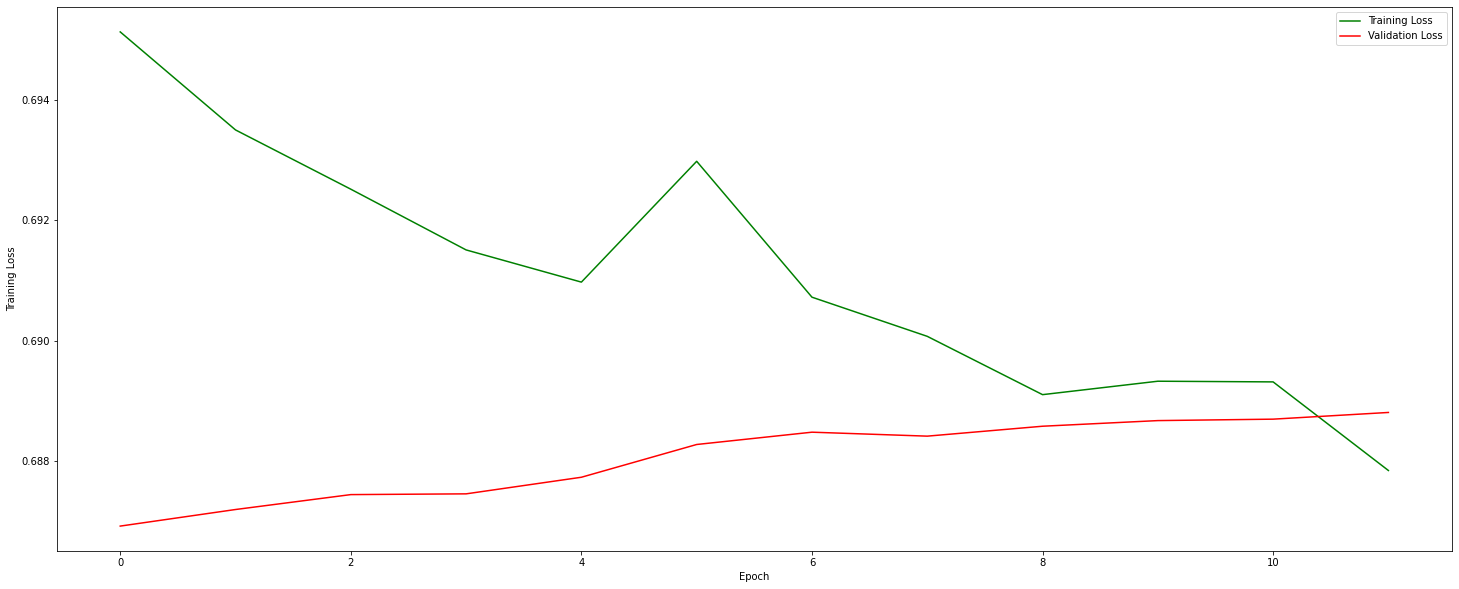

In [158]:
plot_epoch_loss(losses_train[(0.0001,12,32,0.3)])

In [159]:
print_res(metrics_test)

Settings Score_type   Output_type        F1  Precision  \
0  (0.0001, 12, 32, 0.3)    overall  class_scores  0.532710   0.495652   
1  (0.0001, 12, 32, 0.3)   cluster1  class_scores  0.544643   0.488000   
2  (0.0001, 12, 32, 0.3)   cluster2  class_scores  0.519608   0.504762   

     Recall   ROC_AUC  Accuracy  
0  0.575758  0.496222  0.496422  
1  0.616162  0.487437  0.488081  
2  0.535354  0.505051  0.505051

In [259]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001],
                                                                       epochs=[8],
                                                                       batch_sizes=[16],
                                                                       with_attention=True,
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 430
0 : 349
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 202
0 : 195
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.1648 mins



In [260]:
single_task_att_m = model_dict[(0.0001,8,16,0.1)]

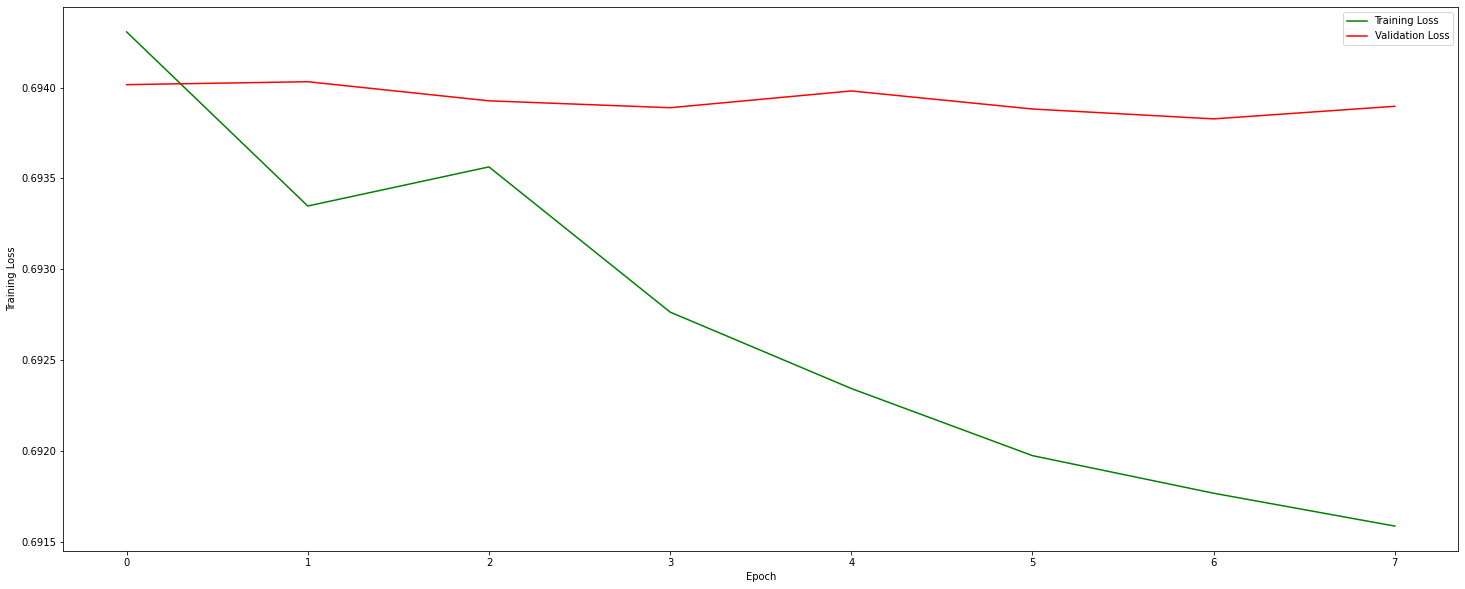

In [261]:
plot_epoch_loss(losses_train[(0.0001,8,16,0.1)])

In [262]:
print_res(metrics_test)

Settings Score_type   Output_type        F1  Precision  \
0  (0.0001, 8, 16, 0.1)    overall  class_scores  0.536497   0.536558   
1  (0.0001, 8, 16, 0.1)   cluster1  class_scores  0.557778   0.557840   
2  (0.0001, 8, 16, 0.1)   cluster2  class_scores  0.515102   0.515158   

     Recall   ROC_AUC  Accuracy  
0  0.536546  0.536524  0.536546  
1  0.557828  0.557789  0.557828  
2  0.515152  0.515152  0.515152

In [169]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[12],
                                                                       word_pred_loss_weights=[0.6],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/12 [00:00<?, ?it/s]

Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 645
0 : 134
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0140 mins

Y1 Pred Dist : 
1 : 321
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.2549 mins



In [170]:
model_dict.keys()

dict_keys([(0.001, 12, 16, 0.1)])

In [172]:
multi_task_att_m = model_dict[(0.001, 12, 16, 0.1)]

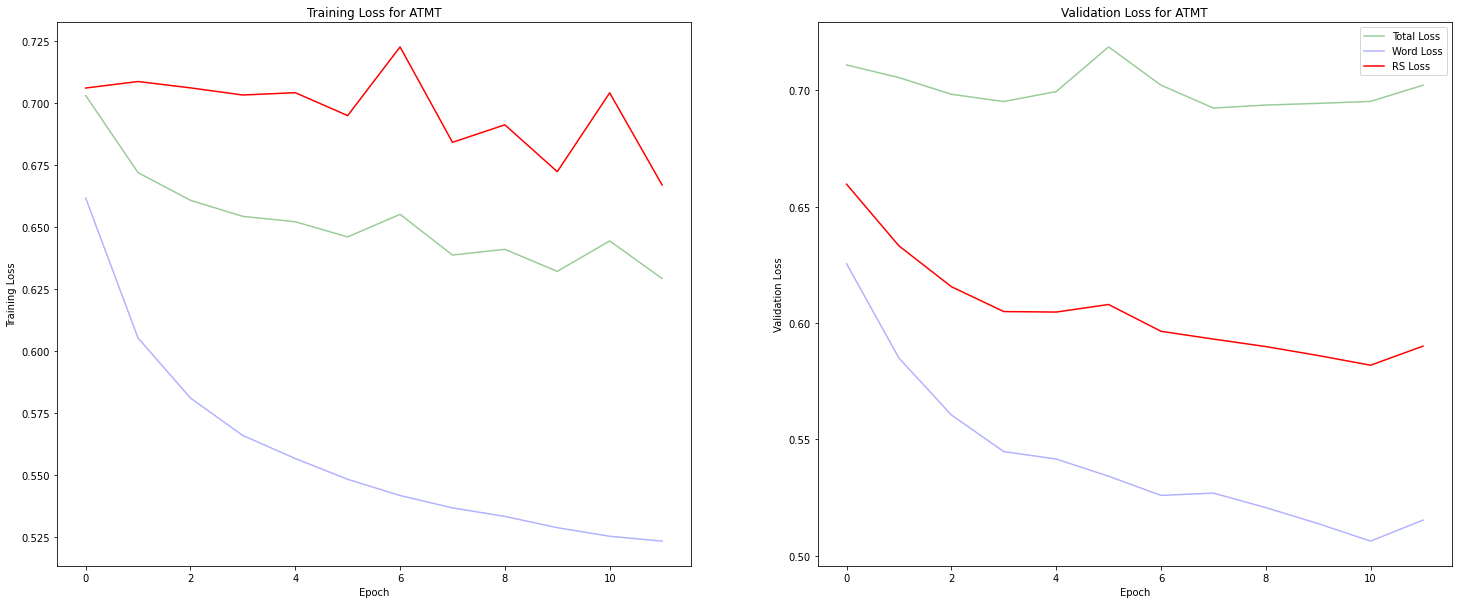

In [173]:
plot_epoch_loss_multi(losses_train[(0.001,12,16,0.1,0.6)])

In [174]:
print_res(metrics_test)

Settings Score_type   Output_type        F1  Precision  \
0  (0.001, 12, 16, 0.1, 0.6)    overall  class_scores  0.631985   0.510903   
2  (0.001, 12, 16, 0.1, 0.6)   cluster1  class_scores  0.630769   0.509317   
4  (0.001, 12, 16, 0.1, 0.6)   cluster2  class_scores  0.633205   0.512500   

     Recall   ROC_AUC  Accuracy  
0  0.828283  0.518892  0.519669  
2  0.828283  0.517588  0.519141  
4  0.828283  0.520202  0.520202

## Attention Check

In [12]:
def get_test_vocab(test):
    """
    """
    tokenizer = load_tokenizer()
    tokens_vocab = Counter()
    for text in test:
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"]
        tokens = tokenizer.covert_ids_to_tokens(token_tensors)
        tokens_vocab.update(tokens)
    return tokens_vocab.keys()
        
def get_attention_weights(model,test,single=True):
    """
    """
    # RUn throught the test set and get corresponding attentions scores for words in our test vocabulary
    # aggregate and return
    tokenizer = load_tokenizer()
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    
    cw_embed_val = get_bert_embeddings(test,bmodel,tokenizer)
    
    if single:
        test = CPDatasetST(test)
    
    if not single:
        test = CPDatasetMT(test,cw_embed_val)
    
    test_dataloader = DataLoader(test,batch_size=1,num_workers=1, shuffle=True)
    tokenizer = load_tokenizer()
    
    attention_weights = defaultdict(list)
    
    model.eval()
    
    with torch.no_grad():
        for batch_num, data in enumerate(test_dataloader):

            if single:
                x1 = data[0]
                y1 = data[1]
                t1 = data[2]
                wc = data[3]


            if not single:
                x1 = data[0]
                x2 = data[1]
                y1 = data[2]
                t1 = data[3]
                wc = data[4]
            
            tokens = tokenizer.encode(t1[0], add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            token_ids = tokenizer.convert_ids_to_tokens(tokens.flatten())

            x1 = x1.to(torch.device('cuda:1'))

            if single:
                y_pred = model(x1)

            if not single:
                y_pred, context_pred = model(x1,None)

            att_w = model.normalized_word_weights.cpu().numpy()

            for i in range(350):

                attention_weights[token_ids[i]].append(att_w[i])
    
    return attention_weights

def aggregate_attW(attw):
    """
    """
    agg_att_w = {}
    for token in attw.keys():
        agg_att_w[token] = np.mean(attw[token])
    
    return agg_att_w

def rank_weights(attw):
    """
    """
    sortedattw = sorted(attw.items(),key=lambda x:x[1],reverse=True)
    token_ranks = {}
    for rank, token_tuple in enumerate(sortedattw):
        token_ranks[token_tuple[0]] = rank
    
    return token_ranks
    

def calc_change_in_rank(testwa1,testwa2):
    """
    iterate through words in vocab and check difference in ranks
    """
    agg_aw1 = aggregate_attW(testwa1)
    agg_aw2 = aggregate_attW(testwa2)
    
    aw1_ranks = rank_weights(agg_aw1)
    aw2_ranks = rank_weights(agg_aw2)
    
    assert len(aw1_ranks.keys()) == len(aw2_ranks.keys())
    
    change_in_rank = {}
    for token in aw1_ranks.keys():
        change_in_rank[token] = aw1_ranks[token] - aw2_ranks[token]
    
    return change_in_rank


In [177]:
train,test,val = split_data(cluster_pair=(220,173),cluster_2_doc_map=doc_2_cluster_map,df=rel_df)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


In [178]:
train = train[train.doc_indices <= 99402 ]
test = test[test.doc_indices <= 99402 ]
val = val[val.doc_indices <= 99402 ]

In [263]:
single_t_att_w =  get_attention_weights(single_task_att_m,test,single=True)

100%|██████████| 397/397 [00:02<00:00, 135.66it/s]


In [264]:
len(single_t_att_w.keys())

9207

In [265]:
len(single_t_att_w["[CLS]"])

397

In [218]:
multi_att_w = get_attention_weights(multi_task_att_m,test,single=False)

100%|██████████| 397/397 [00:02<00:00, 136.72it/s]


In [219]:
len(multi_att_w.keys())

9207

In [220]:
len(multi_att_w["[CLS]"])

397

In [299]:
rank_changes = calc_change_in_rank(single_t_att_w,multi_att_w)

In [300]:
rank_changes_list = list(rank_changes.items())

## Top Attention Weights Single Task

In [301]:
single_t_att_w_agg = aggregate_attW(single_t_att_w)

In [302]:
ranks = sorted(list(single_t_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]

In [303]:
print(ranks)

[('visible', 0.008742467), ('shouldered', 0.00783054), ('tighter', 0.0074774115), ('bulgarian', 0.0071010753), ('prefer', 0.0070933523), ('whistling', 0.0068607153), ('rides', 0.006621324), ('stacey', 0.006617042), ('northward', 0.0064484314), ('horrible', 0.0063214195), ('subordinate', 0.006244776), ('##rgeon', 0.0061712605), ('affecting', 0.006132195), ('ounce', 0.006083756), ('dim', 0.006078904), ('23', 0.0059510055), ('flavor', 0.0059125973), ('nowhere', 0.0058388696), ('##agger', 0.0058267387), ('min', 0.0058179325), ('ride', 0.0058140457), ('coughing', 0.0058088), ('exhibits', 0.0057873144), ('mercy', 0.0057870047), ('drum', 0.0057868087)]


## Top Attention Weights Multi Task

In [304]:
multi_att_w_agg = aggregate_attW(multi_att_w)

In [305]:
ranks = sorted(list(multi_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]

In [306]:
print(ranks)

[('mainly', 0.2289909), ('cave', 0.19626273), ('##eg', 0.12193539), ('olympia', 0.0788926), ('casualties', 0.067569196), ('rotation', 0.060067974), ('testify', 0.036080007), ('price', 0.033805784), ('settle', 0.033466365), ('##nds', 0.032529738), ('##leen', 0.031365406), ('strongly', 0.027875667), ('prayers', 0.027593013), ('mention', 0.026004944), ('risky', 0.025978157), ('##za', 0.022125179), ('##metric', 0.022041688), ('locations', 0.020374818), ('proportion', 0.019904548), ('acquire', 0.019758273), ('passengers', 0.01962379), ('##tee', 0.019446388), ('bot', 0.01933808), ('furious', 0.018777391), ('decrees', 0.017739514)]


## Rank Increase

In [307]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=True)[:20]

[('##ret', 9102),
 ('rotation', 9087),
 ('##lifting', 9057),
 ('bottled', 9036),
 ('olympia', 8991),
 ('winkler', 8964),
 ('ghost', 8953),
 ('crafts', 8909),
 ('patriot', 8901),
 ('sharp', 8900),
 ('statutes', 8892),
 ('viewing', 8886),
 ('##mar', 8879),
 ('acute', 8866),
 ('matt', 8851),
 ('anthropology', 8851),
 ('evaluate', 8848),
 ('italian', 8833),
 ('crosses', 8830),
 ('##rit', 8809)]

## Rank Decrease

In [308]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=False)[:20]

[('194', -9131),
 ('sanchez', -9127),
 ('bulgarian', -9113),
 ('begging', -9112),
 ('tonight', -9108),
 ('deeper', -9104),
 ('subjects', -9098),
 ('contentious', -9079),
 ('bracing', -9066),
 ('iv', -9066),
 ('tennis', -9057),
 ('23', -9055),
 ('##unciation', -9037),
 ('laundry', -9027),
 ('hesitate', -9013),
 ('350', -9007),
 ('coughing', -9006),
 ('##naire', -9000),
 ('reluctant', -8994),
 ('instruments', -8993)]

## Specific Words

In [309]:
rank_changes["passengers"]

6266

In [310]:
rank_changes["inmates"]

-6325

In [311]:
rank_changes["gun"]

1180

In [312]:
rank_changes["wall"]

993

In [313]:
rank_changes["democrat"]

777

In [314]:
rank_changes["republican"]

-144

In [315]:
rank_changes["immigrant"]

3588

In [316]:
rank_changes["trump"]

697

In [317]:
rank_changes["border"]

1570

In [318]:
rank_changes["trafficking"]

2160

## Word Loss Weight Comparison

In [249]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[12],
                                                                       word_pred_loss_weights=[0.1,0.2,0.4,0.6,0.8,0.9],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/12 [00:00<?, ?it/s]

Number of param combinations : 6
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 504
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 273
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2710 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 397
0 : 382
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 197
0 : 200
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2692 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.26s/it]


Y1 Pred Dist : 
1 : 570
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0141 mins

Y1 Pred Dist : 
1 : 297
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.2767 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 747
0 : 32
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 379
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2696 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


Y1 Pred Dist : 
1 : 17
0 : 762
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0146 mins

Y1 Pred Dist : 
1 : 5
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.2800 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 617
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 330
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0085 mins


Finished running 'run_ssda_MT' in 0.2741 mins



In [251]:
model_dict.keys()

dict_keys([(0.001, 12, 16, 0.1)])

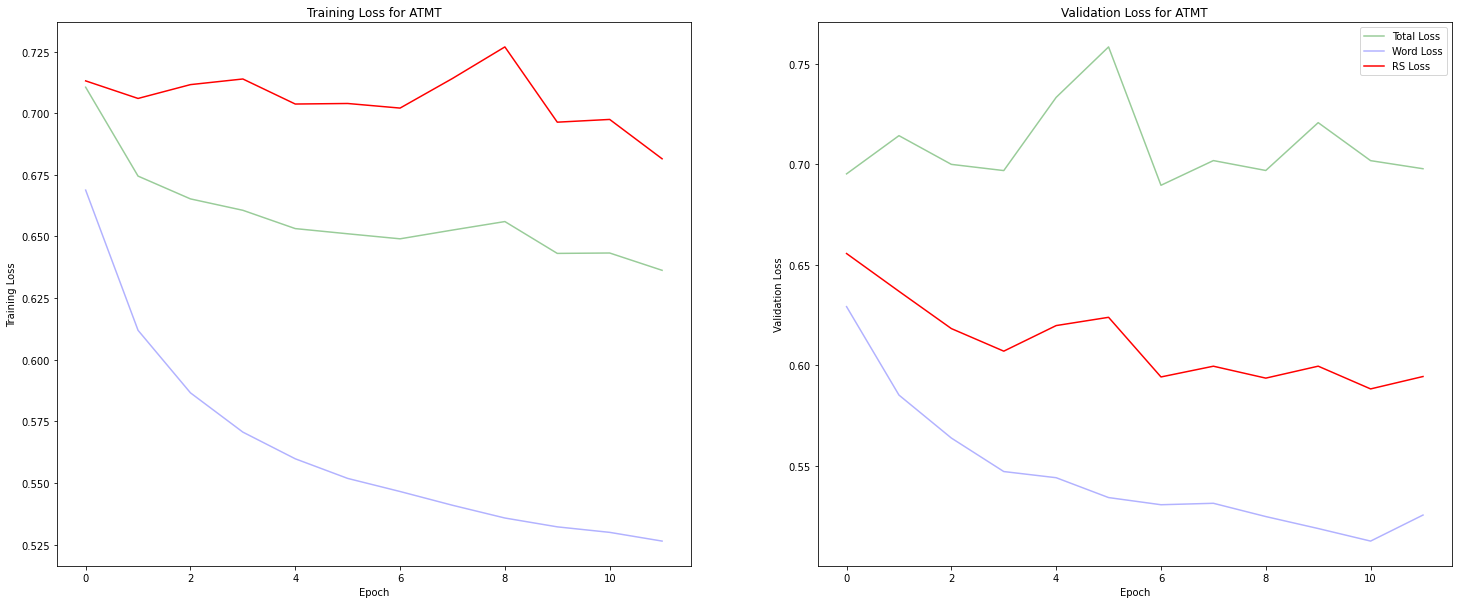

In [253]:
plot_epoch_loss_multi(losses_train[(0.001,12,16,0.1,0.6)])

In [252]:
print_res(metrics_test)

Settings Score_type   Output_type        F1  Precision  \
0   (0.001, 12, 16, 0.1, 0.1)    overall  class_scores  0.602972   0.520147   
2   (0.001, 12, 16, 0.1, 0.1)   cluster1  class_scores  0.652361   0.567164   
4   (0.001, 12, 16, 0.1, 0.1)   cluster2  class_scores  0.554622   0.474820   
6   (0.001, 12, 16, 0.1, 0.2)    overall  class_scores  0.496203   0.497462   
8   (0.001, 12, 16, 0.1, 0.2)   cluster1  class_scores  0.533333   0.541667   
10  (0.001, 12, 16, 0.1, 0.2)   cluster2  class_scores  0.460000   0.455446   
12  (0.001, 12, 16, 0.1, 0.4)    overall  class_scores  0.602020   0.501684   
14  (0.001, 12, 16, 0.1, 0.4)   cluster1  class_scores  0.634538   0.526667   
16  (0.001, 12, 16, 0.1, 0.4)   cluster2  class_scores  0.569106   0.476190   
18  (0.001, 12, 16, 0.1, 0.6)    overall  class_scores  0.672444   0.511873   
20  (0.001, 12, 16, 0.1, 0.6)   cluster1  class_scores  0.678082   0.512953   
22  (0.001, 12, 16, 0.1, 0.6)   cluster2  class_scores  0.666667   0.510753   
24  (0.001, 12, 16, 0.1, 0.8)    overall  class_scores  0.029557   0.600000   
26  (0.001, 12, 16, 0.1, 0.8)   cluster1  class_scores  0.019608   0.333333   
28  (0.001, 12, 16, 0.1, 0.8)   cluster2  class_scores  0.039604   1.000000   
30  (0.001, 12, 16, 0.1, 0.9)    overall  class_scores  0.602273   0.481818   
32  (0.001, 12, 16, 0.1, 0.9)   cluster1  class_scores  0.593750   0.484076   
34  (0.001, 12, 16, 0.1, 0.9)   cluster2  class_scores  0.610294   0.479769   

      Recall   ROC_AUC  Accuracy  
0   0.717172  0.528967  0.529440  
2   0.767677  0.592965  0.593838  
4   0.666667  0.464646  0.464646  
6   0.494949  0.498741  0.498731  
8   0.525253  0.542714  0.542626  
10  0.464646  0.454545  0.454545  
12  0.752525  0.503778  0.504403  
14  0.797980  0.542714  0.543990  
16  0.707071  0.464646  0.464646  
18  0.979798  0.523929  0.525075  
20  1.000000  0.527638  0.530000  
22  0.959596  0.520202  0.520202  
24  0.015152  0.503778  0.502551  
26  0.010101  0.497487  0.495051  
28  0.020202  0.510101  0.510101  
30  0.803030  0.471033  0.471867  
32  0.767677  0.477387  0.478838  
34  0.838384  0.464646  0.464646

# Macro Based Metric Measures

In [257]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[12],
                                                                       word_pred_loss_weights=[0.1,0.2,0.4,0.6,0.8,0.9],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/12 [00:00<?, ?it/s]

Number of param combinations : 6
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Y1 Pred Dist : 
1 : 423
0 : 356
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 218
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2840 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.26s/it]


Y1 Pred Dist : 
1 : 426
0 : 353
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0141 mins

Y1 Pred Dist : 
1 : 217
0 : 180
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.2774 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 160
0 : 619
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 66
0 : 331
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.2881 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 168
0 : 611
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 76
0 : 321
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2727 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 94
0 : 685
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 39
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2724 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 763
0 : 16
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0143 mins

Y1 Pred Dist : 
1 : 393
0 : 4
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0087 mins


Finished running 'run_ssda_MT' in 0.2745 mins



In [258]:
print_res(metrics_test)

Settings Score_type   Output_type        F1  Precision  \
0   (0.001, 12, 16, 0.1, 0.1)    overall  class_scores  0.479917   0.481049   
2   (0.001, 12, 16, 0.1, 0.1)   cluster1  class_scores  0.479838   0.482405   
4   (0.001, 12, 16, 0.1, 0.1)   cluster2  class_scores  0.479466   0.479746   
6   (0.001, 12, 16, 0.1, 0.2)    overall  class_scores  0.548190   0.549667   
8   (0.001, 12, 16, 0.1, 0.2)   cluster1  class_scores  0.582239   0.583740   
10  (0.001, 12, 16, 0.1, 0.2)   cluster2  class_scores  0.513912   0.515308   
12  (0.001, 12, 16, 0.1, 0.4)    overall  class_scores  0.443882   0.509842   
14  (0.001, 12, 16, 0.1, 0.4)   cluster1  class_scores  0.433911   0.484577   
16  (0.001, 12, 16, 0.1, 0.4)   cluster2  class_scores  0.453880   0.539286   
18  (0.001, 12, 16, 0.1, 0.6)    overall  class_scores  0.442729   0.492642   
20  (0.001, 12, 16, 0.1, 0.6)   cluster1  class_scores  0.463820   0.517217   
22  (0.001, 12, 16, 0.1, 0.6)   cluster2  class_scores  0.421201   0.466049   
24  (0.001, 12, 16, 0.1, 0.8)    overall  class_scores  0.407548   0.507807   
26  (0.001, 12, 16, 0.1, 0.8)   cluster1  class_scores  0.430589   0.556983   
28  (0.001, 12, 16, 0.1, 0.8)   cluster2  class_scores  0.384343   0.456336   
30  (0.001, 12, 16, 0.1, 0.9)    overall  class_scores  0.341494   0.499364   
32  (0.001, 12, 16, 0.1, 0.9)   cluster1  class_scores  0.343234   0.750000   
34  (0.001, 12, 16, 0.1, 0.9)   cluster2  class_scores  0.339736   0.415385   

      Recall   ROC_AUC  Accuracy  
0   0.481232  0.481108  0.481232  
2   0.482778  0.482412  0.482778  
4   0.479798  0.479798  0.479798  
6   0.549236  0.549118  0.549236  
8   0.583131  0.582915  0.583131  
10  0.515152  0.515152  0.515152  
12  0.505457  0.506297  0.505457  
14  0.490859  0.492462  0.490859  
16  0.520202  0.520202  0.520202  
18  0.495444  0.496222  0.495444  
20  0.511061  0.512563  0.511061  
22  0.479798  0.479798  0.479798  
24  0.502766  0.503778  0.502766  
26  0.520606  0.522613  0.520606  
28  0.484848  0.484848  0.484848  
30  0.499975  0.498741  0.499975  
32  0.505000  0.502513  0.505000  
34  0.494949  0.494949  0.494949

# May 23rd 

# ReClustering
* Reclustered so that we can get better cluster topics , used k = 50
* Below are list of few clusters with corresponding topics they talk about

* 95 - Immigration/ Border Wall
* 62 - Supreme court related issues
* 45 - Trump related + Trump Impeachment
* 72 - Taliban Related
* 54 - Trump Impeachment
* 99 - Welfare + stimulus checks
* 3 - Racism
* 85 - Trump Impeachment - Ukraine Related
* 70 - US Elections
* 30 - US Military

Extremely Similar Clusters
* 45, 54, 85 - Trump Impeachment
* 30, 72 - US Military

In [17]:
top_10_sim_cps = load_pickle("current_pickle_obs/top10cp.pickle")
doc_2_cluster_map = load_pickle("current_pickle_obs/doc_2_cluster_k_100.pkl")
rel_df = load_pickle("current_pickle_obs/rel_df_with_wp.pickle")

In [18]:
rel_df["doc_indices"] = rel_df.index

## 1. Checking Seeds

In [20]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001],
                                                                       epochs=[3],
                                                                       batch_sizes=[8],
                                                                       dropouts=[0.3],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 3
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


Y1 Pred Dist : 
1 : 81
0 : 1085
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0187 mins

Y1 Pred Dist : 
1 : 19
0 : 251
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0069 mins

Y1 Pred Dist : 
1 : 26
0 : 332
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0731 mins


Finished running 'run_ssda_ST' in 0.3404 mins



In [21]:
print_res(metrics_val)

Settings Score_type   Output_type        F1  Precision    Recall  \
0  (0.001, 3, 8, 0.3)    overall  class_scores  0.091503   0.368421  0.052239   
1  (0.001, 3, 8, 0.3)   cluster1  class_scores  0.100000   0.368421  0.057851   
2  (0.001, 3, 8, 0.3)   cluster2  class_scores  0.000000   0.000000  0.000000   

    ROC_AUC  Accuracy  
0  0.485185  0.482002  
1  0.481481  0.479745  
2  0.518519  0.500000

In [22]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001],
                                                                       epochs=[3],
                                                                       batch_sizes=[8],
                                                                       dropouts=[0.3],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 3
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 81
0 : 1085
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 19
0 : 251
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0063 mins

Y1 Pred Dist : 
1 : 26
0 : 332
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0629 mins


Finished running 'run_ssda_ST' in 0.1612 mins



In [23]:
print_res(metrics_val)

Settings Score_type   Output_type        F1  Precision    Recall  \
0  (0.001, 3, 8, 0.3)    overall  class_scores  0.091503   0.368421  0.052239   
1  (0.001, 3, 8, 0.3)   cluster1  class_scores  0.100000   0.368421  0.057851   
2  (0.001, 3, 8, 0.3)   cluster2  class_scores  0.000000   0.000000  0.000000   

    ROC_AUC  Accuracy  
0  0.485185  0.482002  
1  0.481481  0.479745  
2  0.518519  0.500000

## Finally Seeding Works , reproducible results now

## 2. Attention Weight Check

In [24]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001],
                                                                       epochs=[10],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.3],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 787
0 : 379
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 191
0 : 79
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins

Y1 Pred Dist : 
1 : 232
0 : 126
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.2652 mins



In [25]:
print_res(metrics_val)

Settings Score_type   Output_type        F1  Precision  \
0  (0.001, 10, 16, 0.3)    overall  class_scores  0.633846   0.539267   
1  (0.001, 10, 16, 0.3)   cluster1  class_scores  0.646048   0.552941   
2  (0.001, 10, 16, 0.3)   cluster2  class_scores  0.529412   0.428571   

     Recall   ROC_AUC  Accuracy  
0  0.768657  0.559259  0.560799  
1  0.776860  0.576132  0.576954  
2  0.692308  0.407407  0.417582

In [26]:
m = model_dict[(0.001, 10, 16, 0.3)]
m.normalized_word_weights

tensor([1.6770e-03, 4.4998e-03, 8.5204e-04, 6.3079e-05, 5.8313e-04, 2.9265e-03,
        1.4019e-03, 4.0562e-04, 5.0344e-03, 6.1272e-03, 1.5717e-02, 1.0791e-03,
        4.1431e-04, 2.7192e-04, 3.8006e-03, 3.1028e-03, 1.0601e-03, 9.4633e-03,
        2.7261e-03, 1.4356e-03, 3.5054e-04, 4.5888e-03, 7.9181e-03, 1.7039e-02,
        4.3233e-03, 6.2452e-04, 4.1268e-04, 8.5471e-04, 6.3719e-04, 6.6579e-03,
        2.6491e-04, 9.5944e-04, 5.5417e-04, 3.9135e-04, 1.4048e-03, 1.3609e-03,
        8.4173e-04, 5.3556e-05, 2.6092e-04, 1.5242e-03, 2.0469e-04, 3.3762e-04,
        1.5293e-03, 4.7408e-04, 2.2347e-04, 6.3486e-03, 5.2096e-03, 3.2662e-03,
        4.7299e-03, 1.5493e-02, 7.4342e-04, 6.5094e-04, 3.4369e-04, 4.8899e-03,
        2.6381e-03, 5.9900e-03, 2.0046e-03, 2.5732e-04, 1.0928e-04, 2.3525e-04,
        9.8876e-04, 8.1001e-04, 6.7720e-04, 4.3889e-05, 2.3363e-04, 9.9304e-04,
        2.5719e-04, 1.3368e-04, 1.6760e-04, 3.6488e-04, 6.6892e-05, 2.1409e-03,
        1.0363e-03, 3.3822e-04, 1.6273e-

## Weights for the Single Task Model seem to look Fine

## 3. Cluster 1 vs Cluster 2 Accuracy

In [13]:
def plot_clus1_vs_clus2_acc(epoch_scores,ss=100):
    """
    """
    c1_f1s = []
    c2_f1s =[]
    c1_p =[]
    c2_p =[]
    c1_r =[]
    c2_r =[]
    c1_acc =[]
    c2_acc = []
    for param,hyper_setting_df in print_res(epoch_scores).groupby("Settings"):
        c1_score = hyper_setting_df.loc[hyper_setting_df.Score_type == "cluster1"]
        c2_score = hyper_setting_df.loc[hyper_setting_df.Score_type == "cluster2"]
        
        assert c1_score.shape[0] == 1
        assert c2_score.shape[0] == 1
        
        c1_f1s.append(c1_score["F1"].tolist()[0])
        c1_p.append(c1_score["Precision"].tolist()[0])
        c1_r.append(c1_score["Recall"].tolist()[0])
        c1_acc.append(c1_score["Accuracy"].tolist()[0])
        
        c2_f1s.append(c2_score["F1"].tolist()[0])
        c2_p.append(c2_score["Precision"].tolist()[0])
        c2_r.append(c2_score["Recall"].tolist()[0])
        c2_acc.append(c2_score["Accuracy"].tolist()[0])
    
    
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,15))
    axes = ax.ravel()
    
    axes[0].scatter(c1_f1s,c2_f1s,c="blue",alpha=0.8,s=ss,label="F1 - Scores")
    axes[0].plot([0, 1], [0, 1],c="red",alpha=0.8,linestyle='dashed',linewidth=3, transform=axes[0].transAxes)
    axes[0].set_xlim([0,1])
    axes[0].set_ylim([0,1])
    axes[0].set_xlabel("C1-Score")
    axes[0].set_ylabel("C2-Score")
    axes[0].set_title("F1 Comparison")
    
    axes[1].scatter(c1_p,c2_p,c="blue",alpha=0.8,s=ss,label="Precision")
    axes[1].plot([0, 1], [0, 1],c="red",alpha=0.8,linestyle='dashed',linewidth=3, transform=axes[1].transAxes)
    axes[1].set_xlim([0,1])
    axes[1].set_ylim([0,1])
    axes[1].set_xlabel("C1-Score")
    axes[1].set_ylabel("C2-Score")
    axes[1].set_title("Precision Comparison")
    
    axes[2].scatter(c1_r,c2_r,c="blue",alpha=0.8,s=ss,label="Recall")
    axes[2].plot([0, 1], [0, 1],c="red",alpha=0.8,linestyle='dashed',linewidth=3, transform=axes[2].transAxes)
    axes[2].set_xlim([0,1])
    axes[2].set_ylim([0,1])
    axes[2].set_xlabel("C1-Score")
    axes[2].set_ylabel("C2-Score")
    axes[2].set_title("Recall Comparison")
    
    axes[3].scatter(c1_acc,c2_acc,c="blue",alpha=0.8,s=ss,label="Accuracy")
    axes[3].plot([0, 1], [0, 1],c="red",alpha=0.8, linestyle='dashed',linewidth=3,transform=axes[3].transAxes)
    axes[3].set_xlim([0,1])
    axes[3].set_ylim([0,1])
    axes[3].set_xlabel("C1-Score")
    axes[3].set_ylabel("C2-Score")
    axes[3].set_title("Accuracy Comparison")
    
    fig.suptitle("Pairwise Score Comparison")
    plt.tight_layout()
    plt.show()

In [49]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10],
                                                                       batch_sizes=[16,32],
                                                                       dropouts=[0.1,0.3],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 24
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Y1 Pred Dist : 
1 : 8
0 : 1158
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 4
0 : 266
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0067 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 356
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0556 mins


Finished running 'run_ssda_ST' in 0.2656 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 20
0 : 1146
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0179 mins

Y1 Pred Dist : 
1 : 5
0 : 265
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0059 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 350
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1533 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 292
0 : 874
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 73
0 : 197
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 84
0 : 274
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1481 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 277
0 : 889
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 71
0 : 199
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 81
0 : 277
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0074 mins


Finished running 'run_ssda_ST' in 0.1462 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 683
0 : 483
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0177 mins

Y1 Pred Dist : 
1 : 161
0 : 109
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 206
0 : 152
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2652 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 787
0 : 379
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 191
0 : 79
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 232
0 : 126
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2577 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 510
0 : 656
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 130
0 : 140
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 158
0 : 200
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2638 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 699
0 : 467
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0168 mins

Y1 Pred Dist : 
1 : 175
0 : 95
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins

Y1 Pred Dist : 
1 : 214
0 : 144
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2579 mins

Param_setting : 8
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 685
0 : 481
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0181 mins

Y1 Pred Dist : 
1 : 162
0 : 108
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0066 mins

Y1 Pred Dist : 
1 : 204
0 : 154
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1492 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.3



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 691
0 : 475
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 163
0 : 107
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins

Y1 Pred Dist : 
1 : 204
0 : 154
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1472 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 749
0 : 417
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0165 mins

Y1 Pred Dist : 
1 : 175
0 : 95
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 216
0 : 142
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1425 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 749
0 : 417
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0162 mins

Y1 Pred Dist : 
1 : 176
0 : 94
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 217
0 : 141
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.1415 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 261
0 : 905
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 63
0 : 207
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 87
0 : 271
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2564 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 252
0 : 914
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0177 mins

Y1 Pred Dist : 
1 : 61
0 : 209
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0064 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 87
0 : 271
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2591 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 484
0 : 682
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 114
0 : 156
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins

Y1 Pred Dist : 
1 : 155
0 : 203
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2629 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.3



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 492
0 : 674
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0165 mins

Y1 Pred Dist : 
1 : 116
0 : 154
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 155
0 : 203
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2658 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 675
0 : 491
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 141
0 : 129
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 150
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.1476 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 684
0 : 482
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 151
0 : 119
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 205
0 : 153
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.1475 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 494
0 : 672
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 109
0 : 161
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0064 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 147
0 : 211
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.1463 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 402
0 : 764
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 91
0 : 179
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 105
0 : 253
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1510 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 563
0 : 603
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 108
0 : 162
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 161
0 : 197
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2643 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 589
0 : 577
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 121
0 : 149
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 176
0 : 182
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.2638 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 647
0 : 519
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0166 mins

Y1 Pred Dist : 
1 : 154
0 : 116
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 217
0 : 141
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2568 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 694
0 : 472
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0166 mins

Y1 Pred Dist : 
1 : 171
0 : 99
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins

Y1 Pred Dist : 
1 : 219
0 : 139
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2587 mins



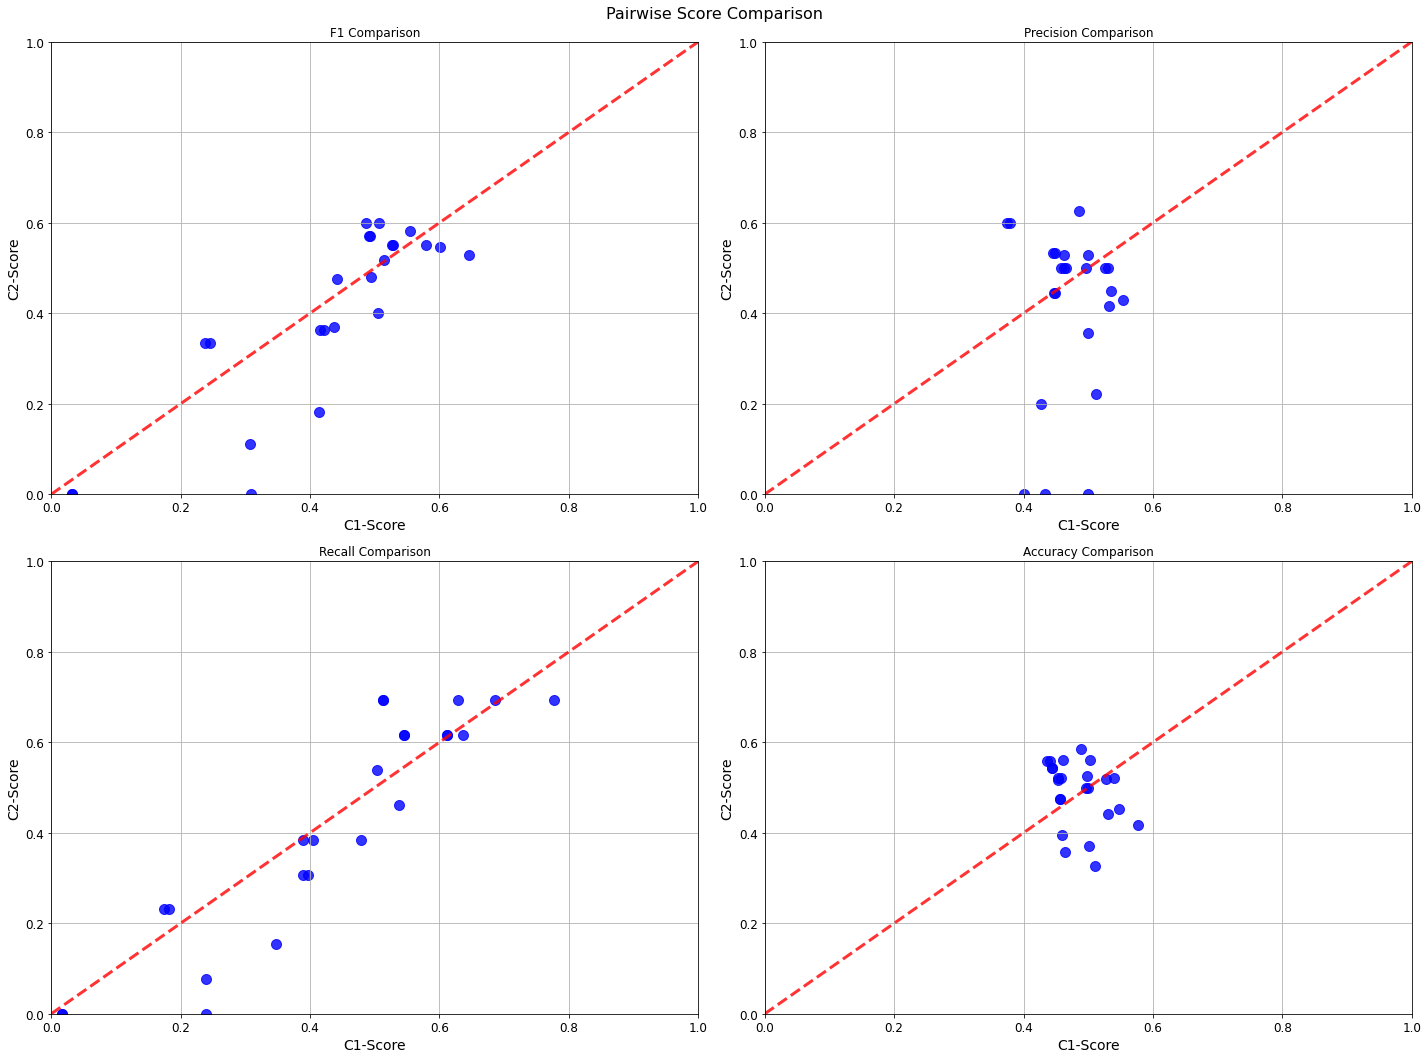

In [67]:
plot_clus1_vs_clus2_acc(metrics_val)

## 4. Increase Heterogeniety in Train 

* Train : Should have a large mix of multiple clusters with homo pref but 5% of hetero pref in c2

In [69]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99,3],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10],
                                                                       batch_sizes=[16,32],
                                                                       dropouts=[0.1,0.3],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 216.64499999999998
Percentage of Val size for c in c1mix : 49.995000000000005
Percentage of test size for c in c1mix : 37.03333333333334

Sampled Data Sizes: 
Train Size : (720, 16)
1 : 360
0 : 360
Test Size : (222, 16)
1 : 109
0 : 113
Val Size : (163, 16)
1 : 83
0 : 80
Number of param combinations : 24
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Y1 Pred Dist : 
1 : 500
0 : 217
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 111
0 : 50
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins

Y1 Pred Dist : 
1 : 158
0 : 63
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0279 mins


Finished running 'run_ssda_ST' in 0.2845 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.3



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 570
0 : 147
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 126
0 : 35
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 179
0 : 42
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1071 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 27
0 : 690
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 6
0 : 155
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 10
0 : 211
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1078 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 115
0 : 602
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 26
0 : 135
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins

Y1 Pred Dist : 
1 : 36
0 : 185
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1097 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 363
0 : 354
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 79
0 : 82
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0046 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 120
0 : 101
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0055 mins


Finished running 'run_ssda_ST' in 0.1798 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 314
0 : 403
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 71
0 : 90
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0047 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 107
0 : 114
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1810 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 429
0 : 288
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0108 mins

Y1 Pred Dist : 
1 : 90
0 : 71
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0044 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 138
0 : 83
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0054 mins


Finished running 'run_ssda_ST' in 0.1777 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 444
0 : 273
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0110 mins

Y1 Pred Dist : 
1 : 94
0 : 67
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0045 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 144
0 : 77
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0054 mins


Finished running 'run_ssda_ST' in 0.1764 mins

Param_setting : 8
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 223
0 : 494
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 49
0 : 112
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0046 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 73
0 : 148
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0054 mins


Finished running 'run_ssda_ST' in 0.1001 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 224
0 : 493
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 49
0 : 112
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0047 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 72
0 : 149
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1033 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 247
0 : 470
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 55
0 : 106
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0048 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 74
0 : 147
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1032 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 251
0 : 466
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 55
0 : 106
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 74
0 : 147
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1049 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Y1 Pred Dist : 
1 : 401
0 : 316
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 90
0 : 71
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0047 mins

Y1 Pred Dist : 
1 : 122
0 : 99
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0468 mins


Finished running 'run_ssda_ST' in 0.3591 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [01:43<00:00, 10.35s/it]


Y1 Pred Dist : 
1 : 377
0 : 340
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.1047 mins

Y1 Pred Dist : 
1 : 85
0 : 76
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0358 mins

Y1 Pred Dist : 
1 : 115
0 : 106
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0444 mins


Finished running 'run_ssda_ST' in 1.9124 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Y1 Pred Dist : 
1 : 372
0 : 345
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 81
0 : 80
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 110
0 : 111
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0479 mins


Finished running 'run_ssda_ST' in 0.4424 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.3



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 368
0 : 349
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 76
0 : 85
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins

Y1 Pred Dist : 
1 : 105
0 : 116
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0301 mins


Finished running 'run_ssda_ST' in 0.2261 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 498
0 : 219
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 126
0 : 35
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins

Y1 Pred Dist : 
1 : 176
0 : 45
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.1118 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 431
0 : 286
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 103
0 : 58
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins

Y1 Pred Dist : 
1 : 146
0 : 75
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1102 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 530
0 : 187
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 123
0 : 38
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins

Y1 Pred Dist : 
1 : 170
0 : 51
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1092 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 606
0 : 111
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 144
0 : 17
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0050 mins

Y1 Pred Dist : 
1 : 198
0 : 23
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1084 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed : 

  0%|          | 0/10 [00:00<?, ?it/s]

 42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 377
0 : 340
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 93
0 : 68
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 119
0 : 102
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1937 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 374
0 : 343
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 92
0 : 69
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 121
0 : 100
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1930 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 382
0 : 335
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 93
0 : 68
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins

Y1 Pred Dist : 
1 : 127
0 : 94
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1906 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 400
0 : 317
Predicted Label Shape : (717,)
True Label Shape : (717,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 91
0 : 70
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins

Y1 Pred Dist : 
1 : 124
0 : 97
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.1913 mins



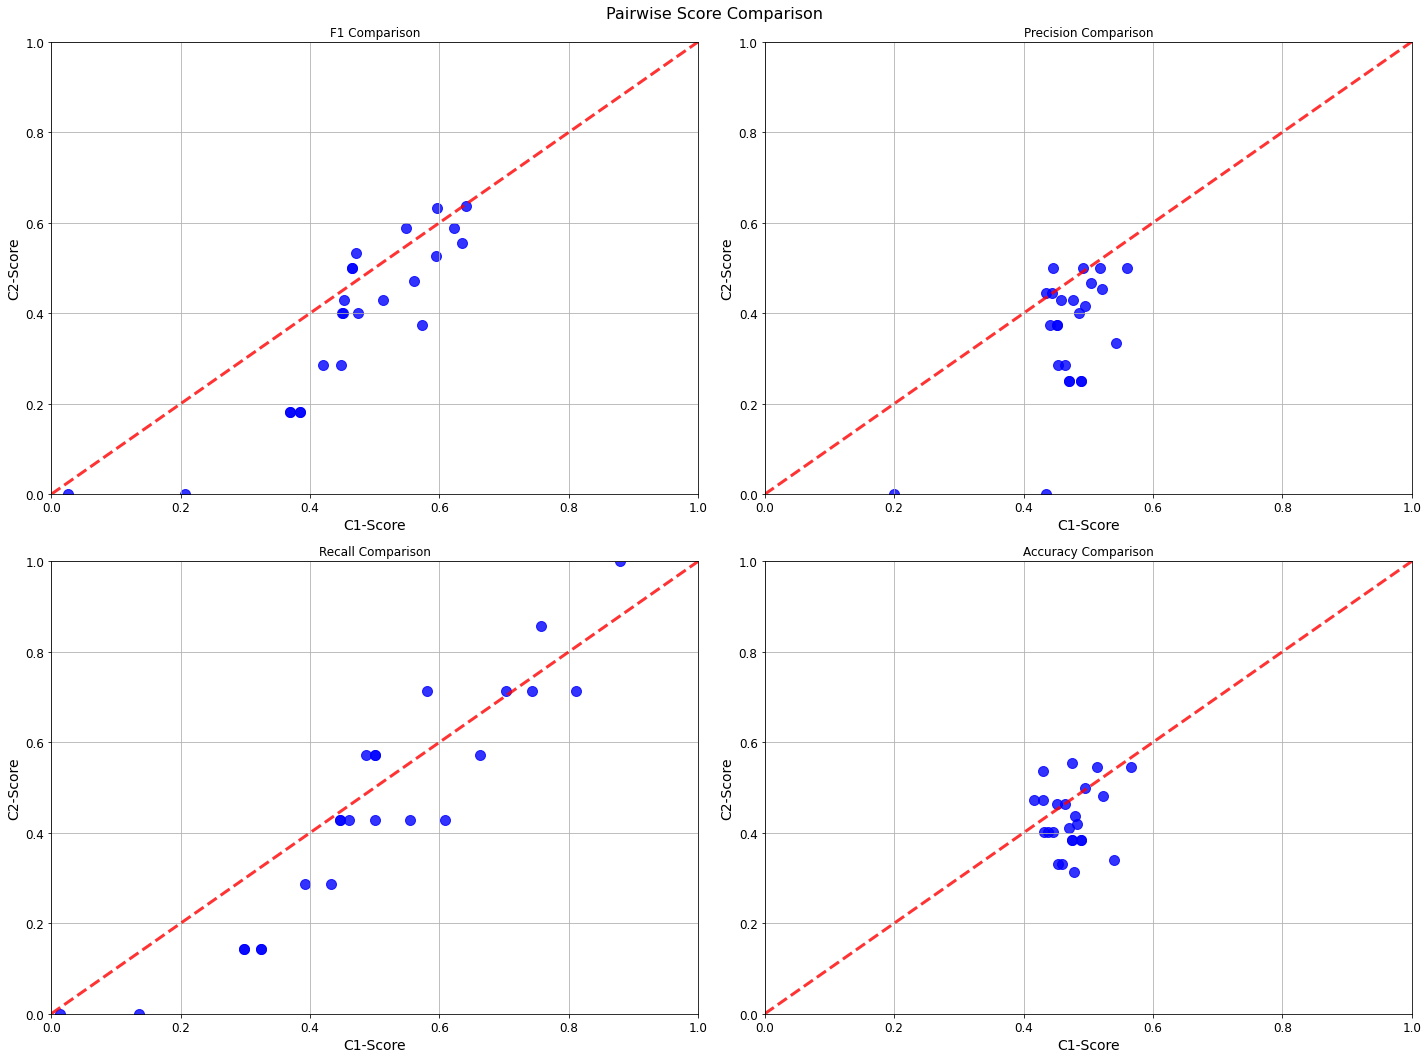

In [70]:
plot_clus1_vs_clus2_acc(metrics_val)

## 5. Attention Rank Check using Different Aggregation

In [14]:
def get_test_vocab(test):
    """
    """
    tokenizer = load_tokenizer()
    tokens_vocab = Counter()
    for text in test:
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"]
        tokens = tokenizer.covert_ids_to_tokens(token_tensors)
        tokens_vocab.update(tokens)
    return tokens_vocab.keys()

def get_count_vec_vocab(test):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=0.15, binary=True, max_df=0.90, stop_words='english',max_features=None)
    tfidf_vectorizer.fit(test)
    
    vocab = tfidf_vectorizer.get_feature_names()
    return vocab
    
        
def get_attention_weights(model,test,single=True):
    """
    """
    # RUn throught the test set and get corresponding attentions scores for words in our test vocabulary
    # aggregate and return
    tokenizer = load_tokenizer()
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    
    cw_embed_val = get_bert_embeddings(test,bmodel,tokenizer)
    
    vocab = get_count_vec_vocab(test["all_text"])
    
    if single:
        test = CPDatasetST(test)
    
    if not single:
        test = CPDatasetMT(test,cw_embed_val)
    
    test_dataloader = DataLoader(test,batch_size=1,num_workers=1, shuffle=True)
    tokenizer = load_tokenizer()
    
    attention_weights = defaultdict(list)
    
    model.eval()
    
    with torch.no_grad():
        for batch_num, data in enumerate(test_dataloader):

            if single:
                x1 = data[0]
                y1 = data[1]
                t1 = data[2]
                wc = data[3]


            if not single:
                x1 = data[0]
                x2 = data[1]
                y1 = data[2]
                t1 = data[3]
                wc = data[4]
            
            tokens = tokenizer.encode(t1[0], add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            token_ids = tokenizer.convert_ids_to_tokens(tokens.flatten())

            x1 = x1.to(torch.device('cuda:1'))

            if single:
                y_pred = model(x1)

            if not single:
                y_pred, context_pred = model(x1,None)

            att_w = model.normalized_word_weights.cpu().numpy()

            for i in range(350):
                
                if token_ids[i] in vocab:

                    attention_weights[token_ids[i]].append(att_w[i])
    
    return attention_weights

def aggregate_attW(attw):
    """
    """
    agg_att_w = {}
    total_sum = []
    for token in attw.keys():
        agg_att_w[token] = np.sum(attw[token],axis=0)
    
    total_sum = sum(agg_att_w.values())
    for token in agg_att_w.keys():
        agg_att_w[token] /= total_sum
    
    return agg_att_w

def rank_weights(attw):
    """
    """
    sortedattw = sorted(attw.items(),key=lambda x:x[1],reverse=True)
    token_ranks = {}
    for rank, token_tuple in enumerate(sortedattw):
        token_ranks[token_tuple[0]] = rank
    
    return token_ranks
    

def calc_change_in_rank(testwa1,testwa2):
    """
    iterate through words in vocab and check difference in ranks
    """
    agg_aw1 = aggregate_attW(testwa1)
    agg_aw2 = aggregate_attW(testwa2)
    
    aw1_ranks = rank_weights(agg_aw1)
    aw2_ranks = rank_weights(agg_aw2)
    
    assert len(aw1_ranks.keys()) == len(aw2_ranks.keys())
    
    change_in_rank = {}
    for token in aw1_ranks.keys():
        change_in_rank[token] = aw1_ranks[token] - aw2_ranks[token]
    
    return change_in_rank


In [15]:
def select_top_settings(scores,metric_type="F1"):
    """
    """
    score_df = print_res(scores)
    
    # Select the setting with best overall F1 and best overall Acc
    
    overall_df = score_df.loc[score_df.Score_type == "overall"]
    overall_df = overall_df.reset_index(drop=True)
    best_setting = overall_df.iloc[overall_df[metric_type].idxmax()].tolist()[0]
    score_df_best = score_df.loc[score_df.Settings == best_setting]
    return score_df_best

# ReClustering
* Reclustered so that we can get better cluster topics , used k = 50
* Below are list of few clusters with corresponding topics they talk about

* 95 - Immigration/ Border Wall
* 62 - Supreme court related issues
* 45 - Trump related + Trump Impeachment
* 72 - Taliban Related
* 54 - Trump Impeachment
* 99 - Welfare + stimulus checks
* 3 - Racism
* 85 - Trump Impeachment - Ukraine Related
* 70 - US Elections
* 30 - US Military

Extremely Similar Clusters
* 45, 54, 85 - Trump Impeachment
* 30, 72 - US Military

# Experiment 1: Basic Settings Comparison using Validation Performance

## Single Task without Attention

In [116]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=False,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 630
0 : 536
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 154
0 : 116
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 206
0 : 152
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.1474 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 15
0 : 1151
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0187 mins

Y1 Pred Dist : 
1 : 5
0 : 265
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0066 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 356
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.1508 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


Y1 Pred Dist : 
1 : 70
0 : 1096
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0166 mins

Y1 Pred Dist : 
1 : 14
0 : 256
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins

Y1 Pred Dist : 
1 : 15
0 : 343
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0718 mins


Finished running 'run_ssda_ST' in 0.4911 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:54<00:00,  5.43s/it]


Y1 Pred Dist : 
1 : 505
0 : 661
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.1908 mins

Y1 Pred Dist : 
1 : 131
0 : 139
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0541 mins

Y1 Pred Dist : 
1 : 154
0 : 204
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0778 mins


Finished running 'run_ssda_ST' in 1.2308 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Y1 Pred Dist : 
1 : 916
0 : 250
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0190 mins

Y1 Pred Dist : 
1 : 220
0 : 50
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0068 mins

Y1 Pred Dist : 
1 : 278
0 : 80
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0755 mins


Finished running 'run_ssda_ST' in 0.8966 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Y1 Pred Dist : 
1 : 485
0 : 681
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0185 mins

Y1 Pred Dist : 
1 : 128
0 : 142
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0069 mins

Y1 Pred Dist : 
1 : 162
0 : 196
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0740 mins


Finished running 'run_ssda_ST' in 0.3747 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


Y1 Pred Dist : 
1 : 834
0 : 332
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0187 mins

Y1 Pred Dist : 
1 : 206
0 : 64
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0064 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 265
0 : 93
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0259 mins


Finished running 'run_ssda_ST' in 0.4418 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Y1 Pred Dist : 
1 : 771
0 : 395
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0205 mins

Y1 Pred Dist : 
1 : 199
0 : 71
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0069 mins

Y1 Pred Dist : 
1 : 243
0 : 115
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.4111 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


Y1 Pred Dist : 
1 : 708
0 : 458
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0186 mins

Y1 Pred Dist : 
1 : 184
0 : 86
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0071 mins

Y1 Pred Dist : 
1 : 224
0 : 134
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.4159 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Y1 Pred Dist : 
1 : 325
0 : 841
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0182 mins

Y1 Pred Dist : 
1 : 84
0 : 186
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0069 mins

Y1 Pred Dist : 
1 : 124
0 : 234
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.1642 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 740
0 : 426
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0178 mins

Y1 Pred Dist : 
1 : 169
0 : 101
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 223
0 : 135
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1500 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 794
0 : 372
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0189 mins

Y1 Pred Dist : 
1 : 182
0 : 88
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0066 mins

Y1 Pred Dist : 
1 : 244
0 : 114
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1538 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Y1 Pred Dist : 
1 : 309
0 : 857
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 77
0 : 193
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 111
0 : 247
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2700 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 269
0 : 897
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 68
0 : 202
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 106
0 : 252
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2614 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 430
0 : 736
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 106
0 : 164
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 157
0 : 201
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2583 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 707
0 : 459
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 172
0 : 98
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 210
0 : 148
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.3796 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 650
0 : 516
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 156
0 : 114
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 201
0 : 157
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3757 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 612
0 : 554
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0168 mins

Y1 Pred Dist : 
1 : 149
0 : 121
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 195
0 : 163
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3694 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 229
0 : 937
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0171 mins

Y1 Pred Dist : 
1 : 45
0 : 225
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 73
0 : 285
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1467 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 480
0 : 686
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 117
0 : 153
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 145
0 : 213
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1458 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 1070
0 : 96
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 249
0 : 21
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 321
0 : 37
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1441 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 712
0 : 454
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0177 mins

Y1 Pred Dist : 
1 : 167
0 : 103
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 217
0 : 141
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2657 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 800
0 : 366
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 196
0 : 74
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 253
0 : 105
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.2606 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 73
0 : 1093
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 17
0 : 253
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 23
0 : 335
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2583 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 720
0 : 446
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 169
0 : 101
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 237
0 : 121
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3796 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 343
0 : 823
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 83
0 : 187
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 106
0 : 252
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3751 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 598
0 : 568
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 151
0 : 119
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins

Y1 Pred Dist : 
1 : 185
0 : 173
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3689 mins



In [117]:
print_res(metrics_val)

Settings Score_type   Output_type        F1  Precision  \
0    (0.001, 5, 8, 0.1)    overall  class_scores  0.506944   0.474026   
1    (0.001, 5, 8, 0.1)   cluster1  class_scores  0.505747   0.471429   
2    (0.001, 5, 8, 0.1)   cluster2  class_scores  0.518519   0.500000   
3   (0.001, 5, 16, 0.1)    overall  class_scores  0.071942   1.000000   
4   (0.001, 5, 16, 0.1)   cluster1  class_scores  0.079365   1.000000   
..                  ...        ...           ...       ...        ...   
76  (0.01, 15, 16, 0.1)   cluster1  class_scores  0.329897   0.438356   
77  (0.01, 15, 16, 0.1)   cluster2  class_scores  0.347826   0.400000   
78  (0.01, 15, 32, 0.1)    overall  class_scores  0.505263   0.476821   
79  (0.01, 15, 32, 0.1)   cluster1  class_scores  0.492188   0.466667   
80  (0.01, 15, 32, 0.1)   cluster2  class_scores  0.620690   0.562500   

      Recall   ROC_AUC  Accuracy  
0   0.544776  0.474074  0.474594  
1   0.545455  0.469136  0.469449  
2   0.538462  0.518519  0.519231  
3   0.037313  0.522222  0.518657  
4   0.041322  0.522634  0.520661  
..       ...       ...       ...  
76  0.264463  0.465021  0.464199  
77  0.307692  0.444444  0.439560  
78  0.537313  0.477778  0.478216  
79  0.520661  0.465021  0.465249  
80  0.692308  0.592593  0.596154  

[81 rows x 8 columns]

In [118]:
print_res(metrics_test).to_csv("95_45_single_noatt.csv",index=False)

In [121]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.647520   0.497992   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.645349   0.497758   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.666667   0.500000   

      Recall   ROC_AUC  Accuracy  
60  0.925373  0.500000  0.503128  
61  0.917355  0.497942  0.499661  
62  1.000000  0.518519  0.535714

In [122]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
3  (0.001, 5, 16, 0.1)    overall  class_scores  0.071942        1.0   
4  (0.001, 5, 16, 0.1)   cluster1  class_scores  0.079365        1.0   
5  (0.001, 5, 16, 0.1)   cluster2  class_scores  0.000000        0.0   

     Recall   ROC_AUC  Accuracy  
3  0.037313  0.522222  0.518657  
4  0.041322  0.522634  0.520661  
5  0.000000  0.518519  0.500000

In [123]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision  \
3  (0.001, 5, 16, 0.1)    overall  class_scores  0.071942        1.0   
4  (0.001, 5, 16, 0.1)   cluster1  class_scores  0.079365        1.0   
5  (0.001, 5, 16, 0.1)   cluster2  class_scores  0.000000        0.0   

     Recall   ROC_AUC  Accuracy  
3  0.037313  0.522222  0.518657  
4  0.041322  0.522634  0.520661  
5  0.000000  0.518519  0.500000

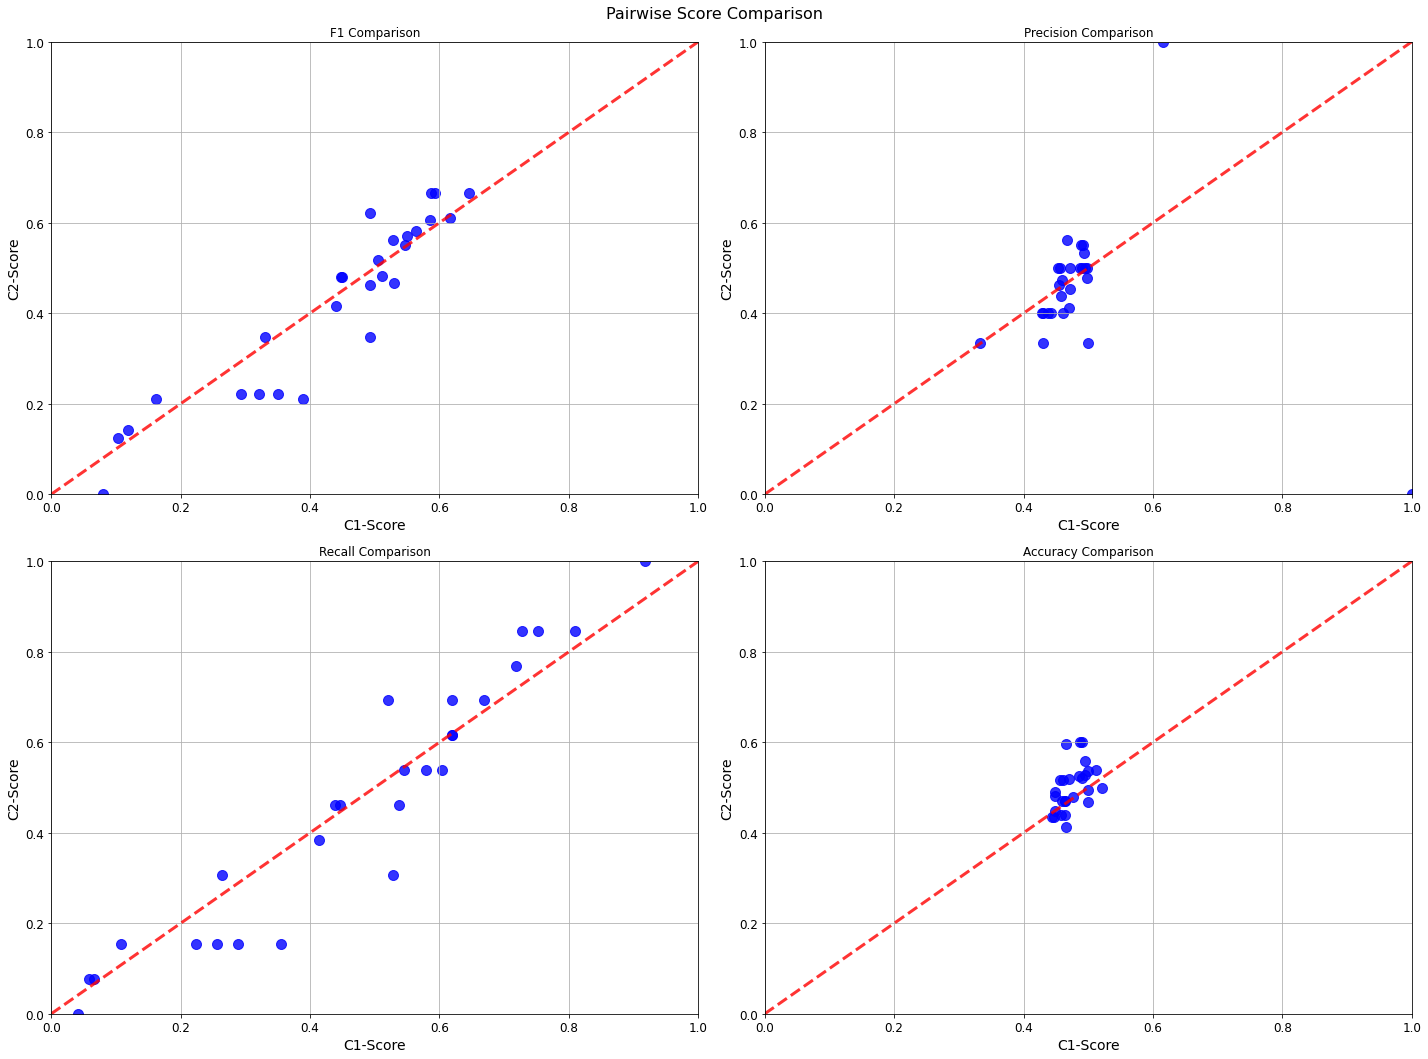

In [124]:
plot_clus1_vs_clus2_acc(metrics_val)

In [125]:
# (0.01, 5, 32, 0.1)	
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 5, 32, 0.1)]

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.640000   0.498442   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.642857   0.496933   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.637097   0.500000   

      Recall   ROC_AUC  Accuracy  
60  0.893855  0.497207  0.497207  
61  0.910112  0.497207  0.499501  
62  0.877778  0.497207  0.495069

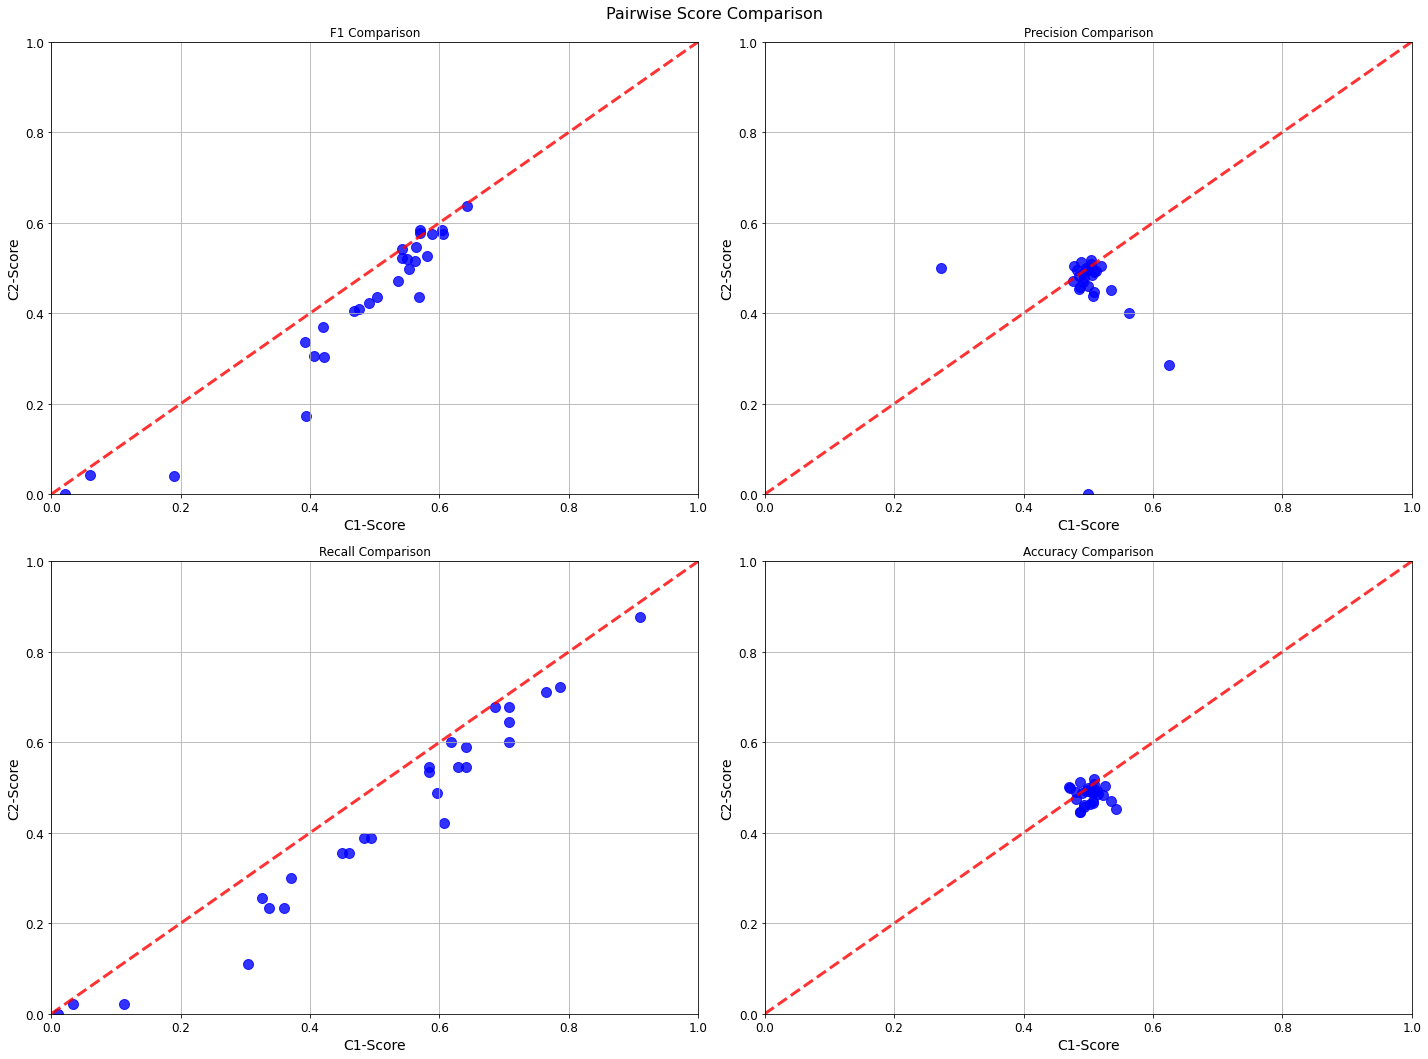

In [126]:
plot_clus1_vs_clus2_acc(metrics_test)

## Single Task with Attention

In [127]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 81
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 333
0 : 833
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0185 mins

Y1 Pred Dist : 
1 : 83
0 : 187
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0066 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 108
0 : 250
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.1542 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Y1 Pred Dist : 
1 : 413
0 : 753
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0179 mins

Y1 Pred Dist : 
1 : 98
0 : 172
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 133
0 : 225
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1515 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 329
0 : 837
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 81
0 : 189
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 106
0 : 252
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1496 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 8
0 : 1158
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 4
0 : 266
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 356
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1484 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 20
0 : 1146
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 5
0 : 265
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 350
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.1463 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 33
0 : 1133
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0171 mins

Y1 Pred Dist : 
1 : 6
0 : 264
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 10
0 : 348
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0074 mins


Finished running 'run_ssda_ST' in 0.1480 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 292
0 : 874
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 73
0 : 197
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 84
0 : 274
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1458 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 277
0 : 889
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 71
0 : 199
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 81
0 : 277
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1466 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 443
0 : 723
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 110
0 : 160
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 134
0 : 224
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1465 mins

Param_setting : 9
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 615
0 : 551
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 145
0 : 125
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 179
0 : 179
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2655 mins

Param_setting : 10
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 630
0 : 536
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 144
0 : 126
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0065 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 192
0 : 166
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2672 mins

Param_setting : 11
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 732
0 : 434
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 180
0 : 90
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 220
0 : 138
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2645 mins

Param_setting : 12
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 683
0 : 483
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0171 mins

Y1 Pred Dist : 
1 : 161
0 : 109
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 206
0 : 152
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.2615 mins

Param_setting : 13
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 787
0 : 379
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 191
0 : 79
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 232
0 : 126
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2614 mins

Param_setting : 14
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 775
0 : 391
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 191
0 : 79
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 233
0 : 125
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2627 mins

Param_setting : 15
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 510
0 : 656
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 130
0 : 140
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins

Y1 Pred Dist : 
1 : 158
0 : 200
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2605 mins

Param_setting : 16
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 699
0 : 467
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 175
0 : 95
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 214
0 : 144
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2598 mins

Param_setting : 17
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 845
0 : 321
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 203
0 : 67
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 255
0 : 103
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2582 mins

Param_setting : 18
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 721
0 : 445
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 173
0 : 97
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 217
0 : 141
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3804 mins

Param_setting : 19
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 814
0 : 352
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0179 mins

Y1 Pred Dist : 
1 : 192
0 : 78
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 247
0 : 111
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3797 mins

Param_setting : 20
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 827
0 : 339
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 202
0 : 68
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 248
0 : 110
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3798 mins

Param_setting : 21
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 672
0 : 494
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 164
0 : 106
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 197
0 : 161
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.3785 mins

Param_setting : 22
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 754
0 : 412
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 186
0 : 84
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 223
0 : 135
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3784 mins

Param_setting : 23
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 751
0 : 415
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 186
0 : 84
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 225
0 : 133
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3769 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 743
0 : 423
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0171 mins

Y1 Pred Dist : 
1 : 178
0 : 92
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 224
0 : 134
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3717 mins

Param_setting : 25
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 855
0 : 311
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 207
0 : 63
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 257
0 : 101
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3688 mins

Param_setting : 26
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 843
0 : 323
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0170 mins

Y1 Pred Dist : 
1 : 208
0 : 62
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 248
0 : 110
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.3699 mins

Param_setting : 27
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 326
0 : 840
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0183 mins

Y1 Pred Dist : 
1 : 78
0 : 192
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 105
0 : 253
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1489 mins

Param_setting : 28
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 332
0 : 834
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 78
0 : 192
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 106
0 : 252
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1484 mins

Param_setting : 29
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 345
0 : 821
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0178 mins

Y1 Pred Dist : 
1 : 86
0 : 184
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 110
0 : 248
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1487 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 685
0 : 481
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 162
0 : 108
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 204
0 : 154
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1465 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 691
0 : 475
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 163
0 : 107
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 204
0 : 154
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1476 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 704
0 : 462
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 166
0 : 104
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 150
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1469 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 749
0 : 417
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0171 mins

Y1 Pred Dist : 
1 : 175
0 : 95
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 216
0 : 142
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1442 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 749
0 : 417
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0170 mins

Y1 Pred Dist : 
1 : 176
0 : 94
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 217
0 : 141
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1451 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 757
0 : 409
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 177
0 : 93
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 219
0 : 139
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1444 mins

Param_setting : 36
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 225
0 : 941
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 49
0 : 221
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 67
0 : 291
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2664 mins

Param_setting : 37
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 208
0 : 958
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 47
0 : 223
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 62
0 : 296
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2659 mins

Param_setting : 38
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 254
0 : 912
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 63
0 : 207
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 82
0 : 276
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0074 mins


Finished running 'run_ssda_ST' in 0.2652 mins

Param_setting : 39
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 261
0 : 905
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 63
0 : 207
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 87
0 : 271
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.2636 mins

Param_setting : 40
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 252
0 : 914
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 61
0 : 209
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 87
0 : 271
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.2602 mins

Param_setting : 41
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 278
0 : 888
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 68
0 : 202
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 91
0 : 267
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.2635 mins

Param_setting : 42
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 484
0 : 682
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0166 mins

Y1 Pred Dist : 
1 : 114
0 : 156
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 155
0 : 203
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2567 mins

Param_setting : 43
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 492
0 : 674
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0168 mins

Y1 Pred Dist : 
1 : 116
0 : 154
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 155
0 : 203
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2573 mins

Param_setting : 44
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 500
0 : 666
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 118
0 : 152
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 156
0 : 202
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2566 mins

Param_setting : 45
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 584
0 : 582
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 147
0 : 123
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 178
0 : 180
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3800 mins

Param_setting : 46
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 603
0 : 563
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 153
0 : 117
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 175
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3795 mins

Param_setting : 47
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 818
0 : 348
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 197
0 : 73
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 252
0 : 106
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3801 mins

Param_setting : 48
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 593
0 : 573
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0176 mins

Y1 Pred Dist : 
1 : 142
0 : 128
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 178
0 : 180
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3770 mins

Param_setting : 49
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 593
0 : 573
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 143
0 : 127
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 173
0 : 185
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3774 mins

Param_setting : 50
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 700
0 : 466
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 168
0 : 102
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 150
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3768 mins

Param_setting : 51
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 606
0 : 560
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0166 mins

Y1 Pred Dist : 
1 : 140
0 : 130
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 185
0 : 173
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3691 mins

Param_setting : 52
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 614
0 : 552
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 142
0 : 128
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 186
0 : 172
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3677 mins

Param_setting : 53
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 674
0 : 492
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 156
0 : 114
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 197
0 : 161
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.3705 mins

Param_setting : 54
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 537
0 : 629
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 126
0 : 144
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 179
0 : 179
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1478 mins

Param_setting : 55
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 503
0 : 663
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 121
0 : 149
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 145
0 : 213
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1479 mins

Param_setting : 56
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 593
0 : 573
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 139
0 : 131
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 167
0 : 191
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1479 mins

Param_setting : 57
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 675
0 : 491
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0173 mins

Y1 Pred Dist : 
1 : 141
0 : 129
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 150
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1470 mins

Param_setting : 58
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 684
0 : 482
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0177 mins

Y1 Pred Dist : 
1 : 151
0 : 119
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 205
0 : 153
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.1464 mins

Param_setting : 59
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 630
0 : 536
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 147
0 : 123
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 175
0 : 183
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.1469 mins

Param_setting : 60
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 494
0 : 672
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0166 mins

Y1 Pred Dist : 
1 : 109
0 : 161
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 147
0 : 211
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1433 mins

Param_setting : 61
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 402
0 : 764
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 91
0 : 179
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 105
0 : 253
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.1446 mins

Param_setting : 62
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 443
0 : 723
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0168 mins

Y1 Pred Dist : 
1 : 87
0 : 183
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 110
0 : 248
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.1444 mins

Param_setting : 63
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 565
0 : 601
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 135
0 : 135
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 166
0 : 192
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2734 mins

Param_setting : 64
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Y1 Pred Dist : 
1 : 558
0 : 608
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0200 mins

Y1 Pred Dist : 
1 : 119
0 : 151
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0067 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 158
0 : 200
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2735 mins

Param_setting : 65
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Y1 Pred Dist : 
1 : 597
0 : 569
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0177 mins

Y1 Pred Dist : 
1 : 141
0 : 129
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 171
0 : 187
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.2796 mins

Param_setting : 66
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 563
0 : 603
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0170 mins

Y1 Pred Dist : 
1 : 108
0 : 162
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 161
0 : 197
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.2624 mins

Param_setting : 67
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 589
0 : 577
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 121
0 : 149
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 176
0 : 182
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2626 mins

Param_setting : 68
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 445
0 : 721
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 102
0 : 168
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 132
0 : 226
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2619 mins

Param_setting : 69
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 647
0 : 519
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 154
0 : 116
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 217
0 : 141
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2591 mins

Param_setting : 70
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 694
0 : 472
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0167 mins

Y1 Pred Dist : 
1 : 171
0 : 99
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 219
0 : 139
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.2568 mins

Param_setting : 71
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 973
0 : 193
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 234
0 : 36
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0062 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 301
0 : 57
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.2567 mins

Param_setting : 72
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 659
0 : 507
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0172 mins

Y1 Pred Dist : 
1 : 174
0 : 96
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 238
0 : 120
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3813 mins

Param_setting : 73
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 530
0 : 636
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 125
0 : 145
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 156
0 : 202
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3788 mins

Param_setting : 74
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 344
0 : 822
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 84
0 : 186
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 94
0 : 264
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3797 mins

Param_setting : 75
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 641
0 : 525
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0174 mins

Y1 Pred Dist : 
1 : 145
0 : 125
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 150
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0069 mins


Finished running 'run_ssda_ST' in 0.3769 mins

Param_setting : 76
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 693
0 : 473
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0180 mins

Y1 Pred Dist : 
1 : 163
0 : 107
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 238
0 : 120
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.3783 mins

Param_setting : 77
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 630
0 : 536
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0188 mins

Y1 Pred Dist : 
1 : 150
0 : 120
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0063 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 185
0 : 173
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.3782 mins

Param_setting : 78
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 597
0 : 569
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0169 mins

Y1 Pred Dist : 
1 : 145
0 : 125
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0060 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 205
0 : 153
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3800 mins

Param_setting : 79
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 559
0 : 607
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0168 mins

Y1 Pred Dist : 
1 : 114
0 : 156
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0061 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 177
0 : 181
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0071 mins


Finished running 'run_ssda_ST' in 0.3698 mins

Param_setting : 80
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 765
0 : 401
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0175 mins

Y1 Pred Dist : 
1 : 186
0 : 84
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0069 mins

Y1 Pred Dist : 
1 : 235
0 : 123
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.3815 mins



In [128]:
print_res(metrics_val)

Settings Score_type   Output_type        F1  Precision  \
0     (0.001, 5, 8, 0.1)    overall  class_scores  0.359447   0.469880   
1     (0.001, 5, 8, 0.1)   cluster1  class_scores  0.371859   0.474359   
2     (0.001, 5, 8, 0.1)   cluster2  class_scores  0.222222   0.400000   
3     (0.001, 5, 8, 0.3)    overall  class_scores  0.439655   0.520408   
4     (0.001, 5, 8, 0.3)   cluster1  class_scores  0.450704   0.521739   
..                   ...        ...           ...       ...        ...   
238  (0.01, 15, 32, 0.3)   cluster1  class_scores  0.434389   0.480000   
239  (0.01, 15, 32, 0.3)   cluster2  class_scores  0.592593   0.571429   
240  (0.01, 15, 32, 0.5)    overall  class_scores  0.525000   0.451613   
241  (0.01, 15, 32, 0.5)   cluster1  class_scores  0.519031   0.446429   
242  (0.01, 15, 32, 0.5)   cluster2  class_scores  0.580645   0.500000   

       Recall   ROC_AUC  Accuracy  
0    0.291045  0.485185  0.483758  
1    0.305785  0.485597  0.484860  
2    0.153846  0.481481  0.469780  
3    0.380597  0.518519  0.517504  
4    0.396694  0.518519  0.518019  
..        ...       ...       ...  
238  0.396694  0.485597  0.485232  
239  0.615385  0.592593  0.593407  
240  0.626866  0.437037  0.438433  
241  0.619835  0.427984  0.428770  
242  0.692308  0.518519  0.524725  

[243 rows x 8 columns]

In [129]:
print_res(metrics_test).to_csv("95_45_single_att.csv",index=False)

In [130]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
216  (0.01, 15, 8, 0.1)    overall  class_scores  0.655844   0.580460   
217  (0.01, 15, 8, 0.1)   cluster1  class_scores  0.659420   0.587097   
218  (0.01, 15, 8, 0.1)   cluster2  class_scores  0.625000   0.526316   

       Recall   ROC_AUC  Accuracy  
216  0.753731  0.607407  0.608483  
217  0.752066  0.613169  0.613738  
218  0.769231  0.555556  0.563187

In [131]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
216  (0.01, 15, 8, 0.1)    overall  class_scores  0.655844   0.580460   
217  (0.01, 15, 8, 0.1)   cluster1  class_scores  0.659420   0.587097   
218  (0.01, 15, 8, 0.1)   cluster2  class_scores  0.625000   0.526316   

       Recall   ROC_AUC  Accuracy  
216  0.753731  0.607407  0.608483  
217  0.752066  0.613169  0.613738  
218  0.769231  0.555556  0.563187

In [132]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision  \
216  (0.01, 15, 8, 0.1)    overall  class_scores  0.655844   0.580460   
217  (0.01, 15, 8, 0.1)   cluster1  class_scores  0.659420   0.587097   
218  (0.01, 15, 8, 0.1)   cluster2  class_scores  0.625000   0.526316   

       Recall   ROC_AUC  Accuracy  
216  0.753731  0.607407  0.608483  
217  0.752066  0.613169  0.613738  
218  0.769231  0.555556  0.563187

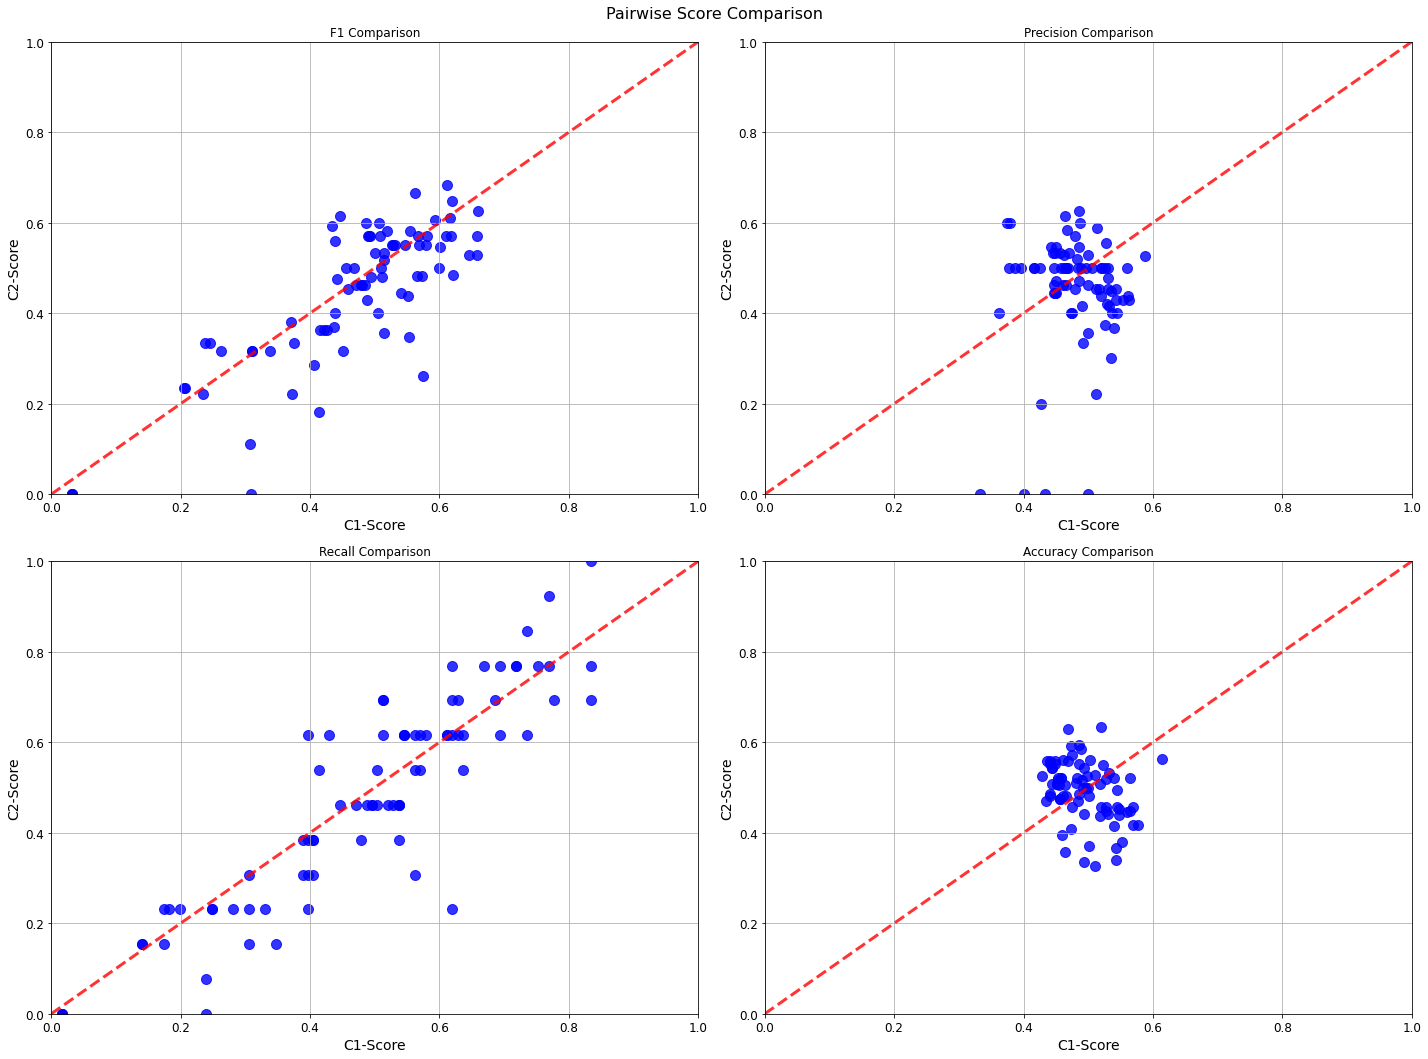

In [133]:
plot_clus1_vs_clus2_acc(metrics_val)

In [134]:
# (0.01, 15, 8, 0.1)	
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 15, 8, 0.1)]

Settings Score_type   Output_type        F1  Precision  \
216  (0.01, 15, 8, 0.1)    overall  class_scores  0.565947   0.495798   
217  (0.01, 15, 8, 0.1)   cluster1  class_scores  0.623256   0.531746   
218  (0.01, 15, 8, 0.1)   cluster2  class_scores  0.504950   0.455357   

       Recall   ROC_AUC  Accuracy  
216  0.659218  0.494413  0.494413  
217  0.752809  0.547486  0.548627  
218  0.566667  0.441341  0.440637

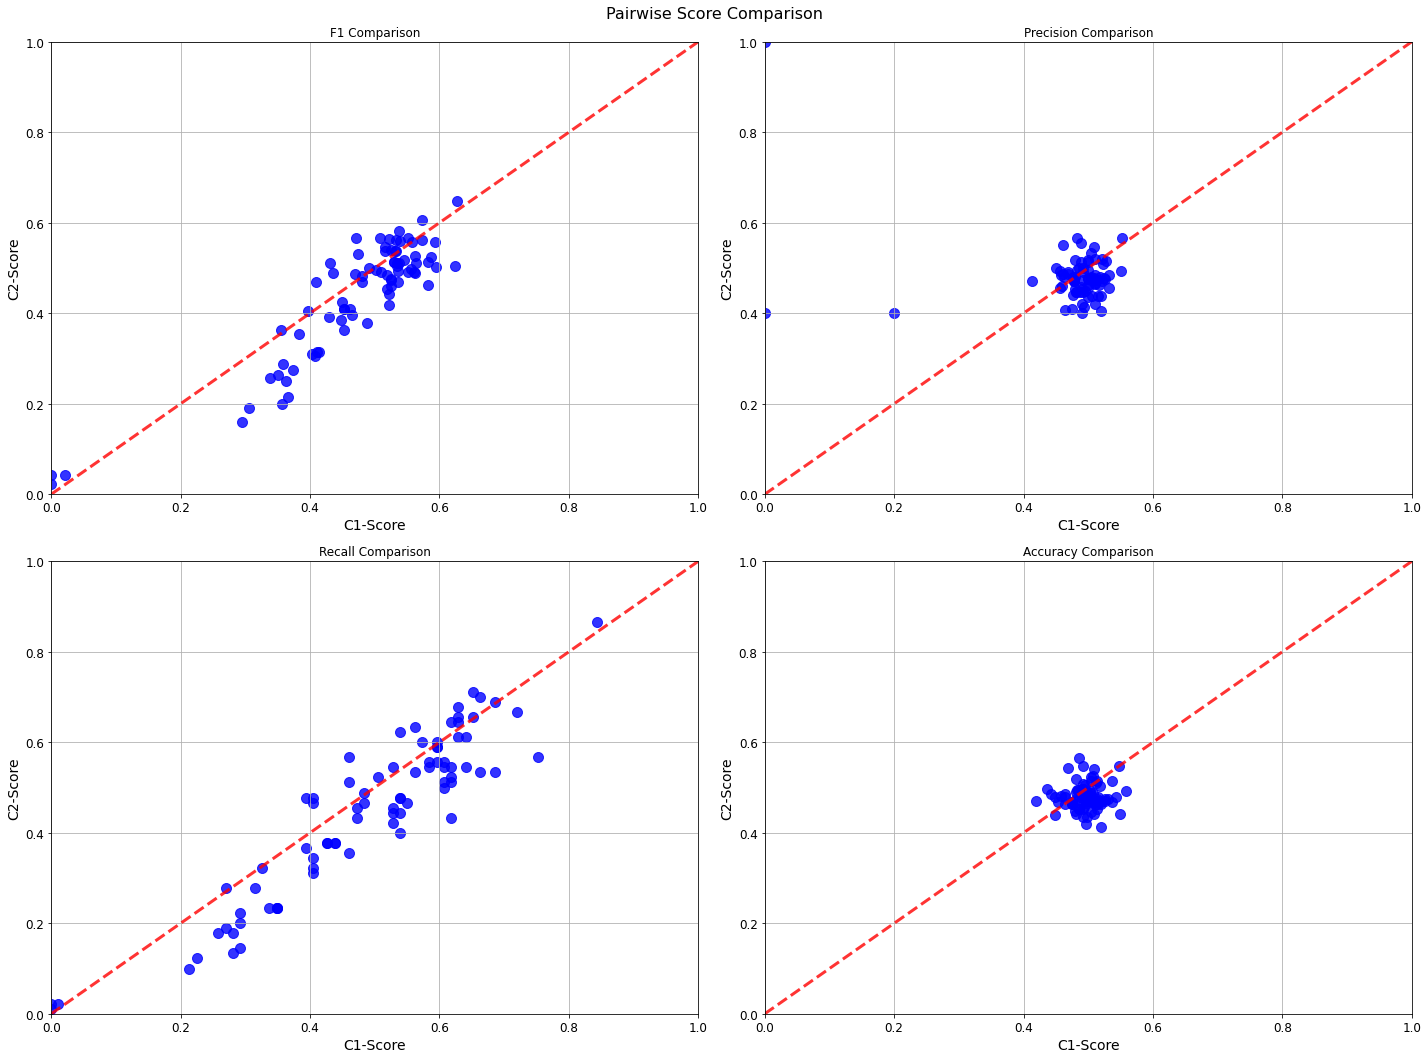

In [135]:
plot_clus1_vs_clus2_acc(metrics_test)

## Multi Task with Attention

In [147]:
metrics_train,metrics_test, metrics_val,losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       word_pred_loss_weights=[0.1,0.4,0.8],
                                                                       batch_sizes=[16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       l2s = [0.05],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136


  0%|          | 0/5 [00:00<?, ?it/s]

Number of param combinations : 162
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Y1 Pred Dist : 
1 : 452
0 : 714
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 111
0 : 159
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 141
0 : 217
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 41
0 : 1125
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 12
0 : 258
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 12
0 : 346
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 53
0 : 1113
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 11
0 : 259
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 14
0 : 344
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 523
0 : 643
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 132
0 : 138
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 164
0 : 194
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 52
0 : 1114
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 12
0 : 258
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 16
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Y1 Pred Dist : 
1 : 63
0 : 1103
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 11
0 : 259
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 21
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 549
0 : 617
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 141
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 155
0 : 203
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 282
0 : 884
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 75
0 : 195
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 86
0 : 272
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 75
0 : 1091
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 13
0 : 257
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 25
0 : 333
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 109
0 : 1057
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 29
0 : 241
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 31
0 : 327
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 1110
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 267
0 : 3
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 342
0 : 16
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 1106
0 : 60
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 264
0 : 6
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 345
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 285
0 : 881
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 73
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 88
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 1112
0 : 54
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 265
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0065 mins

Y1 Pred Dist : 
1 : 343
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 1102
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 264
0 : 6
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 345
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 479
0 : 687
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 117
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 154
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 1110
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 265
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 344
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 1105
0 : 61
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 263
0 : 7
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 342
0 : 16
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 636
0 : 530
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 147
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 200
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Y1 Pred Dist : 
1 : 1080
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 252
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 329
0 : 29
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1078
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 255
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 337
0 : 21
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 718
0 : 448
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 173
0 : 97
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 224
0 : 134
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1081
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 255
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 328
0 : 30
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1079
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 257
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 339
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Y1 Pred Dist : 
1 : 806
0 : 360
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 205
0 : 65
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 252
0 : 106
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1090
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 259
0 : 11
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 335
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1077
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 254
0 : 16
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 341
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 602
0 : 564
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 155
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 187
0 : 171
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Y1 Pred Dist : 
1 : 858
0 : 308
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 200
0 : 70
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 268
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Y1 Pred Dist : 
1 : 897
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0180 mins

Y1 Pred Dist : 
1 : 208
0 : 62
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 276
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 727
0 : 439
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 177
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 222
0 : 136
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 842
0 : 324
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 199
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 262
0 : 96
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 885
0 : 281
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 206
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 277
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 853
0 : 313
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 205
0 : 65
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 259
0 : 99
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 776
0 : 390
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 189
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 238
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 818
0 : 348
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 197
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 255
0 : 103
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 464
0 : 702
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 109
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 148
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 166
0 : 1000
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 30
0 : 240
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 41
0 : 317
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 132
0 : 1034
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 29
0 : 241
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 37
0 : 321
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 527
0 : 639
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 131
0 : 139
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 156
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 289
0 : 877
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 60
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 92
0 : 266
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 133
0 : 1033
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 26
0 : 244
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 40
0 : 318
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 349
0 : 817
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 90
0 : 180
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 105
0 : 253
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 100
0 : 1066
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 12
0 : 258
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 20
0 : 338
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shap

100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 122
0 : 1044
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 22
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 39
0 : 319
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 374
0 : 792
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 94
0 : 176
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 114
0 : 244
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 47
0 : 1119
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 6
0 : 264
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 11
0 : 347
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 40
0 : 1126
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 10
0 : 260
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 13
0 : 345
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 396
0 : 770
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 98
0 : 172
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 112
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 50
0 : 1116
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 5
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 10
0 : 348
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 39
0 : 1127
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 9
0 : 261
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 12
0 : 346
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 374
0 : 792
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 88
0 : 182
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 107
0 : 251
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 51
0 : 1115
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0180 mins

Y1 Pred Dist : 
1 : 5
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 9
0 : 349
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape :

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 41
0 : 1125
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 6
0 : 264
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 13
0 : 345
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 1
0 : 1165
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 0
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted 

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 162
0 : 1004
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 43
0 : 227
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 53
0 : 305
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 101
0 : 1065
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 21
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 38
0 : 320
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 94
0 : 1072
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 19
0 : 251
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 35
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 158
0 : 1008
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0191 mins

Y1 Pred Dist : 
1 : 41
0 : 229
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 52
0 : 306
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 87
0 : 1079
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 19
0 : 251
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 32
0 : 326
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 80
0 : 1086
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 18
0 : 252
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 32
0 : 326
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 148
0 : 1018
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 39
0 : 231
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 48
0 : 310
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 70
0 : 1096
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 15
0 : 255
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 24
0 : 334
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 67
0 : 1099
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 15
0 : 255
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 21
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 133
0 : 1033
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 29
0 : 241
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 44
0 : 314
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 2
0 : 1164
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 0
0 : 358


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 1
0 : 1165
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 97
0 : 1069
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 22
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 31
0 : 327
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 42
0 : 1124
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 11
0 : 259
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 13
0 : 345
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 0
0 : 1166
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One cl

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


Y1 Pred Dist : 
1 : 385
0 : 781
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 92
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 112
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1
0 : 1165
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 2
0 : 1164
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


Y1 Pred Dist : 
1 : 399
0 : 767
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 98
0 : 172
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0065 mins

Y1 Pred Dist : 
1 : 117
0 : 241
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 1
0 : 1165
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 0
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 2
0 : 1164
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 0
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 491
0 : 675
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 114
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 146
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 2
0 : 1164
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 0
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 3
0 : 1163
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 1
0 : 269
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 0
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 451
0 : 715
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 115
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 142
0 : 216
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 350
0 : 816
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 94
0 : 176
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 105
0 : 253
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 347
0 : 819
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 94
0 : 176
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 104
0 : 254
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 445
0 : 721
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 113
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 140
0 : 218
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 336
0 : 830
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 92
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 103
0 : 255
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 334
0 : 832
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 92
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 103
0 : 255
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 431
0 : 735
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 109
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 135
0 : 223
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 302
0 : 864
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 77
0 : 193
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 98
0 : 260
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 300
0 : 866
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 77
0 : 193
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 98
0 : 260
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 443
0 : 723
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 83
0 : 187
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 139
0 : 219
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 360
0 : 806
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 70
0 : 200
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 92
0 : 266
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 869
0 : 297
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 206
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 272
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 331
0 : 835
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 89
0 : 181
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 88
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 660
0 : 506
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 164
0 : 106
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 207
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 770
0 : 396
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 181
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 243
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 206
0 : 960
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 54
0 : 216
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 57
0 : 301
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 676
0 : 490
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 174
0 : 96
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 214
0 : 144
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 756
0 : 410
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 182
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 232
0 : 126
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 477
0 : 689
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 115
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 134
0 : 224
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Y1 Pred Dist : 
1 : 362
0 : 804
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 62
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 105
0 : 253
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 682
0 : 484
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 156
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 211
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 498
0 : 668
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 113
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 155
0 : 203
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 813
0 : 353
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 189
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 249
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 621
0 : 545
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 146
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 195
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 441
0 : 725
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 86
0 : 184
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 135
0 : 223
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 795
0 : 371
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 183
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 244
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 843
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 196
0 : 74
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 260
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 673
0 : 493
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 157
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 219
0 : 139
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 648
0 : 518
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 164
0 : 106
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 208
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Y1 Pred Dist : 
1 : 138
0 : 1028
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 26
0 : 244
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 46
0 : 312
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 749
0 : 417
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 194
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 241
0 : 117
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 110
0 : 1056
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 18
0 : 252
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 27
0 : 331
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 76
0 : 1090
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 9
0 : 261
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 27
0 : 331
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 498
0 : 668
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 112
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 154
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 67
0 : 1099
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 9
0 : 261
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 18
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 81
0 : 1085
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 12
0 : 258
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0065 mins

Y1 Pred Dist : 
1 : 18
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 543
0 : 623
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 123
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 157
0 : 201
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Y1 Pred Dist : 
1 : 542
0 : 624
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 114
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 164
0 : 194
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 1108
0 : 58
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 263
0 : 7
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 346
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 658
0 : 508
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 159
0 : 111
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 220
0 : 138
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 1113
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 265
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 350
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape :

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 1111
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 264
0 : 6
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 350
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape :

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 808
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 195
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 273
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 1114
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 264
0 : 6
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 346
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 1114
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 266
0 : 4
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 350
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape :

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 568
0 : 598
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 102
0 : 168
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 161
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 538
0 : 628
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0190 mins

Y1 Pred Dist : 
1 : 110
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 137
0 : 221
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 68
0 : 1098
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 15
0 : 255
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 20
0 : 338
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Y1 Pred Dist : 
1 : 533
0 : 633
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 114
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 156
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 58
0 : 1108
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0186 mins

Y1 Pred Dist : 
1 : 10
0 : 260
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 15
0 : 343
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 51
0 : 1115
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0189 mins

Y1 Pred Dist : 
1 : 5
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 8
0 : 350
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word l

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 567
0 : 599
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 118
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0061 mins

Y1 Pred Dist : 
1 : 156
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 56
0 : 1110
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 8
0 : 262
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 14
0 : 344
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Y1 Pred Dist : 
1 : 53
0 : 1113
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0192 mins

Y1 Pred Dist : 
1 : 8
0 : 262
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 16
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word 

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 566
0 : 600
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 118
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 167
0 : 191
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 524
0 : 642
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0187 mins

Y1 Pred Dist : 
1 : 101
0 : 169
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 133
0 : 225
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 164
0 : 1002
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0188 mins

Y1 Pred Dist : 
1 : 35
0 : 235
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0064 mins

Y1 Pred Dist : 
1 : 48
0 : 310
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 574
0 : 592
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 120
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 158
0 : 200
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 264
0 : 902
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 61
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 71
0 : 287
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:24<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 199
0 : 967
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0183 mins

Y1 Pred Dist : 
1 : 37
0 : 233
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 57
0 : 301
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:24<00:00,  1.60s/it]


Y1 Pred Dist : 
1 : 417
0 : 749
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0184 mins

Y1 Pred Dist : 
1 : 97
0 : 173
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 109
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wor

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 169
0 : 997
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0181 mins

Y1 Pred Dist : 
1 : 31
0 : 239
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0062 mins

Y1 Pred Dist : 
1 : 51
0 : 307
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for word

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Y1 Pred Dist : 
1 : 85
0 : 1081
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0182 mins

Y1 Pred Dist : 
1 : 17
0 : 253
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0063 mins

Y1 Pred Dist : 
1 : 29
0 : 329
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape

In [154]:
print_res(metrics_val)

Settings Score_type   Output_type        F1  \
0    (0.001, 5, 16, 0.1, 0.1, 0.05)    overall  class_scores  0.473469   
2    (0.001, 5, 16, 0.1, 0.1, 0.05)   cluster1  class_scores  0.484018   
4    (0.001, 5, 16, 0.1, 0.1, 0.05)   cluster2  class_scores  0.384615   
6    (0.001, 5, 16, 0.1, 0.4, 0.05)    overall  class_scores  0.123288   
8    (0.001, 5, 16, 0.1, 0.4, 0.05)   cluster1  class_scores  0.135338   
..                              ...        ...           ...       ...   
962  (0.01, 15, 32, 0.5, 0.4, 0.05)   cluster1  class_scores  0.225166   
964  (0.01, 15, 32, 0.5, 0.4, 0.05)   cluster2  class_scores  0.000000   
966  (0.01, 15, 32, 0.5, 0.8, 0.05)    overall  class_scores  0.145695   
968  (0.01, 15, 32, 0.5, 0.8, 0.05)   cluster1  class_scores  0.159420   
970  (0.01, 15, 32, 0.5, 0.8, 0.05)   cluster2  class_scores  0.000000   

     Precision    Recall   ROC_AUC  Accuracy  
0     0.522523  0.432836  0.522222  0.521565  
2     0.540816  0.438017  0.534979  0.534582  
4     0.384615  0.384615  0.407407  0.406593  
6     0.750000  0.067164  0.525926  0.522553  
8     0.750000  0.074380  0.526749  0.524895  
..         ...       ...       ...       ...  
962   0.566667  0.140496  0.518519  0.516969  
964   0.000000  0.000000  0.481481  0.464286  
966   0.647059  0.082090  0.522222  0.518986  
968   0.647059  0.090909  0.522634  0.520864  
970   0.000000  0.000000  0.518519  0.500000  

[486 rows x 8 columns]

In [155]:
print_res(metrics_test).to_csv("95_45_multi_att.csv",index=False)

In [156]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  \
60  (0.001, 5, 32, 0.1, 0.4, 0.05)    overall  class_scores  0.663342   
62  (0.001, 5, 32, 0.1, 0.4, 0.05)   cluster1  class_scores  0.662983   
64  (0.001, 5, 32, 0.1, 0.4, 0.05)   cluster2  class_scores  0.666667   

    Precision    Recall   ROC_AUC  Accuracy  
60   0.498127  0.992537  0.500000  0.503622  
62   0.497925  0.991736  0.497942  0.499966  
64   0.500000  1.000000  0.518519  0.535714

In [157]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  \
162  (0.001, 10, 32, 0.1, 0.1, 0.05)    overall  class_scores  0.588235   
164  (0.001, 10, 32, 0.1, 0.1, 0.05)   cluster1  class_scores  0.586873   
166  (0.001, 10, 32, 0.1, 0.1, 0.05)   cluster2  class_scores  0.600000   

     Precision    Recall   ROC_AUC  Accuracy  
162   0.548387  0.634328  0.559259  0.559811  
164   0.550725  0.628099  0.559671  0.559951  
166   0.529412  0.692308  0.555556  0.560440

In [158]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  \
330  (0.0001, 5, 16, 0.1, 0.4, 0.05)    overall  class_scores  0.014815   
332  (0.0001, 5, 16, 0.1, 0.4, 0.05)   cluster1  class_scores  0.016393   
334  (0.0001, 5, 16, 0.1, 0.4, 0.05)   cluster2  class_scores  0.000000   

     Precision    Recall   ROC_AUC  Accuracy  
330        1.0  0.007463  0.507407  0.503731  
332        1.0  0.008264  0.506173  0.504132  
334        0.0  0.000000  0.518519  0.500000

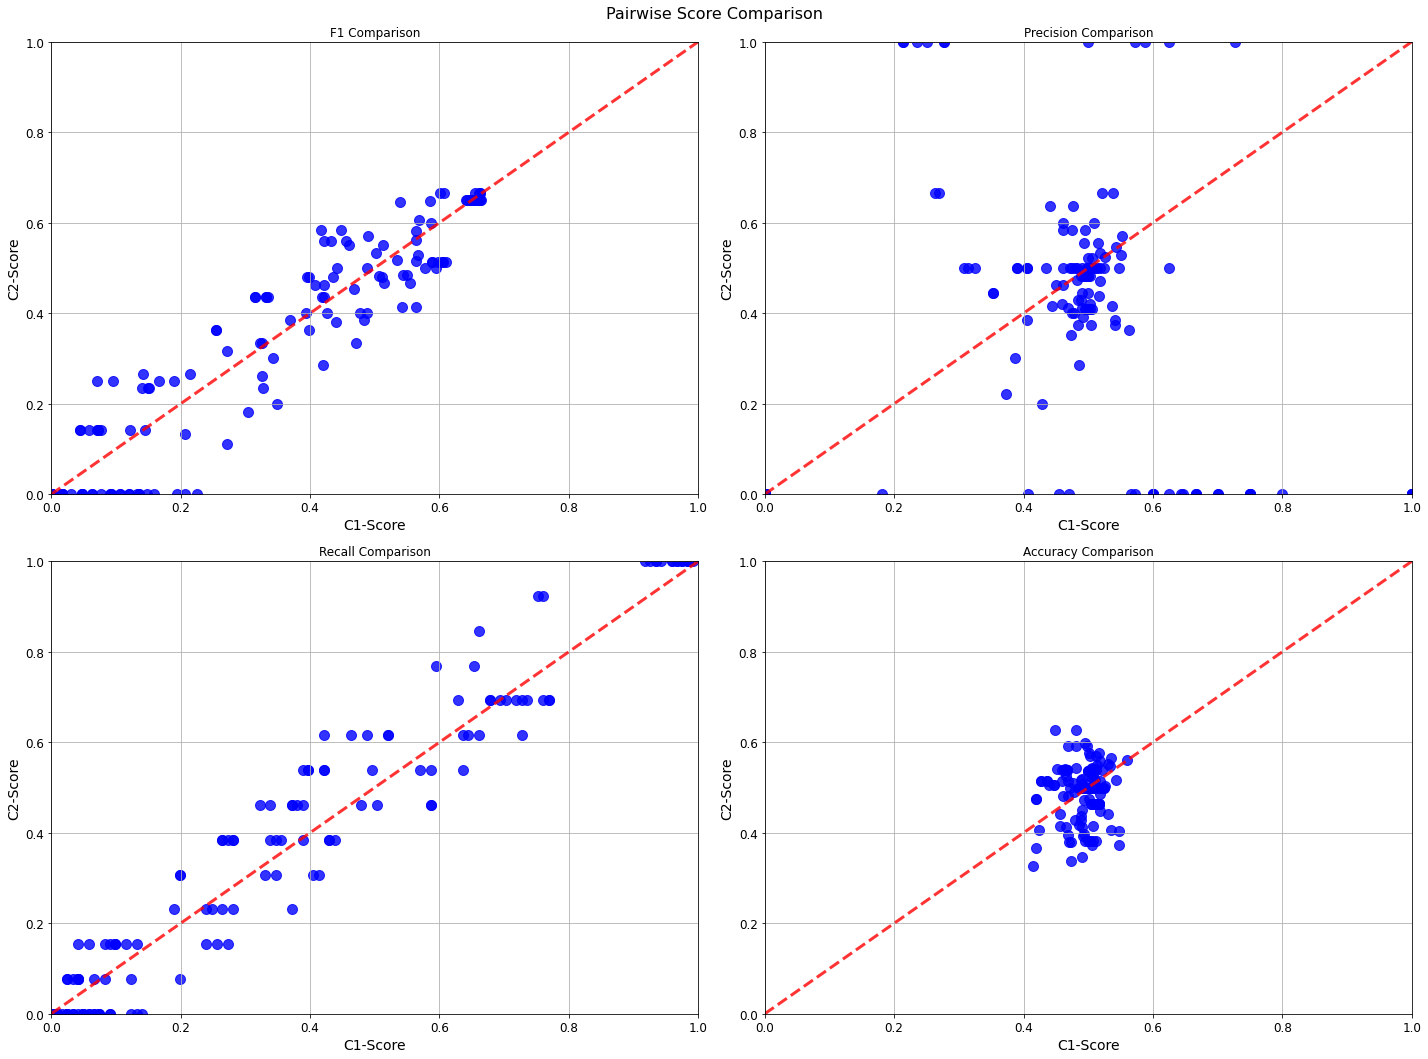

In [159]:
plot_clus1_vs_clus2_acc(metrics_val)

In [160]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.001, 10, 32, 0.1, 0.1, 0.05)]

Settings Score_type   Output_type        F1  \
162  (0.001, 10, 32, 0.1, 0.1, 0.05)    overall  class_scores  0.508197   
164  (0.001, 10, 32, 0.1, 0.1, 0.05)   cluster1  class_scores  0.500000   
166  (0.001, 10, 32, 0.1, 0.1, 0.05)   cluster2  class_scores  0.516854   

     Precision    Recall   ROC_AUC  Accuracy  
162   0.497326  0.519553  0.497207  0.497207  
164   0.474747  0.528090  0.474860  0.475156  
166   0.522727  0.511111  0.519553  0.519600

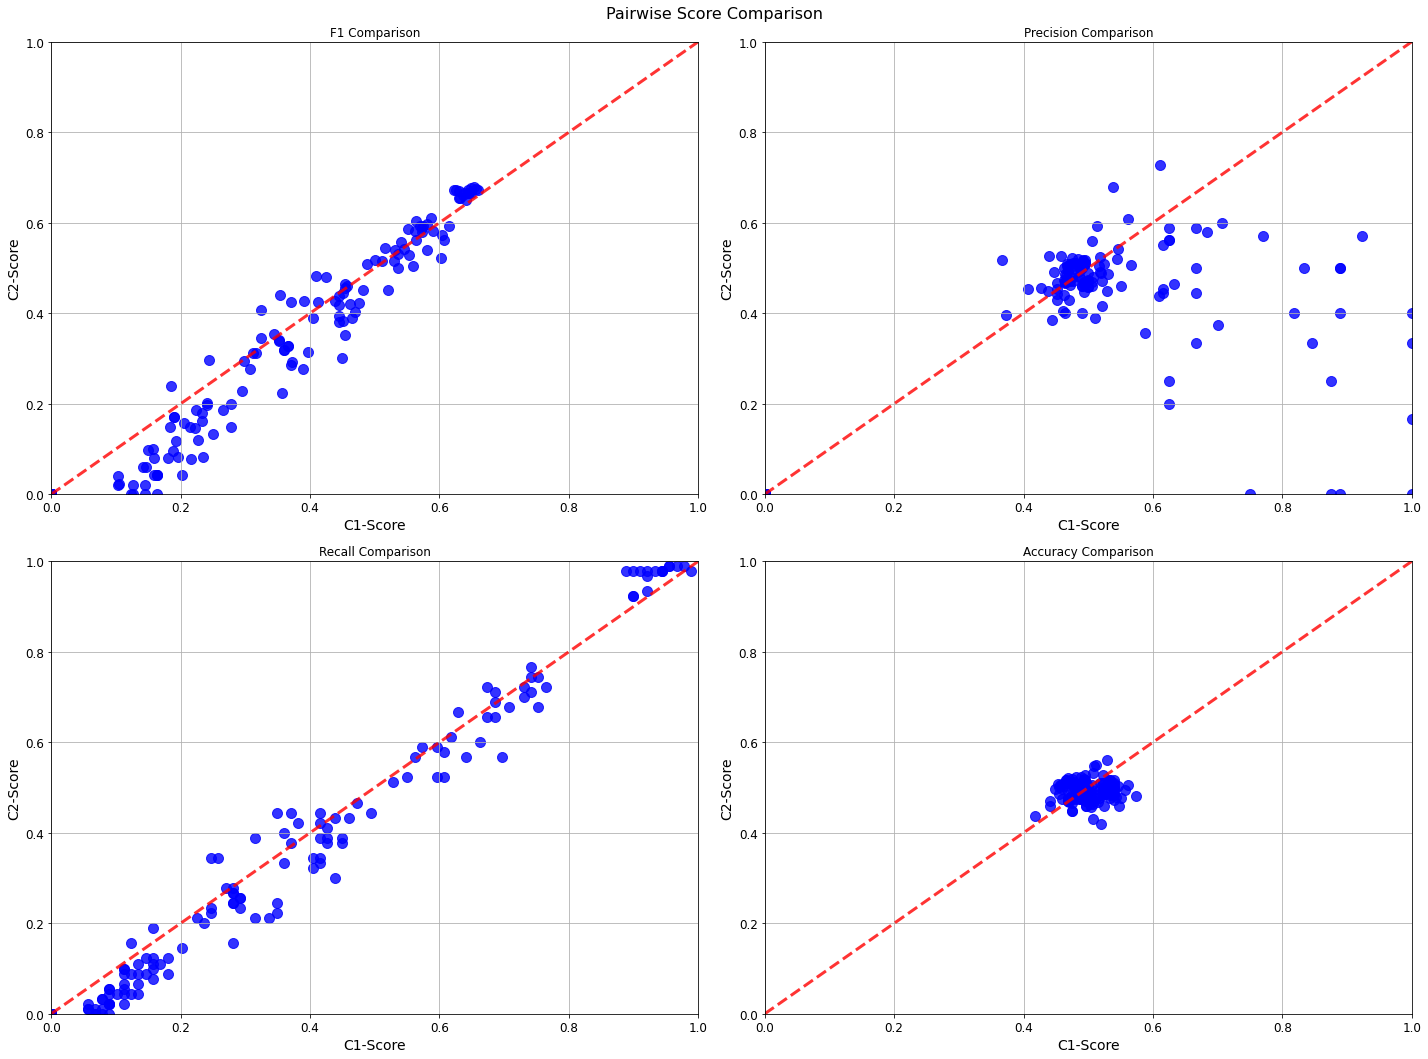

In [161]:
plot_clus1_vs_clus2_acc(metrics_test)

# Experiment 2: Increasing Topic Heterogeniety

## Single Task without Attention

### C1-Mix - 2 cluster

In [176]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.05,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=False,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 324.9675
Percentage of Val size for c in c1mix : 74.9925
Percentage of test size for c in c1mix : 55.550000000000004

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (221, 16)
1 : 109
0 : 112
Val Size : (164, 16)
1 : 82
0 : 82
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 33
0 : 650
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 4
0 : 159
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 12
0 : 206
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1077 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed : 

  0%|          | 0/5 [00:00<?, ?it/s]

 42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 574
0 : 109
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 133
0 : 30
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 186
0 : 32
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1103 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 613
0 : 70
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 142
0 : 21
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 195
0 : 23
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1072 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 217
0 : 466
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 51
0 : 112
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 85
0 : 133
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1977 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 335
0 : 348
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 74
0 : 89
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 120
0 : 98
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1917 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 549
0 : 134
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 127
0 : 36
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 179
0 : 39
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1924 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 53
0 : 630
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 8
0 : 155
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 21
0 : 197
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.2826 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 212
0 : 471
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 48
0 : 115
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 82
0 : 136
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2795 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 31
0 : 652
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 13
0 : 205
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2715 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 518
0 : 165
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 123
0 : 40
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 172
0 : 46
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1074 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 468
0 : 215
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 110
0 : 53
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 156
0 : 62
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1068 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 421
0 : 262
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 101
0 : 62
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 136
0 : 82
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1065 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 536
0 : 147
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 129
0 : 34
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 177
0 : 41
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1903 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 532
0 : 151
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 128
0 : 35
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 175
0 : 43
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1858 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 501
0 : 182
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 119
0 : 44
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 166
0 : 52
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0056 mins


Finished running 'run_ssda_ST' in 0.1827 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 157
0 : 526
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 35
0 : 128
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 57
0 : 161
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.2653 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 380
0 : 303
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 129
0 : 89
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.2625 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 462
0 : 221
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0111 mins

Y1 Pred Dist : 
1 : 102
0 : 61
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 156
0 : 62
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0056 mins


Finished running 'run_ssda_ST' in 0.2647 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 66
0 : 617
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 15
0 : 148
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 26
0 : 192
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1040 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 207
0 : 476
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 40
0 : 123
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 76
0 : 142
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1046 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 11
0 : 672
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 1
0 : 162
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 4
0 : 214
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1029 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 567
0 : 116
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 136
0 : 27
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 177
0 : 41
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.1857 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 111
0 : 572
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0111 mins

Y1 Pred Dist : 
1 : 23
0 : 140
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 39
0 : 179
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1831 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 315
0 : 368
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 66
0 : 97
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins

Y1 Pred Dist : 
1 : 98
0 : 120
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1829 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 38
0 : 645
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 4
0 : 159
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 14
0 : 204
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2659 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 196
0 : 487
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 40
0 : 123
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 60
0 : 158
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.2637 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 43
0 : 640
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0111 mins

Y1 Pred Dist : 
1 : 5
0 : 158
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0050 mins

Y1 Pred Dist : 
1 : 11
0 : 207
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.2622 mins



In [177]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
63  (0.01, 10, 8, 0.1)    overall  class_scores  0.654378   0.522059   
64  (0.01, 10, 8, 0.1)   cluster1  class_scores  0.646465   0.516129   
65  (0.01, 10, 8, 0.1)   cluster2  class_scores  0.736842   0.583333   

      Recall   ROC_AUC  Accuracy  
63  0.876543  0.539877  0.541930  
64  0.864865  0.527027  0.527027  
65  1.000000  0.666667  0.687500

In [178]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision  \
45  (0.0001, 15, 8, 0.1)    overall  class_scores  0.344828   0.571429   
46  (0.0001, 15, 8, 0.1)   cluster1  class_scores  0.358491   0.593750   
47  (0.0001, 15, 8, 0.1)   cluster2  class_scores  0.200000   0.333333   

      Recall   ROC_AUC  Accuracy  
45  0.246914  0.533742  0.531993  
46  0.256757  0.540541  0.540541  
47  0.142857  0.466667  0.446429

In [179]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
15  (0.001, 10, 32, 0.1)    overall  class_scores  0.653846   0.535433   
16  (0.001, 10, 32, 0.1)   cluster1  class_scores  0.648936   0.535088   
17  (0.001, 10, 32, 0.1)   cluster2  class_scores  0.700000   0.538462   

      Recall   ROC_AUC  Accuracy  
15  0.839506  0.558282  0.559997  
16  0.824324  0.554054  0.554054  
17  1.000000  0.600000  0.625000

In [180]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 10, 8, 0.1)]

Settings Score_type   Output_type        F1  Precision  \
63  (0.01, 10, 8, 0.1)    overall  class_scores  0.577465   0.463277   
64  (0.01, 10, 8, 0.1)   cluster1  class_scores  0.567376   0.449438   
65  (0.01, 10, 8, 0.1)   cluster2  class_scores  0.587413   0.477273   

      Recall   ROC_AUC  Accuracy  
63  0.766355  0.449541  0.455250  
64  0.769231  0.429907  0.439161  
65  0.763636  0.468468  0.471104

### C1-Mix - 3 cluster

In [181]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99,3],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.05,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=False,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 216.64499999999998
Percentage of Val size for c in c1mix : 49.995000000000005
Percentage of test size for c in c1mix : 37.03333333333334

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (222, 16)
1 : 109
0 : 113
Val Size : (163, 16)
1 : 83
0 : 80
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 656
0 : 25
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 155
0 : 6
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 215
0 : 6
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1097 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 402
0 : 279
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 91
0 : 70
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 142
0 : 79
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1083 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 279
0 : 402
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 64
0 : 97
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 102
0 : 119
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1089 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 471
0 : 210
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 112
0 : 49
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 158
0 : 63
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1984 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 551
0 : 130
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 132
0 : 29
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 186
0 : 35
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1876 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 537
0 : 144
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 128
0 : 33
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 38
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1870 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 475
0 : 206
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 117
0 : 44
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 161
0 : 60
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2729 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 464
0 : 217
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 114
0 : 47
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 158
0 : 63
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.2689 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 445
0 : 236
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 106
0 : 55
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 151
0 : 70
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2691 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 275
0 : 406
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 62
0 : 99
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 99
0 : 122
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1074 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 277
0 : 404
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 57
0 : 104
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 101
0 : 120
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1059 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 321
0 : 360
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 69
0 : 92
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 114
0 : 107
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1061 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 412
0 : 269
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 95
0 : 66
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 138
0 : 83
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1902 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 340
0 : 341
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 76
0 : 85
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 124
0 : 97
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1878 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 304
0 : 377
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 66
0 : 95
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 114
0 : 107
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1868 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 358
0 : 323
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 87
0 : 74
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 131
0 : 90
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2724 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 334
0 : 347
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 77
0 : 84
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 123
0 : 98
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2699 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 356
0 : 325
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 81
0 : 80
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 127
0 : 94
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2681 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 95
0 : 586
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 26
0 : 135
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 32
0 : 189
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1081 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 381
0 : 300
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 91
0 : 70
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 133
0 : 88
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1062 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 671
0 : 10
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 160
0 : 1
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 220
0 : 1
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predicitions for class labels
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0064 mins


Finished running 'run_ssda_ST' in 0.1071 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 599
0 : 82
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 145
0 : 16
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 200
0 : 21
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1908 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 577
0 : 104
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 144
0 : 17
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 191
0 : 30
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1872 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 542
0 : 139
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 129
0 : 32
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 178
0 : 43
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1872 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 536
0 : 145
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 128
0 : 33
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 179
0 : 42
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2733 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 524
0 : 157
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 126
0 : 35
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 170
0 : 51
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2682 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 358
0 : 323
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 88
0 : 73
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 121
0 : 100
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2686 mins



In [182]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.663900   0.500000   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.666667   0.503448   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.636364   0.466667   

      Recall   ROC_AUC  Accuracy  
60  0.987654  0.496894  0.493827  
61  0.986486  0.500000  0.493243  
62  1.000000  0.466667  0.500000

In [183]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision  \
63  (0.01, 10, 8, 0.1)    overall  class_scores  0.663717   0.517241   
64  (0.01, 10, 8, 0.1)   cluster1  class_scores  0.660194   0.515152   
65  (0.01, 10, 8, 0.1)   cluster2  class_scores  0.700000   0.538462   

      Recall   ROC_AUC  Accuracy  
63  0.925926  0.527950  0.525463  
64  0.918919  0.520548  0.515015  
65  1.000000  0.600000  0.625000

In [184]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
63  (0.01, 10, 8, 0.1)    overall  class_scores  0.663717   0.517241   
64  (0.01, 10, 8, 0.1)   cluster1  class_scores  0.660194   0.515152   
65  (0.01, 10, 8, 0.1)   cluster2  class_scores  0.700000   0.538462   

      Recall   ROC_AUC  Accuracy  
63  0.925926  0.527950  0.525463  
64  0.918919  0.520548  0.515015  
65  1.000000  0.600000  0.625000

In [185]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 10, 8, 0.1)]

Settings Score_type   Output_type        F1  Precision  \
63  (0.01, 10, 8, 0.1)    overall  class_scores  0.623377   0.480000   
64  (0.01, 10, 8, 0.1)   cluster1  class_scores  0.605263   0.464646   
65  (0.01, 10, 8, 0.1)   cluster2  class_scores  0.641026   0.495050   

      Recall   ROC_AUC  Accuracy  
63  0.888889  0.475113  0.484267  
64  0.867925  0.454545  0.469050  
65  0.909091  0.495495  0.499188

### C1-Mix - 4 cluster

In [186]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99,3,30],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=False,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 162.48375
Percentage of Val size for c in c1mix : 37.49625
Percentage of test size for c in c1mix : 27.775000000000002

Sampled Data Sizes: 
Train Size : (720, 16)
1 : 360
0 : 360
Test Size : (219, 16)
1 : 107
0 : 112
Val Size : (164, 16)
1 : 84
0 : 80
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 97
0 : 622
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 17
0 : 146
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 35
0 : 183
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0128 mins


Finished running 'run_ssda_ST' in 0.1475 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 588
0 : 131
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 138
0 : 25
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 190
0 : 28
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1109 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 418
0 : 301
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 98
0 : 65
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 139
0 : 79
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.1070 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 95
0 : 624
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 16
0 : 147
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 34
0 : 184
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1928 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 544
0 : 175
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 121
0 : 42
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 167
0 : 51
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1898 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 207
0 : 512
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 49
0 : 114
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 68
0 : 150
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1897 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 570
0 : 149
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 132
0 : 31
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 171
0 : 47
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2753 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 477
0 : 242
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 101
0 : 62
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 151
0 : 67
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2726 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 526
0 : 193
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 117
0 : 46
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 168
0 : 50
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2714 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 429
0 : 290
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 96
0 : 67
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 148
0 : 70
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1091 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 380
0 : 339
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 88
0 : 75
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 133
0 : 85
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1104 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 324
0 : 395
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 68
0 : 95
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 113
0 : 105
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1063 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 351
0 : 368
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 76
0 : 87
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 118
0 : 100
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1919 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 298
0 : 421
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 68
0 : 95
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 102
0 : 116
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1900 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 273
0 : 446
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 58
0 : 105
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 95
0 : 123
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1888 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 545
0 : 174
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 128
0 : 35
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 173
0 : 45
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2769 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 498
0 : 221
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 112
0 : 51
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 152
0 : 66
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2728 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 354
0 : 365
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 77
0 : 86
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 115
0 : 103
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2712 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 82
0 : 637
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 13
0 : 150
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 19
0 : 199
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1088 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 63
0 : 656
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 13
0 : 150
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 19
0 : 199
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1080 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 380
0 : 339
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 96
0 : 67
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 128
0 : 90
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1068 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 466
0 : 253
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 115
0 : 48
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 147
0 : 71
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1923 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 565
0 : 154
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 138
0 : 25
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 181
0 : 37
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1902 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 85
0 : 634
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 16
0 : 147
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 30
0 : 188
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1885 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 273
0 : 446
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 63
0 : 100
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 91
0 : 127
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0057 mins


Finished running 'run_ssda_ST' in 0.2760 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 341
0 : 378
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 83
0 : 80
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 108
0 : 110
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2729 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 229
0 : 490
Predicted Label Shape : (719,)
True Label Shape : (719,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (72,)
True Label Shape : (72,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 57
0 : 106
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 80
0 : 138
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2707 mins



In [187]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
3  (0.001, 5, 16, 0.1)    overall  class_scores  0.678733   0.543478   
4  (0.001, 5, 16, 0.1)   cluster1  class_scores  0.683417   0.552846   
5  (0.001, 5, 16, 0.1)   cluster2  class_scores  0.636364   0.466667   

     Recall   ROC_AUC  Accuracy  
3  0.903614  0.564417  0.558057  
4  0.894737  0.574324  0.565424  
5  1.000000  0.466667  0.500000

In [188]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision    Recall  \
0  (0.001, 5, 8, 0.1)    overall  class_scores  0.220000   0.647059  0.132530   
1  (0.001, 5, 8, 0.1)   cluster1  class_scores  0.236559   0.647059  0.144737   
2  (0.001, 5, 8, 0.1)   cluster2  class_scores  0.000000   0.000000  0.000000   

    ROC_AUC  Accuracy  
0  0.521472  0.528765  
1  0.520270  0.530702  
2  0.533333  0.500000

In [189]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.614525   0.572917   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.618182   0.573034   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.571429   0.571429   

      Recall   ROC_AUC  Accuracy  
60  0.662651  0.576687  0.575075  
61  0.671053  0.574324  0.571637  
62  0.571429  0.600000  0.598214

In [190]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 5, 32, 0.1)]

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.538462   0.492188   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.542373   0.477612   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.534483   0.508197   

      Recall   ROC_AUC  Accuracy  
60  0.594340  0.504587  0.506991  
61  0.627451  0.495327  0.501225  
62  0.563636  0.513514  0.513961

## Single Task with Attention

In [ ]:
(0.01, 15, 8, 0.1)	

### C1 mix - 2 clusters

In [191]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.05,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 324.9675
Percentage of Val size for c in c1mix : 74.9925
Percentage of test size for c in c1mix : 55.550000000000004

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (221, 16)
1 : 109
0 : 112
Val Size : (164, 16)
1 : 82
0 : 82
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Y1 Pred Dist : 
1 : 248
0 : 435
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 60
0 : 103
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0057 mins

Y1 Pred Dist : 
1 : 98
0 : 120
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1290 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 646
0 : 37
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 154
0 : 9
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0054 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 207
0 : 11
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1126 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 412
0 : 271
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 96
0 : 67
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 145
0 : 73
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1113 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 342
0 : 341
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 80
0 : 83
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 121
0 : 97
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1986 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 451
0 : 232
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 111
0 : 52
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 153
0 : 65
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1915 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 449
0 : 234
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 101
0 : 62
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 155
0 : 63
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0065 mins


Finished running 'run_ssda_ST' in 0.1974 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 293
0 : 390
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 74
0 : 89
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 103
0 : 115
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.2874 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 246
0 : 437
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 68
0 : 95
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 91
0 : 127
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2865 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 230
0 : 453
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 50
0 : 113
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 88
0 : 130
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0066 mins


Finished running 'run_ssda_ST' in 0.2850 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 595
0 : 88
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0127 mins

Y1 Pred Dist : 
1 : 139
0 : 24
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 190
0 : 28
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.1168 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 535
0 : 148
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 135
0 : 28
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 172
0 : 46
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0065 mins


Finished running 'run_ssda_ST' in 0.1150 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 449
0 : 234
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 115
0 : 48
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 146
0 : 72
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.1143 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 567
0 : 116
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 133
0 : 30
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 182
0 : 36
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1976 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 567
0 : 116
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 131
0 : 32
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 185
0 : 33
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1870 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 538
0 : 145
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 128
0 : 35
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 179
0 : 39
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1877 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 229
0 : 454
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 60
0 : 103
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 93
0 : 125
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.2696 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 430
0 : 253
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 104
0 : 59
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 157
0 : 61
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2689 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 464
0 : 219
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 116
0 : 47
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 164
0 : 54
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.2688 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 266
0 : 417
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 49
0 : 114
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 69
0 : 149
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1064 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 260
0 : 423
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 51
0 : 112
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 68
0 : 150
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1106 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 94
0 : 589
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 15
0 : 148
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0056 mins

Y1 Pred Dist : 
1 : 30
0 : 188
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.1137 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 334
0 : 349
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 67
0 : 96
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 96
0 : 122
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1958 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 337
0 : 346
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 114
0 : 104
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1920 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 327
0 : 356
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0126 mins

Y1 Pred Dist : 
1 : 79
0 : 84
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0056 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 108
0 : 110
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.1947 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 339
0 : 344
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 68
0 : 95
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 107
0 : 111
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2780 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 334
0 : 349
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 76
0 : 87
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 90
0 : 128
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0064 mins


Finished running 'run_ssda_ST' in 0.2781 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 317
0 : 366
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 78
0 : 85
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0056 mins

Y1 Pred Dist : 
1 : 95
0 : 123
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.2763 mins



In [192]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
3  (0.001, 5, 16, 0.1)    overall  class_scores  0.655319   0.500000   
4  (0.001, 5, 16, 0.1)   cluster1  class_scores  0.663551   0.507143   
5  (0.001, 5, 16, 0.1)   cluster2  class_scores  0.571429   0.428571   

     Recall   ROC_AUC  Accuracy  
3  0.950617  0.503067  0.505796  
4  0.959459  0.513514  0.513514  
5  0.857143  0.400000  0.428571

In [193]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.187500   0.600000   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.181818   0.571429   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.250000   1.000000   

      Recall   ROC_AUC  Accuracy  
60  0.111111  0.521472  0.518970  
61  0.108108  0.513514  0.513514  
62  0.142857  0.600000  0.571429

In [194]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
9   (0.001, 10, 8, 0.1)    overall  class_scores  0.559006     0.5625   
10  (0.001, 10, 8, 0.1)   cluster1  class_scores  0.563758     0.5600   
11  (0.001, 10, 8, 0.1)   cluster2  class_scores  0.500000     0.6000   

      Recall   ROC_AUC  Accuracy  
9   0.555556  0.564417  0.564363  
10  0.567568  0.560811  0.560811  
11  0.428571  0.600000  0.589286

In [195]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.001, 10, 8, 0.1)]

Settings Score_type   Output_type        F1  Precision  \
9   (0.001, 10, 8, 0.1)    overall  class_scores  0.500000   0.471074   
10  (0.001, 10, 8, 0.1)   cluster1  class_scores  0.485981   0.472727   
11  (0.001, 10, 8, 0.1)   cluster2  class_scores  0.512397   0.469697   

      Recall   ROC_AUC  Accuracy  
9   0.532710  0.477064  0.478067  
10  0.500000  0.485981  0.486364  
11  0.563636  0.468468  0.469318

### C1 mix - 3 clusters

In [196]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99,3],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.05,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 216.64499999999998
Percentage of Val size for c in c1mix : 49.995000000000005
Percentage of test size for c in c1mix : 37.03333333333334

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (222, 16)
1 : 109
0 : 113
Val Size : (163, 16)
1 : 83
0 : 80
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Y1 Pred Dist : 
1 : 617
0 : 64
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0127 mins

Y1 Pred Dist : 
1 : 145
0 : 16
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0054 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 203
0 : 18
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.1303 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 374
0 : 307
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 87
0 : 74
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 128
0 : 93
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1126 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 345
0 : 336
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 84
0 : 77
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 123
0 : 98
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0064 mins


Finished running 'run_ssda_ST' in 0.1104 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 388
0 : 293
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 97
0 : 64
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 136
0 : 85
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1994 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 503
0 : 178
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 125
0 : 36
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 173
0 : 48
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1952 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 526
0 : 155
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 124
0 : 37
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 176
0 : 45
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.1971 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed : 

  0%|          | 0/15 [00:00<?, ?it/s]

 42  ]


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 372
0 : 309
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 91
0 : 70
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 129
0 : 92
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2786 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 459
0 : 222
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 111
0 : 50
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 151
0 : 70
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2651 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 426
0 : 255
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 105
0 : 56
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0054 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 147
0 : 74
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2728 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 252
0 : 429
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 56
0 : 105
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 76
0 : 145
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1122 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 250
0 : 431
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 55
0 : 106
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0054 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 77
0 : 144
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.1089 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 293
0 : 388
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 67
0 : 94
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 91
0 : 130
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1110 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 372
0 : 309
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 89
0 : 72
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 125
0 : 96
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1890 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 322
0 : 359
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 74
0 : 87
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 99
0 : 122
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1860 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 296
0 : 385
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 65
0 : 96
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 91
0 : 130
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1941 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 358
0 : 323
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 89
0 : 72
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 121
0 : 100
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0064 mins


Finished running 'run_ssda_ST' in 0.2816 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 336
0 : 345
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 77
0 : 84
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0056 mins

Y1 Pred Dist : 
1 : 106
0 : 115
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0067 mins


Finished running 'run_ssda_ST' in 0.2716 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 342
0 : 339
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 79
0 : 82
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0058 mins

Y1 Pred Dist : 
1 : 105
0 : 116
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0070 mins


Finished running 'run_ssda_ST' in 0.2801 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 302
0 : 379
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 66
0 : 95
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0054 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 93
0 : 128
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1131 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 400
0 : 281
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 94
0 : 67
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 144
0 : 77
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1085 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 348
0 : 333
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 82
0 : 79
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 120
0 : 101
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1061 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 344
0 : 337
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 77
0 : 84
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 125
0 : 96
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1880 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 325
0 : 356
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 71
0 : 90
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 102
0 : 119
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1836 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 366
0 : 315
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 96
0 : 65
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 148
0 : 73
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1863 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 340
0 : 341
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 84
0 : 77
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 116
0 : 105
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2708 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 336
0 : 345
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 76
0 : 85
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0057 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 116
0 : 105
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2760 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 350
0 : 331
Predicted Label Shape : (681,)
True Label Shape : (681,)
Predicted Label Shape : (645,)
True Label Shape : (645,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 93
0 : 68
Predicted Label Shape : (161,)
True Label Shape : (161,)
Predicted Label Shape : (146,)
True Label Shape : (146,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 129
0 : 92
Predicted Label Shape : (221,)
True Label Shape : (221,)
Predicted Label Shape : (110,)
True Label Shape : (110,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2731 mins



In [197]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision    Recall  \
0  (0.001, 5, 8, 0.1)    overall  class_scores  0.672566   0.524138  0.938272   
1  (0.001, 5, 8, 0.1)   cluster1  class_scores  0.673171   0.526718  0.932432   
2  (0.001, 5, 8, 0.1)   cluster2  class_scores  0.666667   0.500000  1.000000   

    ROC_AUC  Accuracy  
0  0.540373  0.537886  
1  0.541096  0.535661  
2  0.533333  0.562500

In [198]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision    Recall  \
54  (0.01, 5, 8, 0.1)    overall  class_scores  0.503401   0.560606  0.456790   
55  (0.01, 5, 8, 0.1)   cluster1  class_scores  0.503704   0.557377  0.459459   
56  (0.01, 5, 8, 0.1)   cluster2  class_scores  0.500000   0.600000  0.428571   

     ROC_AUC  Accuracy  
54  0.546584  0.547145  
55  0.541096  0.542230  
56  0.600000  0.589286

In [199]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision    Recall  \
54  (0.01, 5, 8, 0.1)    overall  class_scores  0.503401   0.560606  0.456790   
55  (0.01, 5, 8, 0.1)   cluster1  class_scores  0.503704   0.557377  0.459459   
56  (0.01, 5, 8, 0.1)   cluster2  class_scores  0.500000   0.600000  0.428571   

     ROC_AUC  Accuracy  
54  0.546584  0.547145  
55  0.541096  0.542230  
56  0.600000  0.589286

In [172]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.001, 10, 8, 0.1)]

Settings Score_type   Output_type        F1  Precision    Recall  \
0  (0.01, 5, 32, 0.1)    overall  class_scores  0.597122   0.488235  0.768519   
1  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.623188   0.505882  0.811321   
2  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.571429   0.470588  0.727273   

    ROC_AUC  Accuracy  
0  0.493213  0.499304  
1  0.527273  0.537239  
2  0.459459  0.461851

### C1 mix - 4 clusters

In [205]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95,99,3,30],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.05,
                                                                       learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 162.48375
Percentage of Val size for c in c1mix : 37.49625
Percentage of test size for c in c1mix : 27.775000000000002

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (219, 16)
1 : 107
0 : 112
Val Size : (164, 16)
1 : 84
0 : 80
Number of param combinations : 27
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


Y1 Pred Dist : 
1 : 268
0 : 415
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 59
0 : 104
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 92
0 : 126
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0119 mins


Finished running 'run_ssda_ST' in 0.2012 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 151
0 : 532
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0119 mins

Y1 Pred Dist : 
1 : 30
0 : 133
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0054 mins

Y1 Pred Dist : 
1 : 49
0 : 169
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.1099 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1



  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 238
0 : 445
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 55
0 : 108
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 82
0 : 136
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1108 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 480
0 : 203
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0128 mins

Y1 Pred Dist : 
1 : 126
0 : 37
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins

Y1 Pred Dist : 
1 : 164
0 : 54
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0062 mins


Finished running 'run_ssda_ST' in 0.1984 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed : 

  0%|          | 0/10 [00:00<?, ?it/s]

 42  ]


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 386
0 : 297
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 97
0 : 66
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 138
0 : 80
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1932 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 424
0 : 259
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 107
0 : 56
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 140
0 : 78
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1970 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 8
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 299
0 : 384
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 62
0 : 101
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins

Y1 Pred Dist : 
1 : 97
0 : 121
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2813 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 276
0 : 407
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 60
0 : 103
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 90
0 : 128
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.2762 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 269
0 : 414
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 53
0 : 110
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 92
0 : 126
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2661 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 102
0 : 581
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 20
0 : 143
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 31
0 : 187
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1050 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 183
0 : 500
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 44
0 : 119
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 55
0 : 163
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1054 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 158
0 : 525
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 39
0 : 124
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 43
0 : 175
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1046 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 293
0 : 390
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 70
0 : 93
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 97
0 : 121
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1843 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 300
0 : 383
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 74
0 : 89
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 102
0 : 116
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1844 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 364
0 : 319
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 85
0 : 78
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 115
0 : 103
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1866 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 8
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 217
0 : 466
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 48
0 : 115
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 77
0 : 141
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.2647 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 309
0 : 374
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0114 mins

Y1 Pred Dist : 
1 : 77
0 : 86
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 99
0 : 119
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.2640 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 404
0 : 279
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0115 mins

Y1 Pred Dist : 
1 : 105
0 : 58
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 128
0 : 90
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.2678 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 440
0 : 243
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 121
0 : 42
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 161
0 : 57
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1055 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 322
0 : 361
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 76
0 : 87
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 105
0 : 113
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1054 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 395
0 : 288
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 108
0 : 55
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 141
0 : 77
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.1049 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 410
0 : 273
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0112 mins

Y1 Pred Dist : 
1 : 113
0 : 50
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 153
0 : 65
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0058 mins


Finished running 'run_ssda_ST' in 0.1859 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 339
0 : 344
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 79
0 : 84
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins

Y1 Pred Dist : 
1 : 112
0 : 106
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0059 mins


Finished running 'run_ssda_ST' in 0.1884 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1



  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 358
0 : 325
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0113 mins

Y1 Pred Dist : 
1 : 97
0 : 66
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 119
0 : 99
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0060 mins


Finished running 'run_ssda_ST' in 0.1869 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 335
0 : 348
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 76
0 : 87
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0052 mins

Y1 Pred Dist : 
1 : 104
0 : 114
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0068 mins


Finished running 'run_ssda_ST' in 0.2694 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.1



  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 302
0 : 381
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0116 mins

Y1 Pred Dist : 
1 : 44
0 : 119
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 67
0 : 151
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0061 mins


Finished running 'run_ssda_ST' in 0.2793 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 302
0 : 381
Predicted Label Shape : (683,)
True Label Shape : (683,)
Predicted Label Shape : (647,)
True Label Shape : (647,)
Predicted Label Shape : (36,)
True Label Shape : (36,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 53
0 : 110
Predicted Label Shape : (163,)
True Label Shape : (163,)
Predicted Label Shape : (148,)
True Label Shape : (148,)
Predicted Label Shape : (15,)
True Label Shape : (15,)

Finished running 'evaluate_st' in 0.0055 mins

Y1 Pred Dist : 
1 : 67
0 : 151
Predicted Label Shape : (218,)
True Label Shape : (218,)
Predicted Label Shape : (107,)
True Label Shape : (107,)
Predicted Label Shape : (111,)
True Label Shape : (111,)

Finished running 'evaluate_st' in 0.0064 mins


Finished running 'run_ssda_ST' in 0.2906 mins



In [206]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  Precision  \
9   (0.001, 10, 8, 0.1)    overall  class_scores  0.622010   0.515873   
10  (0.001, 10, 8, 0.1)   cluster1  class_scores  0.617021   0.517857   
11  (0.001, 10, 8, 0.1)   cluster2  class_scores  0.666667   0.500000   

      Recall   ROC_AUC  Accuracy  
9   0.783133  0.515337  0.510316  
10  0.763158  0.513514  0.506579  
11  1.000000  0.533333  0.562500

In [207]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  Precision  \
27  (0.0001, 5, 8, 0.1)    overall  class_scores  0.213592       0.55   
28  (0.0001, 5, 8, 0.1)   cluster1  class_scores  0.197802       0.60   
29  (0.0001, 5, 8, 0.1)   cluster2  class_scores  0.333333       0.40   

      Recall   ROC_AUC  Accuracy  
27  0.132530  0.503067  0.510015  
28  0.118421  0.506757  0.517544  
29  0.285714  0.466667  0.455357

In [208]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  Precision  \
60  (0.01, 5, 32, 0.1)    overall  class_scores  0.617801   0.546296   
61  (0.01, 5, 32, 0.1)   cluster1  class_scores  0.609195   0.540816   
62  (0.01, 5, 32, 0.1)   cluster2  class_scores  0.705882   0.600000   

      Recall   ROC_AUC  Accuracy  
60  0.710843  0.552147  0.549172  
61  0.697368  0.540541  0.536184  
62  0.857143  0.666667  0.678571

In [203]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 5, 8, 0.1)]

Settings Score_type   Output_type       F1  Precision    Recall  \
54  (0.01, 5, 8, 0.1)    overall  class_scores  0.41791   0.451613  0.388889   
55  (0.01, 5, 8, 0.1)   cluster1  class_scores  0.44898   0.488889  0.415094   
56  (0.01, 5, 8, 0.1)   cluster2  class_scores  0.38835   0.416667  0.363636   

     ROC_AUC  Accuracy  
54  0.470588  0.468781  
55  0.509091  0.505793  
56  0.432432  0.431818

## Multi Task with Attention

## C1 Mix - 2 Clusters

In [214]:
metrics_train,metrics_test, metrics_val,losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     c1s=[95,99],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                                 c2_train_perc=0.05,
                                                                     learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       word_pred_loss_weights=[0.1,0.4,0.8],
                                                                       batch_sizes=[16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       l2s = [0.05],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 324.9675
Percentage of Val size for c in c1mix : 74.9925
Percentage of test size for c in c1mix : 55.550000000000004

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (221, 16)
1 : 109
0 : 112
Val Size : (164, 16)
1 : 82
0 : 82


  0%|          | 0/5 [00:00<?, ?it/s]

Number of param combinations : 162
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Y1 Pred Dist : 
1 : 223
0 : 460
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 56
0 : 107
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 78
0 : 140
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 266
0 : 417
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 65
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 101
0 : 117
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 614
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 149
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 200
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 189
0 : 494
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 48
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 74
0 : 144
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 245
0 : 438
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 66
0 : 97
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 95
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 606
0 : 77
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 149
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 200
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 153
0 : 530
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 40
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 58
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 284
0 : 399
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 77
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 108
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 605
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 148
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 198
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 39
0 : 644
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 9
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 22
0 : 196
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 7
0 : 676
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 0
0 : 683
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 1
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 38
0 : 645
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 11
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 25
0 : 193
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 2
0 : 681
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 0
0 : 683
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class pred

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 23
0 : 660
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 7
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 14
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label 

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 12
0 : 671
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label S

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 0
0 : 683
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class pred

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 375
0 : 308
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 86
0 : 77
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 127
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 380
0 : 303
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 99
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 134
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 80
0 : 603
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 15
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 23
0 : 195
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 372
0 : 311
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 95
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 126
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 374
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 99
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 129
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 82
0 : 601
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 18
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 22
0 : 196
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 358
0 : 325
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 91
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 132
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 448
0 : 235
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 115
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 156
0 : 62
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 50
0 : 633
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 8
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 14
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 378
0 : 305
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 88
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 135
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 380
0 : 303
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 94
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 139
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 25
0 : 658
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 3
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 379
0 : 304
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 91
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 137
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 406
0 : 277
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 95
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 145
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 25
0 : 658
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 3
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 455
0 : 228
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 114
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 156
0 : 62
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 489
0 : 194
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 119
0 : 44
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 169
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 24
0 : 659
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 3
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 331
0 : 352
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 78
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 111
0 : 107
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 335
0 : 348
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 79
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 118
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 76
0 : 607
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 16
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 24
0 : 194
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 330
0 : 353
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 116
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 338
0 : 345
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 92
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins

Y1 Pred Dist : 
1 : 120
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 66
0 : 617
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 14
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 16
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 294
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 70
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0045 mins

Y1 Pred Dist : 
1 : 96
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 335
0 : 348
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 82
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 126
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 55
0 : 628
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 272
0 : 411
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 66
0 : 97
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 90
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 172
0 : 511
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 44
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 66
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 40
0 : 643
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 14
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 262
0 : 421
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 63
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 94
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 180
0 : 503
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 48
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 68
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 39
0 : 644
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 10
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 12
0 : 206
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 209
0 : 474
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 49
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 82
0 : 136
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 207
0 : 476
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0116 mins

Y1 Pred Dist : 
1 : 49
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 75
0 : 143
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 38
0 : 645
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0116 mins

Y1 Pred Dist : 
1 : 9
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 8
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
RO

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 16
0 : 667
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label S

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 6
0 : 677
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 5
0 : 678
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 16
0 : 667
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0045 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label S

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 6
0 : 677
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 5
0 : 678
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 16
0 : 667
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 5
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label S

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 7
0 : 676
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 5
0 : 678
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 0
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 311
0 : 372
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 74
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 95
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 165
0 : 518
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 42
0 : 121
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 55
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 141
0 : 542
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 36
0 : 127
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 44
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 315
0 : 368
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 75
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 95
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 162
0 : 521
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 41
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 55
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 139
0 : 544
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 33
0 : 130
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 42
0 : 176
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 321
0 : 362
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 79
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 96
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 165
0 : 518
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 41
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 55
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 135
0 : 548
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0116 mins

Y1 Pred Dist : 
1 : 31
0 : 132
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 41
0 : 177
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 383
0 : 300
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 90
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 126
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 540
0 : 143
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 126
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 168
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 569
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 135
0 : 28
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 176
0 : 42
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 352
0 : 331
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 121
0 : 97
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 543
0 : 140
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 126
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 169
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 567
0 : 116
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 134
0 : 29
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 177
0 : 41
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 248
0 : 435
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 62
0 : 101
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 92
0 : 126
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 541
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 124
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 168
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 554
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 130
0 : 33
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 171
0 : 47
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 345
0 : 338
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 120
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 454
0 : 229
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 108
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 141
0 : 77
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 463
0 : 220
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 113
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 147
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 334
0 : 349
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 81
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 116
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 472
0 : 211
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 114
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 143
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 491
0 : 192
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 120
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 152
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 291
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 71
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 103
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 490
0 : 193
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 120
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 152
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 505
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 122
0 : 41
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 156
0 : 62
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 288
0 : 395
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 69
0 : 94
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 109
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 45
0 : 638
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 10
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 19
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 47
0 : 636
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 13
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 21
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 208
0 : 475
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 51
0 : 112
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0045 mins

Y1 Pred Dist : 
1 : 78
0 : 140
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 38
0 : 645
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0116 mins

Y1 Pred Dist : 
1 : 9
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0045 mins

Y1 Pred Dist : 
1 : 16
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 46
0 : 637
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 21
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 150
0 : 533
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 41
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 62
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 28
0 : 655
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 5
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0046 mins

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 35
0 : 648
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 8
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 13
0 : 205
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 456
0 : 227
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 106
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 142
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 461
0 : 222
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 109
0 : 54
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 146
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 438
0 : 245
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 106
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 139
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 424
0 : 259
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 97
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 136
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 449
0 : 234
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 109
0 : 54
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 138
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 418
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 100
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 130
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 268
0 : 415
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 67
0 : 96
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 95
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 434
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 102
0 : 61
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 131
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 389
0 : 294
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 88
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 118
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 319
0 : 364
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 65
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 102
0 : 116
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 390
0 : 293
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 99
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 138
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 28
0 : 655
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 5
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
RO

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 354
0 : 329
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 81
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 107
0 : 111
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 173
0 : 510
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 43
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 48
0 : 170
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 26
0 : 657
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 6
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 5
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 388
0 : 295
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 97
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 118
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 455
0 : 228
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 111
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 151
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 26
0 : 657
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 7
0 : 211
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


  0%|          | 0/5 [00:00<?, ?it/s]

 42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 324
0 : 359
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 73
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 123
0 : 95
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 387
0 : 296
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 106
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 136
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 65
0 : 618
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 15
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 19
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 319
0 : 364
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 73
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 108
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 374
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 79
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 124
0 : 94
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 42
0 : 641
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 9
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 13
0 : 205
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 358
0 : 325
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 89
0 : 74
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 113
0 : 105
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 125
0 : 558
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 31
0 : 132
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 46
0 : 172
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 29
0 : 654
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 5
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 3
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
RO

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 354
0 : 329
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 88
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 125
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 351
0 : 332
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 99
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 128
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 100
0 : 583
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 28
0 : 135
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 44
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 336
0 : 347
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 74
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 109
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 182
0 : 501
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 37
0 : 126
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 60
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 92
0 : 591
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 26
0 : 137
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 40
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 474
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 121
0 : 42
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 147
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 394
0 : 289
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 91
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 130
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 107
0 : 576
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 28
0 : 135
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 44
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 361
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 137
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 427
0 : 256
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 118
0 : 45
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 158
0 : 60
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 644
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 155
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 204
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 299
0 : 384
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 50
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 81
0 : 137
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 313
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0116 mins

Y1 Pred Dist : 
1 : 76
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 105
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 640
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 153
0 : 10
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 202
0 : 16
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 341
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 83
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 109
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 646
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 155
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 199
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 635
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 154
0 : 9
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 200
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 343
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 84
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 119
0 : 99
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 341
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 90
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 115
0 : 103
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 617
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 146
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 196
0 : 22
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 337
0 : 346
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 69
0 : 94
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 96
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 173
0 : 510
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 43
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 61
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 618
0 : 65
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 150
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 194
0 : 24
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 339
0 : 344
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 87
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 125
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Y1 Pred Dist : 
1 : 127
0 : 556
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 23
0 : 140
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 34
0 : 184
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Y1 Pred Dist : 
1 : 628
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 143
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 195
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 340
0 : 343
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 57
0 : 106
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 99
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 341
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 91
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 112
0 : 106
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 582
0 : 101
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 140
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 182
0 : 36
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 355
0 : 328
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 105
0 : 58
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 147
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 325
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 73
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 106
0 : 112
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 579
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 142
0 : 21
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 181
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 336
0 : 347
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0117 mins

Y1 Pred Dist : 
1 : 85
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 93
0 : 125
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 573
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0114 mins

Y1 Pred Dist : 
1 : 148
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 187
0 : 31
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 559
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 136
0 : 27
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 180
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

In [215]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  \
840  (0.01, 10, 32, 0.3, 0.8, 0.05)    overall  class_scores  0.658120   
842  (0.01, 10, 32, 0.3, 0.8, 0.05)   cluster1  class_scores  0.660377   
844  (0.01, 10, 32, 0.3, 0.8, 0.05)   cluster2  class_scores  0.636364   

     Precision    Recall   ROC_AUC  Accuracy  
840   0.503268  0.950617  0.509202  0.511894  
842   0.507246  0.945946  0.513514  0.513514  
844   0.466667  1.000000  0.466667  0.500000

In [216]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  \
66  (0.001, 5, 32, 0.1, 0.8, 0.05)    overall  class_scores  0.024390   
68  (0.001, 5, 32, 0.1, 0.8, 0.05)   cluster1  class_scores  0.026667   
70  (0.001, 5, 32, 0.1, 0.8, 0.05)   cluster2  class_scores  0.000000   

    Precision    Recall   ROC_AUC  Accuracy  
66        1.0  0.012346  0.509202  0.506173  
68        1.0  0.013514  0.506757  0.506757  
70        0.0  0.000000  0.533333  0.500000

In [217]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  \
0  (0.001, 5, 16, 0.1, 0.1, 0.05)    overall  class_scores  0.510949   
2  (0.001, 5, 16, 0.1, 0.1, 0.05)   cluster1  class_scores  0.527132   
4  (0.001, 5, 16, 0.1, 0.1, 0.05)   cluster2  class_scores  0.250000   

   Precision    Recall   ROC_AUC  Accuracy  
0   0.625000  0.432099  0.588957  0.588001  
2   0.618182  0.459459  0.587838  0.587838  
4   1.000000  0.142857  0.600000  0.571429

In [218]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.001, 5, 16, 0.1, 0.1, 0.05)]

Settings Score_type   Output_type        F1  \
0  (0.001, 5, 16, 0.1, 0.1, 0.05)    overall  class_scores  0.410811   
2  (0.001, 5, 16, 0.1, 0.1, 0.05)   cluster1  class_scores  0.431818   
4  (0.001, 5, 16, 0.1, 0.1, 0.05)   cluster2  class_scores  0.391753   

   Precision    Recall   ROC_AUC  Accuracy  
0   0.487179  0.355140  0.500000  0.497390  
2   0.527778  0.365385  0.532710  0.528147  
4   0.452381  0.345455  0.468468  0.467370

### C1 Mix - 3 clusters

In [27]:
metrics_train,metrics_test, metrics_val,losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     c1s=[95,99,3],
                                                                     c2=45,
                                                                                 c2_train_perc=0.05,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001,0.01],
                                                                       epochs=[5,10,15],
                                                                       word_pred_loss_weights=[0.1,0.4,0.8],
                                                                       batch_sizes=[16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       l2s = [0.05],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 216.64499999999998
Percentage of Val size for c in c1mix : 49.995000000000005
Percentage of test size for c in c1mix : 37.03333333333334

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (222, 16)
1 : 109
0 : 113
Val Size : (163, 16)
1 : 83
0 : 80


  0%|          | 0/5 [00:00<?, ?it/s]

Number of param combinations : 108
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 351
0 : 330
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 79
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 109
0 : 112
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Y1 Pred Dist : 
1 : 96
0 : 585
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 22
0 : 139
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 34
0 : 187
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Y1 Pred Dist : 
1 : 164
0 : 517
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 38
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 62
0 : 159
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 346
0 : 335
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 81
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 105
0 : 116
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 140
0 : 541
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 26
0 : 135
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 48
0 : 173
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 174
0 : 507
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 38
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 65
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 217
0 : 464
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 47
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 73
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 132
0 : 549
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 30
0 : 131
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 45
0 : 176
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 188
0 : 493
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 39
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 71
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 252
0 : 429
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 54
0 : 107
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 84
0 : 137
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 176
0 : 505
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 38
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 52
0 : 169
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 63
0 : 618
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 17
0 : 144
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 20
0 : 201
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 276
0 : 405
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 58
0 : 103
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 93
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 187
0 : 494
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 47
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 67
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.1182 mins

Param_setting : 14
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 65
0 : 616
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 18
0 : 143
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 22
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 267
0 : 414
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 60
0 : 101
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 93
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 220
0 : 461
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 53
0 : 108
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 73
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 73
0 : 608
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 21
0 : 140
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 24
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 237
0 : 444
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 61
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 73
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 232
0 : 449
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 52
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 89
0 : 132
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 153
0 : 528
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 31
0 : 130
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 59
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 143
0 : 538
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 29
0 : 132
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 42
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 285
0 : 396
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 57
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 102
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word label

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 153
0 : 528
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 31
0 : 130
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 60
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 204
0 : 477
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 48
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 65
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 163
0 : 518
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 34
0 : 127
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 59
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 142
0 : 539
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 30
0 : 131
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 53
0 : 168
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 228
0 : 453
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 47
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0055 mins

Y1 Pred Dist : 
1 : 76
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 52
0 : 629
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 12
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 19
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 45
0 : 636
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 11
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 14
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 179
0 : 502
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 41
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 65
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 46
0 : 635
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 15
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 15
0 : 206
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 47
0 : 634
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 12
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 14
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2156 mins

Param_setting : 33
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 149
0 : 532
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 35
0 : 126
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0054 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 52
0 : 169
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.2058 mins

Param_setting : 34
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 48
0 : 633
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 19
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 17
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 49
0 : 632
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 11
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 14
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 324
0 : 357
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 86
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 106
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 525
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 125
0 : 36
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.3120 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 612
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 140
0 : 21
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 204
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.3116 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 329
0 : 352
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 78
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 106
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.3112 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 425
0 : 256
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 97
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0047 mins

Y1 Pred Dist : 
1 : 145
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 606
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 141
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 201
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.3123 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 361
0 : 320
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 91
0 : 70
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 114
0 : 107
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.3107 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 307
0 : 374
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 70
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 106
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.3132 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 577
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 136
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 193
0 : 28
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.3099 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 409
0 : 272
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 93
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 136
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2931 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 398
0 : 283
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 102
0 : 59
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 137
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 619
0 : 62
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 142
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 209
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2972 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 352
0 : 329
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 81
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 122
0 : 99
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2929 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 357
0 : 324
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 86
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 121
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2938 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 612
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 141
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 204
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2940 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 375
0 : 306
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 82
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 126
0 : 95
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 228
0 : 453
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 51
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 70
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2951 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 602
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 142
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 198
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2941 mins

Param_setting : 54
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 381
0 : 300
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 85
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 144
0 : 77
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 46
0 : 635
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 8
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 9
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
RO

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 32
0 : 649
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 10
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 6
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1202 mins

Param_setting : 57
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 515
0 : 166
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 136
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 182
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 31
0 : 650
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 5
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1201 mins

Param_setting : 59
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 30
0 : 651
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 6
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 5
0 : 216
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1202 mins

Param_setting : 60
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 112
0 : 569
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 22
0 : 139
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 41
0 : 180
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1201 mins

Param_setting : 61
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 27
0 : 654
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 4
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 3
0 : 218
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.1202 mins

Param_setting : 62
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 30
0 : 651
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 7
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 9
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
RO

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 315
0 : 366
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 75
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 110
0 : 111
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.1151 mins

Param_setting : 64
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 635
0 : 46
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 151
0 : 10
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 210
0 : 11
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 632
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 147
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 201
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.1140 mins

Param_setting : 66
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 499
0 : 182
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 110
0 : 51
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 167
0 : 54
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.1149 mins

Param_setting : 67
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 623
0 : 58
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 149
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 202
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.1141 mins

Param_setting : 68
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 628
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 149
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 204
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1144 mins

Param_setting : 69
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 633
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 151
0 : 10
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 204
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.1144 mins

Param_setting : 70
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 628
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 148
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 201
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 628
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 153
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 202
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
R

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 382
0 : 299
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 111
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 148
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2184 mins

Param_setting : 73
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 42
0 : 639
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 9
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 10
0 : 211
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2165 mins

Param_setting : 74
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 35
0 : 646
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 11
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 9
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
R

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 204
0 : 477
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 41
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 54
0 : 167
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2150 mins

Param_setting : 76
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 67
0 : 614
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 10
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 24
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2152 mins

Param_setting : 77
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 39
0 : 642
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 7
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 11
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
R

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 31
0 : 650
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 8
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 6
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2157 mins

Param_setting : 79
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 35
0 : 646
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 6
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2151 mins

Param_setting : 80
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 35
0 : 646
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 7
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 5
0 : 216
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2163 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 328
0 : 353
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 76
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 123
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2060 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 156
0 : 525
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 34
0 : 127
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 65
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2046 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 56
0 : 625
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 16
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 11
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0060 mins


Finished running 'run_ssda_MT' in 0.2048 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 314
0 : 367
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 59
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 94
0 : 127
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2047 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 55
0 : 626
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 15
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 13
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2037 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 46
0 : 635
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 10
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2031 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 42
0 : 639
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 11
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 12
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2044 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 67
0 : 614
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 10
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 18
0 : 203
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2048 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 50
0 : 631
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 10
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 8
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
R

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 334
0 : 347
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 57
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 105
0 : 116
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word label

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 615
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 148
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 207
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 648
0 : 33
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 155
0 : 6
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 212
0 : 9
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.3112 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 306
0 : 375
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 71
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 92
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 642
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 148
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 206
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.3117 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 651
0 : 30
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 152
0 : 9
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 214
0 : 7
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 640
0 : 41
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 149
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 212
0 : 9
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
R

100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 645
0 : 36
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 151
0 : 10
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 213
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.3147 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 648
0 : 33
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 154
0 : 7
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 211
0 : 10
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 339
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 83
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 123
0 : 98
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0060 mins


Finished running 'run_ssda_MT' in 0.2969 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 132
0 : 549
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 21
0 : 140
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 50
0 : 171
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 51
0 : 630
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 14
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 14
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2962 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 342
0 : 339
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 72
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 108
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2963 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 51
0 : 630
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 11
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 13
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.2944 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 41
0 : 640
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 12
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2962 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 68
0 : 613
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 16
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 20
0 : 201
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 53
0 : 628
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 11
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 16
0 : 205
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (110,)
True Label Shape : (110,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2963 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 40
0 : 641
Y2 Pred Dist : 
1 : 0
0 : 681
Predicted Label Shape : (681,)
True Label Shape : (681,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (645,)
True Label Shape : (645,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 10
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 161
Predicted Label Shape : (161,)
True Label Shape : (161,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (146,)
True Label Shape : (146,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 8
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 221
Predicted Label Shape : (221,)
True Label Shape : (221,)
One class predictions for word labels
R

In [28]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  \
552  (0.01, 15, 16, 0.1, 0.8, 0.05)    overall  class_scores  0.677966   
554  (0.01, 15, 16, 0.1, 0.8, 0.05)   cluster1  class_scores  0.682243   
556  (0.01, 15, 16, 0.1, 0.8, 0.05)   cluster2  class_scores  0.636364   

     Precision    Recall   ROC_AUC  Accuracy  
552   0.516129  0.987654  0.527950  0.525077  
554   0.521429  0.986486  0.534247  0.527965  
556   0.466667  1.000000  0.466667  0.500000

In [29]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  \
444  (0.01, 10, 16, 0.1, 0.8, 0.05)    overall  class_scores  0.173913   
446  (0.01, 10, 16, 0.1, 0.8, 0.05)   cluster1  class_scores  0.190476   
448  (0.01, 10, 16, 0.1, 0.8, 0.05)   cluster2  class_scores  0.000000   

     Precision    Recall   ROC_AUC  Accuracy  
444   0.727273  0.098765  0.527950  0.530633  
446   0.800000  0.108108  0.534247  0.540165  
448   0.000000  0.000000  0.466667  0.437500

In [30]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  \
540  (0.01, 15, 16, 0.1, 0.1, 0.05)    overall  class_scores  0.478261   
542  (0.01, 15, 16, 0.1, 0.1, 0.05)   cluster1  class_scores  0.464000   
544  (0.01, 15, 16, 0.1, 0.1, 0.05)   cluster2  class_scores  0.615385   

     Precision    Recall   ROC_AUC  Accuracy  
540   0.578947  0.407407  0.552795  0.553704  
542   0.568627  0.391892  0.541096  0.543168  
544   0.666667  0.571429  0.666667  0.660714

In [31]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 15, 16, 0.1, 0.1, 0.05)]

Settings Score_type   Output_type        F1  \
540  (0.01, 15, 16, 0.1, 0.1, 0.05)    overall  class_scores  0.497653   
542  (0.01, 15, 16, 0.1, 0.1, 0.05)   cluster1  class_scores  0.519231   
544  (0.01, 15, 16, 0.1, 0.1, 0.05)   cluster2  class_scores  0.477064   

     Precision    Recall   ROC_AUC  Accuracy  
540   0.504762  0.490741  0.515837  0.515282  
542   0.529412  0.509434  0.545455  0.544191  
544   0.481481  0.472727  0.486486  0.486364

### C1 Mix - 4 Clusters

In [32]:
metrics_train,metrics_test, metrics_val,losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     c1s=[95,99,3,30],
                                                                     c2=45,
                                                                                 c2_train_perc=0.05,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001,0.0001,0.01],
                                                                       epochs=[5,10,15],
                                                                       word_pred_loss_weights=[0.1,0.4,0.8],
                                                                       batch_sizes=[16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       l2s = [0.05],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

Selected data sizes : 
Train Size : 722.15
Test Size : 222.20000000000002
Val Size : 166.65
Percentage of train size for c in c1mix : 162.48375
Percentage of Val size for c in c1mix : 37.49625
Percentage of test size for c in c1mix : 27.775000000000002

Sampled Data Sizes: 
Train Size : (684, 16)
1 : 342
0 : 342
Test Size : (219, 16)
1 : 107
0 : 112
Val Size : (164, 16)
1 : 84
0 : 80


  0%|          | 0/5 [00:00<?, ?it/s]

Number of param combinations : 162
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Y1 Pred Dist : 
1 : 88
0 : 595
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 14
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 26
0 : 192
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0116 mins


Finished running 'run_ssda_MT' in 0.2911 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 44
0 : 639
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 12
0 : 206
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 13
0 : 670
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 5
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 5
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1196 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 76
0 : 607
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 11
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 19
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1196 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 49
0 : 634
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 10
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 14
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 11
0 : 672
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 3
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 4
0 : 214
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1195 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 35
0 : 648
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 8
0 : 155
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 11
0 : 672
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 1
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 3
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1196 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 6
0 : 677
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 3
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
O

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 343
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 94
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 110
0 : 108
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1140 mins

Param_setting : 10
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 36
0 : 647
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 12
0 : 206
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 25
0 : 658
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 10
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 9
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 332
0 : 351
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 85
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 103
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 35
0 : 648
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 11
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 24
0 : 659
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 9
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 9
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1150 mins

Param_setting : 15
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 208
0 : 475
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 63
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 70
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 32
0 : 651
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 12
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1142 mins

Param_setting : 17
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 20
0 : 663
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 7
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 9
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 303
0 : 380
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 71
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 97
0 : 121
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0055 mins


Finished running 'run_ssda_MT' in 0.2164 mins

Param_setting : 19
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 557
0 : 126
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 144
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 168
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 505
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 127
0 : 36
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0054 mins

Y1 Pred Dist : 
1 : 170
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 278
0 : 405
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 70
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 85
0 : 133
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2163 mins

Param_setting : 22
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 324
0 : 359
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 85
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 99
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2152 mins

Param_setting : 23
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 471
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 120
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 161
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2149 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 270
0 : 413
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 62
0 : 101
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 80
0 : 138
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 317
0 : 366
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 87
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 99
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 406
0 : 277
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 106
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 137
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 403
0 : 280
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 98
0 : 65
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 129
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2040 mins

Param_setting : 28
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 25
0 : 658
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 3
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 8
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2038 mins

Param_setting : 29
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 24
0 : 659
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 6
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2034 mins

Param_setting : 30
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 354
0 : 329
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 94
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 118
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2045 mins

Param_setting : 31
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 21
0 : 662
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 4
0 : 159
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 7
0 : 211
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 21
0 : 662
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 5
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 7
0 : 211
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2040 mins

Param_setting : 33
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 371
0 : 312
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 100
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 127
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2039 mins

Param_setting : 34
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 17
0 : 666
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 2
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 3
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2044 mins

Param_setting : 35
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 14
0 : 669
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 4
0 : 159
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0054 mins

Y1 Pred Dist : 
1 : 3
0 : 215
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 370
0 : 313
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 94
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 132
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 184
0 : 499
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 38
0 : 125
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 56
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 43
0 : 640
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 6
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 11
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 361
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 90
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 128
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 184
0 : 499
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 49
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 53
0 : 165
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 37
0 : 646
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 6
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 9
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 355
0 : 328
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 91
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 118
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 456
0 : 227
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 123
0 : 40
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 149
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.3127 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 28
0 : 655
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 7
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 7
0 : 211
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 376
0 : 307
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 97
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 119
0 : 99
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 605
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 155
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 204
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 611
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 151
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 199
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2955 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 365
0 : 318
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 98
0 : 65
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 125
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 596
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 151
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 199
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 603
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 150
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 199
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 383
0 : 300
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 103
0 : 60
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 131
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2959 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 590
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 148
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 199
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2947 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 15
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 581
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 146
0 : 17
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 195
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2933 mins

Param_setting : 54
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 110
0 : 573
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 33
0 : 130
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 42
0 : 176
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 36
0 : 647
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 11
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 13
0 : 205
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 36
0 : 647
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 11
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 14
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 115
0 : 568
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 35
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 44
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 41
0 : 642
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 13
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 17
0 : 201
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 44
0 : 639
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 13
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 17
0 : 201
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 115
0 : 568
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 35
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 45
0 : 173
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 59
0 : 624
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 17
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 22
0 : 196
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1199 mins

Param_setting : 62
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 64
0 : 619
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 18
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 22
0 : 196
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 261
0 : 422
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 69
0 : 94
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 72
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 232
0 : 451
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 55
0 : 108
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 64
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 223
0 : 460
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 54
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 64
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 273
0 : 410
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 69
0 : 94
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 75
0 : 143
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 254
0 : 429
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 59
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 66
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 253
0 : 430
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 61
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 65
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1138 mins

Param_setting : 69
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 283
0 : 400
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 72
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 76
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 280
0 : 403
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 70
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 70
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.1152 mins

Param_setting : 71
Running model for ----
 lr : 0.0001
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 289
0 : 394
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 71
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 70
0 : 148
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 411
0 : 272
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 113
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 135
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2162 mins

Param_setting : 73
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 554
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 137
0 : 26
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 163
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 555
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 138
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 166
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2162 mins

Param_setting : 75
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 410
0 : 273
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 112
0 : 51
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 135
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 558
0 : 125
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 136
0 : 27
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 169
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0055 mins


Finished running 'run_ssda_MT' in 0.2148 mins

Param_setting : 77
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 554
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 138
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 167
0 : 51
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 406
0 : 277
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 110
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 132
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 553
0 : 130
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 135
0 : 28
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 171
0 : 47
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 552
0 : 131
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 137
0 : 26
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 170
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/10 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 357
0 : 326
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 96
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 100
0 : 118
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 413
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 106
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 116
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0058 mins


Finished running 'run_ssda_MT' in 0.2049 mins

Param_setting : 83
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 434
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 107
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 117
0 : 101
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word label

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 374
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 97
0 : 66
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 108
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 446
0 : 237
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 111
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 126
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2048 mins

Param_setting : 86
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 454
0 : 229
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 113
0 : 50
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 133
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 417
0 : 266
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 104
0 : 59
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 123
0 : 95
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2047 mins

Param_setting : 88
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 486
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 121
0 : 42
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 142
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 489
0 : 194
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 122
0 : 41
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 145
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 447
0 : 236
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 116
0 : 47
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 147
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 557
0 : 126
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 140
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 171
0 : 47
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0055 mins


Finished running 'run_ssda_MT' in 0.3111 mins

Param_setting : 92
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 567
0 : 116
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 140
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0054 mins

Y1 Pred Dist : 
1 : 178
0 : 40
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 421
0 : 262
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 115
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 139
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 550
0 : 133
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 139
0 : 24
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 171
0 : 47
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 558
0 : 125
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 138
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 174
0 : 44
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 368
0 : 315
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 105
0 : 58
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 121
0 : 97
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 539
0 : 144
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 135
0 : 28
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 166
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.3156 mins

Param_setting : 98
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 542
0 : 141
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 137
0 : 26
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 165
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.3101 mins

Param_setting : 99
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 463
0 : 220
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 125
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 143
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 452
0 : 231
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 116
0 : 47
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 137
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 448
0 : 235
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 112
0 : 51
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 137
0 : 81
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.2945 mins

Param_setting : 102
Running model for ----
 lr : 0.0001
 epoch : 15
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 462
0 : 221
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 124
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 142
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 447
0 : 236
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 114
0 : 49
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 139
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 445
0 : 238
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 115
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 138
0 : 80
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 456
0 : 227
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 121
0 : 42
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 136
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 431
0 : 252
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 112
0 : 51
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 133
0 : 85
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 427
0 : 256
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 111
0 : 52
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 132
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 285
0 : 398
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 61
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 76
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1202 mins

Param_setting : 109
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 315
0 : 368
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 68
0 : 95
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 106
0 : 112
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 427
0 : 256
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 105
0 : 58
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 139
0 : 79
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

 42  ]


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 373
0 : 310
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 88
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 126
0 : 92
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 361
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 85
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 110
0 : 108
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.1205 mins

Param_setting : 113
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 366
0 : 317
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 87
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 125
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 206
0 : 477
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 59
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 60
0 : 158
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 203
0 : 480
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 46
0 : 117
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 53
0 : 165
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 363
0 : 320
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 89
0 : 74
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 125
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 341
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 95
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 104
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 635
0 : 48
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 158
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 209
0 : 9
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 627
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 157
0 : 6
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 203
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 333
0 : 350
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 80
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 113
0 : 105
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 438
0 : 245
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 100
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 140
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 628
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 156
0 : 7
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 205
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 382
0 : 301
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 99
0 : 64
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 129
0 : 89
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 654
0 : 29
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 158
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins



  0%|          | 0/5 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 210
0 : 8
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0057 mins


Finished running 'run_ssda_MT' in 0.1144 mins

Param_setting : 125
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 32
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 614
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 152
0 : 11
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 196
0 : 22
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 329
0 : 354
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 85
0 : 78
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 107
0 : 111
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 402
0 : 281
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 106
0 : 57
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 147
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 203
0 : 480
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 42
0 : 121
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 69
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.2163 mins

Param_setting : 129
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 345
0 : 338
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 96
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 123
0 : 95
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 294
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 59
0 : 104
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 77
0 : 141
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 253
0 : 430
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 58
0 : 105
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 83
0 : 135
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 375
0 : 308
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 95
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 135
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 284
0 : 399
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 68
0 : 95
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 79
0 : 139
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 156
0 : 527
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 41
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 51
0 : 167
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 340
0 : 343
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 88
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 104
0 : 114
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 596
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 145
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 185
0 : 33
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 566
0 : 117
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 142
0 : 21
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins



  0%|          | 0/10 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 180
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0059 mins


Finished running 'run_ssda_MT' in 0.2057 mins

Param_setting : 138
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 365
0 : 318
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 95
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 145
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/10 [00:00<?, ?it/s]

 42  ]


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 411
0 : 272
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 110
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 128
0 : 90
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 584
0 : 99
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 140
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 185
0 : 33
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 372
0 : 311
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 110
0 : 53
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 143
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 536
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0119 mins

Y1 Pred Dist : 
1 : 137
0 : 26
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 178
0 : 40
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 574
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 144
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 186
0 : 32
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 344
0 : 339
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 92
0 : 71
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 108
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 325
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 72
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 95
0 : 123
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 35
0 : 648
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0120 mins

Y1 Pred Dist : 
1 : 7
0 : 156
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 332
0 : 351
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 80
0 : 83
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 109
0 : 109
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 330
0 : 353
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 75
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 94
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 34
0 : 649
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 4
0 : 159
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 6
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
RO

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 281
0 : 402
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 64
0 : 99
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0051 mins

Y1 Pred Dist : 
1 : 75
0 : 143
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 374
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 90
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins



  0%|          | 0/15 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 136
0 : 82
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (107,)
True Label Shape : (107,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (111,)
True Label Shape : (111,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0056 mins


Finished running 'run_ssda_MT' in 0.3103 mins

Param_setting : 152
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 16
 dropout : 0.5

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 29
0 : 654
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 10
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 9
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 295
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 51
0 : 112
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 66
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 42
0 : 641
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 10
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0050 mins

Y1 Pred Dist : 
1 : 11
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 31
0 : 652
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 9
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 11
0 : 207
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
R

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 320
0 : 363
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 66
0 : 97
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 90
0 : 128
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels


  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 233
0 : 450
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0118 mins

Y1 Pred Dist : 
1 : 53
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0048 mins

Y1 Pred Dist : 
1 : 50
0 : 168
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 30
0 : 653
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 4
0 : 159
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0053 mins

Y1 Pred Dist : 
1 : 10
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 266
0 : 417
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0121 mins

Y1 Pred Dist : 
1 : 48
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0049 mins

Y1 Pred Dist : 
1 : 72
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels

  0%|          | 0/15 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 33
0 : 650
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 6
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 8
0 : 210
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)
One class predictions for word labels
RO

100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 26
0 : 657
Y2 Pred Dist : 
1 : 0
0 : 683
Predicted Label Shape : (683,)
True Label Shape : (683,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (647,)
True Label Shape : (647,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (36,)
True Label Shape : (36,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 6
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 163
Predicted Label Shape : (163,)
True Label Shape : (163,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (148,)
True Label Shape : (148,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (15,)
True Label Shape : (15,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0052 mins

Y1 Pred Dist : 
1 : 6
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 218
Predicted Label Shape : (218,)
True Label Shape : (218,)


In [33]:
select_top_settings(metrics_val,metric_type='F1')

Settings Score_type   Output_type        F1  \
276  (0.001, 15, 32, 0.1, 0.4, 0.05)    overall  class_scores  0.680672   
278  (0.001, 15, 32, 0.1, 0.4, 0.05)   cluster1  class_scores  0.685185   
280  (0.001, 15, 32, 0.1, 0.4, 0.05)   cluster2  class_scores  0.636364   

     Precision    Recall   ROC_AUC  Accuracy  
276   0.522581  0.975904  0.533742  0.525452  
278   0.528571  0.973684  0.540541  0.528509  
280   0.466667  1.000000  0.466667  0.500000

In [34]:
select_top_settings(metrics_val,metric_type='Precision')

Settings Score_type   Output_type        F1  \
204  (0.001, 10, 32, 0.5, 0.4, 0.05)    overall  class_scores  0.047059   
206  (0.001, 10, 32, 0.5, 0.4, 0.05)   cluster1  class_scores  0.051282   
208  (0.001, 10, 32, 0.5, 0.4, 0.05)   cluster2  class_scores  0.000000   

     Precision    Recall   ROC_AUC  Accuracy  
204        1.0  0.024096  0.503067  0.512048  
206        1.0  0.026316  0.500000  0.513158  
208        0.0  0.000000  0.533333  0.500000

In [35]:
select_top_settings(metrics_val,metric_type='Accuracy')

Settings Score_type   Output_type        F1  \
252  (0.001, 15, 16, 0.5, 0.1, 0.05)    overall  class_scores  0.632184   
254  (0.001, 15, 16, 0.5, 0.1, 0.05)   cluster1  class_scores  0.625000   
256  (0.001, 15, 16, 0.5, 0.1, 0.05)   cluster2  class_scores  0.714286   

     Precision    Recall   ROC_AUC  Accuracy  
252   0.604396  0.662651  0.607362  0.606325  
254   0.595238  0.657895  0.594595  0.592836  
256   0.714286  0.714286  0.733333  0.732143

In [36]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.001, 15, 16, 0.5, 0.1, 0.05)]

Settings Score_type   Output_type        F1  \
252  (0.001, 15, 16, 0.5, 0.1, 0.05)    overall  class_scores  0.473214   
254  (0.001, 15, 16, 0.5, 0.1, 0.05)   cluster1  class_scores  0.495413   
256  (0.001, 15, 16, 0.5, 0.1, 0.05)   cluster2  class_scores  0.452174   

     Precision    Recall   ROC_AUC  Accuracy  
252   0.449153  0.500000  0.458716  0.459821  
254   0.465517  0.529412  0.485981  0.487920  
256   0.433333  0.472727  0.432432  0.432792

# Experiment 3: Attention Rank Change 

## Single Task with Attention

In [37]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       c2_train_perc=0.1,
                                                                       learning_rates=[0.01],
                                                                       epochs=[15],
                                                                       batch_sizes=[8],
                                                                       dropouts=[0.1],
                                                                       with_attention=True,
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 15
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


Y1 Pred Dist : 
1 : 659
0 : 507
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
Predicted Label Shape : (117,)
True Label Shape : (117,)

Finished running 'evaluate_st' in 0.0194 mins

Y1 Pred Dist : 
1 : 174
0 : 96
Predicted Label Shape : (270,)
True Label Shape : (270,)
Predicted Label Shape : (243,)
True Label Shape : (243,)
Predicted Label Shape : (27,)
True Label Shape : (27,)

Finished running 'evaluate_st' in 0.0071 mins

Y1 Pred Dist : 
1 : 238
0 : 120
Predicted Label Shape : (358,)
True Label Shape : (358,)
Predicted Label Shape : (179,)
True Label Shape : (179,)
Predicted Label Shape : (179,)
True Label Shape : (179,)

Finished running 'evaluate_st' in 0.0733 mins


Finished running 'run_ssda_ST' in 0.8499 mins



In [38]:
single_attm = model_dict[(0.01, 15, 8, 0.1)]

## Multi Task with Attention

In [ ]:
# (0.001, 10, 32, 0.1, 0.1, 0.05)

In [39]:
metrics_train,metrics_test, metrics_val,losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     c1s=[95],
                                                                     c2=45,
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[10],
                                                                       word_pred_loss_weights=[0.1],
                                                                       batch_sizes=[32],
                                                                       dropouts=[0.1],
                                                                       l2s = [0.05],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136


  0%|          | 0/10 [00:00<?, ?it/s]

Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Y1 Pred Dist : 
1 : 602
0 : 564
Y2 Pred Dist : 
1 : 0
0 : 1166
Predicted Label Shape : (1166,)
True Label Shape : (1166,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1049,)
True Label Shape : (1049,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (117,)
True Label Shape : (117,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0197 mins

Y1 Pred Dist : 
1 : 155
0 : 115
Y2 Pred Dist : 
1 : 0
0 : 270
Predicted Label Shape : (270,)
True Label Shape : (270,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (243,)
True Label Shape : (243,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (27,)
True Label Shape : (27,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0065 mins

Y1 Pred Dist : 
1 : 187
0 : 171
Y2 Pred Dist : 
1 : 0
0 : 358
Predicted Label Shape : (358,)
True Label Shape : (358,)
One class predictions for wo

In [40]:
multi_attm = model_dict[(0.001, 10, 32, 0.1, 0.1, 0.05)]

In [42]:
 train, test, val = split_data_mixed(c1s=[95],c2=45,cluster_2_doc_map=doc_2_cluster_map,df=rel_df,c2_train_perc=0.1)

Selected data sizes : 
Train Size : 1172.6000000000001
Test Size : 360.8
Val Size : 270.59999999999997
Percentage of train size for c in c1mix : 1055.3400000000001
Percentage of Val size for c in c1mix : 243.53999999999996
Percentage of test size for c in c1mix : 180.4

Sampled Data Sizes: 
Train Size : (1172, 16)
1 : 587
0 : 585
Test Size : (360, 16)
1 : 180
0 : 180
Val Size : (270, 16)
1 : 134
0 : 136


In [64]:
def get_test_vocab(test):
    """
    """
    tokenizer = load_tokenizer()
    tokens_vocab = Counter()
    for text in test:
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"]
        tokens = tokenizer.covert_ids_to_tokens(token_tensors)
        tokens_vocab.update(tokens)
    return tokens_vocab.keys()

def get_count_vec_vocab(test):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=15, binary=True, max_df=0.90, stop_words='english',max_features=None)
    tfidf_vectorizer.fit(test)
    
    vocab = tfidf_vectorizer.get_feature_names()
    return vocab
    
        
def get_attention_weights(model,test,single=True):
    """
    """
    # RUn throught the test set and get corresponding attentions scores for words in our test vocabulary
    # aggregate and return
    tokenizer = load_tokenizer()
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    
    cw_embed_val = get_bert_embeddings(test,bmodel,tokenizer)
    
    vocab = get_count_vec_vocab(test["all_text"])
    
    if single:
        test = CPDatasetST(test)
    
    if not single:
        test = CPDatasetMT(test,cw_embed_val)
    
    test_dataloader = DataLoader(test,batch_size=1,num_workers=1, shuffle=True)
    tokenizer = load_tokenizer()
    
    attention_weights = defaultdict(list)
    
    model.eval()
    
    with torch.no_grad():
        for batch_num, data in enumerate(test_dataloader):

            if single:
                x1 = data[0]
                y1 = data[1]
                t1 = data[2]
                wc = data[3]


            if not single:
                x1 = data[0]
                x2 = data[1]
                y1 = data[2]
                t1 = data[3]
                wc = data[4]
            
            tokens = tokenizer.encode(t1[0], add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            token_ids = tokenizer.convert_ids_to_tokens(tokens.flatten())

            x1 = x1.to(torch.device('cuda:1'))

            if single:
                y_pred = model(x1)

            if not single:
                y_pred, context_pred = model(x1,None)

            att_w = model.normalized_word_weights.cpu().numpy()

            for i in range(350):
                
                if token_ids[i] in vocab:

                    attention_weights[token_ids[i]].append(att_w[i])
    
    return attention_weights

def aggregate_attW(attw):
    """
    """
    agg_att_w = {}
    total_sum = []
    for token in attw.keys():
        agg_att_w[token] = np.sum(attw[token],axis=0)
    
    total_sum = sum(agg_att_w.values())
    for token in agg_att_w.keys():
        agg_att_w[token] /= total_sum
    
    return agg_att_w

def rank_weights(attw):
    """
    """
    sortedattw = sorted(attw.items(),key=lambda x:x[1],reverse=True)
    token_ranks = {}
    for rank, token_tuple in enumerate(sortedattw):
        token_ranks[token_tuple[0]] = rank
    
    return token_ranks
    

def calc_change_in_rank(testwa1,testwa2):
    """
    iterate through words in vocab and check difference in ranks
    """
    agg_aw1 = aggregate_attW(testwa1)
    agg_aw2 = aggregate_attW(testwa2)
    
    aw1_ranks = rank_weights(agg_aw1)
    aw2_ranks = rank_weights(agg_aw2)
    
    assert len(aw1_ranks.keys()) == len(aw2_ranks.keys())
    
    change_in_rank = {}
    for token in aw1_ranks.keys():
        change_in_rank[token] = aw1_ranks[token] - aw2_ranks[token]
    
    return change_in_rank


In [65]:
train = train[train.doc_indices <= 99402 ]
test = test[test.doc_indices <= 99402 ]
val = val[val.doc_indices <= 99402 ]

In [66]:
single_t_att_w =  get_attention_weights(single_attm,test,single=True)

100%|██████████| 358/358 [00:02<00:00, 134.26it/s]


In [67]:
len(single_t_att_w.keys())

572

In [68]:
multi_att_w = get_attention_weights(multi_attm,test,single=False)

100%|██████████| 358/358 [00:02<00:00, 133.70it/s]


In [69]:
len(multi_att_w.keys())

572

In [70]:
rank_changes = calc_change_in_rank(single_t_att_w,multi_att_w)

In [71]:
rank_changes_list = list(rank_changes.items())

## Top Attention Weights Single Task

In [72]:
single_t_att_w_agg = aggregate_attW(single_t_att_w)

In [73]:
ranks = sorted(list(single_t_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]

In [74]:
print(ranks)

[('trump', 0.040379019970584004), ('said', 0.029747003974217225), ('border', 0.024935526603216292), ('president', 0.021484916883502042), ('week', 0.01960876241158366), ('level', 0.019123530064316566), ('committees', 0.01864125366989322), ('gordon', 0.01861219251556235), ('security', 0.018578401379457515), ('program', 0.017857891874501697), ('house', 0.017128170449991424), ('day', 0.016298210675625216), ('added', 0.016255563111587896), ('witnesses', 0.01603250755011164), ('officials', 0.015630465957684324), ('patrol', 0.015365469243175172), ('district', 0.01349456484527511), ('immigration', 0.012790594273689863), ('doesn', 0.01185159001616985), ('white', 0.011243660478569593), ('aid', 0.010102082006462116), ('congress', 0.010039945271509854), ('donald', 0.009953520800276033), ('exchange', 0.009882751677127315), ('told', 0.009874291890972392)]


## Top Attention Weights Multi Task

In [75]:
multi_att_w_agg = aggregate_attW(multi_att_w)

In [76]:
ranks = sorted(list(multi_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]

In [77]:
print(ranks)

[('trump', 0.0530968223160044), ('border', 0.028722090244633392), ('president', 0.025535335573872362), ('democrats', 0.016823435884568798), ('said', 0.016519558611351428), ('ukraine', 0.014537658986260159), ('administration', 0.013978433911337771), ('house', 0.012161601490430066), ('law', 0.011828443219266493), ('political', 0.011092699051610736), ('policy', 0.010280758831040444), ('white', 0.009351133705360495), ('security', 0.009177143681547623), ('did', 0.008882605229492234), ('parents', 0.008663701366031125), ('immigration', 0.008194819702106646), ('citizen', 0.007673798995755178), ('aid', 0.007534788364393034), ('southern', 0.007490186939140857), ('hill', 0.007446348642528091), ('rights', 0.007268457571230007), ('mexico', 0.007136080373578944), ('children', 0.006833366802662246), ('public', 0.006760617777017129), ('ukrainian', 0.006601503527216366)]


## Rank Increase

In [78]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=True)[:20]

[('homeland', 519),
 ('great', 504),
 ('sought', 480),
 ('claimed', 469),
 ('weeks', 468),
 ('budget', 461),
 ('order', 457),
 ('isn', 433),
 ('justice', 424),
 ('vice', 422),
 ('mick', 410),
 ('released', 400),
 ('executive', 396),
 ('matter', 393),
 ('deal', 377),
 ('life', 370),
 ('illegally', 367),
 ('rights', 355),
 ('leader', 344),
 ('criminal', 342)]

## Rank Decrease

In [79]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=False)[:20]

[('level', -520),
 ('brought', -496),
 ('possible', -484),
 ('district', -481),
 ('lawyers', -476),
 ('added', -462),
 ('despite', -461),
 ('began', -458),
 ('following', -455),
 ('returned', -452),
 ('taylor', -432),
 ('enter', -425),
 ('real', -419),
 ('single', -410),
 ('act', -392),
 ('flow', -388),
 ('energy', -387),
 ('thing', -377),
 ('result', -374),
 ('doesn', -365)]

# Scores across other cps